In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /usr/bin/python3 (found version "3.8.5") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/bell/Desktop/MN/MNTp3/tp3
-- Configuring done
-- Generating done
-- Build files have been written to: /home/bell/Desktop/MN/MNTp3/tp3/build
[ 33%] Building CXX object CMakeFiles

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python3 --version
import metnum


/home/dago/Desktop/Facultad/MN/MNTp3bis/MNTp3/tp3/notebooks
Python 3.7.6


In [3]:
df = pd.read_csv('../data/train.csv')

In [4]:
df = df[df['ciudad']=='Mérida'].dropna()

In [5]:
x = df['metroscubiertos'].values

In [6]:
y = df['precio'].values

In [7]:
x = x.reshape(len(x),1)
y = y.reshape(len(y),1)

In [8]:
x.shape

(518, 1)

In [4]:
from sklearn.linear_model import LinearRegression

"""
Reemplazar por nuestra implementación 
"""

linear_regressor = LinearRegression()
linear_regressor2 = metnum.LinearRegression()

In [10]:
df['prediction'] = linear_regressor.predict(x)
df['prediction2'] = linear_regressor2.predict(x)

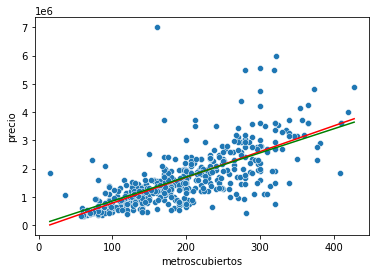

In [11]:
sns.scatterplot(data=df, x='metroscubiertos', y='precio')
sns.lineplot(data=df, x='metroscubiertos', y='prediction', color='red')
sns.lineplot(data=df, x='metroscubiertos', y='prediction2', color='green')


# KFold


In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

def K_Fold(X, y, K=10):
    
    kfold = KFold(n_splits=K)
    #kfold.get_n_splits(X)
    rmse = []
    rmsle = []
    deleted = []
    for train_index, test_index in kfold.split(X):
        # Separamos el conjunto de entrenamiento y el conjunto de test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        linear_regressor = metnum.LinearRegression()
        linear_regressor.fit(X_train, y_train) 
        y_pred = linear_regressor.predict(X_test)
        data = {"y_pred": y_pred.T[0], "y_test": y_test.T[0]}
        df_temp = pd.DataFrame(data)
            
        deleted.append(100 * (y_pred < 0).sum() / len(y_pred))
        df_temp2 = df_temp[df_temp["y_pred"]>=0]
        y_test = df_temp2["y_test"].values
        y_pred = df_temp2["y_pred"].values
        rmsle.append(mean_squared_log_error(y_test, y_pred))
        rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        
    return np.mean(rmse), np.mean(rmsle), np.mean(deleted), np.max(deleted)

In [4]:
df = pd.read_csv('../data/train.csv')
df = df[df['ciudad']=='Mérida'].dropna()
x = df['metroscubiertos'].values
y = df['precio'].values
x = x.reshape(len(x),1)
y = y.reshape(len(y),1)
rmse, rmsle, prom_deleted, max_deleted = K_Fold(x, y, 10) # 10% de las muestras para testear
print(rmse, rmsle, prom_deleted, max_deleted)

644839.3753734664 0.16553826516219017 0.0 0.0


# Experimentación


- Revisar las columnas y el precio, ver si encontramos alguna relacion con un primer approach naive.
- Definir la expirementacion :D


- Definir un nuevo feature que sea zona urbana/zona rural por que pueden tener comportamientos distintos


In [5]:
def fecha_parser(df):
    df['fecha'] = (pd.to_datetime(df['fecha']) - pd.to_datetime(df['fecha'].min())).dt.days

def complete_metrostotales(df):
    df['metrostotales'] = df['metrostotales'].fillna(df['metroscubiertos'])
    
def fill_banosterrenos(df):
    df['banos'] = df.apply(
        lambda row: 0 if row['tipodepropiedad']=='Terreno' and np.isnan(row['banos']) else row['banos'],
        axis=1
    )
    df['banos'] = df.apply(
        lambda row: 0 if row['tipodepropiedad']=='Terreno comercial' and np.isnan(row['banos']) else row['banos'],
        axis=1
    )

def poblacion():
    df = pd.read_csv('../data/poblacion.csv', names=['poblacion', 'ciudad'])
    return df
    
def get_data(filename='../data/train.csv'):
    df = pd.read_csv(filename)
    fecha_parser(df)
    complete_metrostotales(df)
    fill_banosterrenos(df)
    df = df[(df['lat'] > 13) & (df['lat'] < 34) & (df['lng'] >= -117) & (df['lng'] <= -87)]
    dfPob = poblacion()
    dfJoin = pd.merge(df, dfPob, how='left')
    return dfJoin


In [6]:

class BubbleChart:
    def __init__(self, area, bubble_spacing=0):
        """
        Setup for bubble collapse.

        Parameters
        ----------
        area : array-like
            Area of the bubbles.
        bubble_spacing : float, default: 0
            Minimal spacing between bubbles after collapsing.

        Notes
        -----
        If "area" is sorted, the results might look weird.
        """
        area = np.asarray(area)
        r = np.sqrt(area / np.pi)

        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(area), 4))
        self.bubbles[:, 2] = r
        self.bubbles[:, 3] = area
        self.maxstep = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.maxstep / 2

        # calculate initial grid layout for bubbles
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.maxstep
        gx, gy = np.meshgrid(grid, grid)
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]

        self.com = self.center_of_mass()

    def center_of_mass(self):
        return np.average(
            self.bubbles[:, :2], axis=0, weights=self.bubbles[:, 3]
        )

    def center_distance(self, bubble, bubbles):
        return np.hypot(bubble[0] - bubbles[:, 0],
                        bubble[1] - bubbles[:, 1])

    def outline_distance(self, bubble, bubbles):
        center_distance = self.center_distance(bubble, bubbles)
        return center_distance - bubble[2] - \
            bubbles[:, 2] - self.bubble_spacing

    def check_collisions(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        return len(distance[distance < 0])

    def collides_with(self, bubble, bubbles):
        distance = self.outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return idx_min if type(idx_min) == np.ndarray else [idx_min]

    def collapse(self, n_iterations=50):
        """
        Move bubbles to the center of mass.

        Parameters
        ----------
        n_iterations : int, default: 50
            Number of moves to perform.
        """
        for _i in range(n_iterations):
            moves = 0
            for i in range(len(self.bubbles)):
                rest_bub = np.delete(self.bubbles, i, 0)
                # try to move directly towards the center of mass
                # direction vector from bubble to the center of mass
                dir_vec = self.com - self.bubbles[i, :2]

                # shorten direction vector to have length of 1
                dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))

                # calculate new bubble position
                new_point = self.bubbles[i, :2] + dir_vec * self.step_dist
                new_bubble = np.append(new_point, self.bubbles[i, 2:4])

                # check whether new bubble collides with other bubbles
                if not self.check_collisions(new_bubble, rest_bub):
                    self.bubbles[i, :] = new_bubble
                    self.com = self.center_of_mass()
                    moves += 1
                else:
                    # try to move around a bubble that you collide with
                    # find colliding bubble
                    for colliding in self.collides_with(new_bubble, rest_bub):
                        # calculate direction vector
                        dir_vec = rest_bub[colliding, :2] - self.bubbles[i, :2]
                        dir_vec = dir_vec / np.sqrt(dir_vec.dot(dir_vec))
                        # calculate orthogonal vector
                        orth = np.array([dir_vec[1], -dir_vec[0]])
                        # test which direction to go
                        new_point1 = (self.bubbles[i, :2] + orth *
                                      self.step_dist)
                        new_point2 = (self.bubbles[i, :2] - orth *
                                      self.step_dist)
                        dist1 = self.center_distance(
                            self.com, np.array([new_point1]))
                        dist2 = self.center_distance(
                            self.com, np.array([new_point2]))
                        new_point = new_point1 if dist1 < dist2 else new_point2
                        new_bubble = np.append(new_point, self.bubbles[i, 2:4])
                        if not self.check_collisions(new_bubble, rest_bub):
                            self.bubbles[i, :] = new_bubble
                            self.com = self.center_of_mass()

            if moves / len(self.bubbles) < 0.1:
                self.step_dist = self.step_dist / 2

    def plot(self, ax, labels, colors):
        """
        Draw the bubble plot.

        Parameters
        ----------
        ax : matplotlib.axes.Axes
        labels : list
            Labels of the bubbles.
        colors : list
            Colors of the bubbles.
        """
        for i in range(len(self.bubbles)):
            circ = plt.Circle(
                self.bubbles[i, :2], self.bubbles[i, 2], color=colors[i])
            ax.add_patch(circ)
            ax.text(*self.bubbles[i, :2], labels[i],
                    horizontalalignment='center', verticalalignment='center')

def plot_bubble(df, title=''):
    bubble_chart = BubbleChart(area=(df['value']),
                               bubble_spacing=0.1)

    bubble_chart.collapse()

    fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
    bubble_chart.plot(
        ax, df['name'], df['color'])
    ax.axis("off")
    ax.relim()
    ax.autoscale_view()
    ax.set_title(f'Peso de cada feature en la predicción{title}')

    plt.show()

In [7]:
def plot_prediction(df, columns, column_to_show='metrostotales', column_to_predict='precio', kfold_flag=False, title=''):
    df = df.reindex(columns=(columns+[column_to_predict])).dropna()
    y = df[column_to_predict].values
    df = df.drop(columns=[column_to_predict])
    X = df.to_numpy()
    print('Size: ', X.shape[0])
    #from sklearn.linear_model import LinearRegression
    

    col_avg=np.array(df.mean())


    #linear_regressor = LinearRegression()
    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(X,y)

    df['prediccion'] = linear_regressor.predict(X)
    # print(df[df['prediccion']<0])
    
    coef = linear_regressor.coef()
    print(list(zip(df.columns, coef.T[0], coef.T[0] * col_avg)))
    
    data = { "name": columns, "value": coef.T[0] * col_avg }
    dfForBubble = pd.DataFrame(data)
    print(dfForBubble)
    dfForBubble['color'] = dfForBubble.apply(
        lambda row: '#9CE699' if row['value'] >= 0 else '#DD6E77',
        axis=1
    )
    dfForBubble['value'] = np.abs(dfForBubble['value'])
    plot_bubble(dfForBubble, title)

    print((df['prediccion'] < 0).any())
    
    sns.scatterplot(x=df[column_to_show], y=y).set_title(f"{column_to_predict} en función de {column_to_show}{title}")
    sns.lineplot(data=df, x=column_to_show, y='prediccion', color='red', label=f'predicción de {column_to_predict}')
    
    if (kfold_flag):
        X = X.reshape(len(X),len(columns))
        y = y.reshape(len(y),1)

        rmse, rmsle, avg_deleted, max_deleted = K_Fold(X, y, 10) # 10% de las muestras para testear
        print(rmse, '  ', rmsle, '  ', avg_deleted,"%", '  ', max_deleted )

Size:  518
[('metrostotales', 5038.279511615253, 1229048.4085844143), ('habitaciones', 139468.05664888464, 388787.40116021124)]
            name         value
0  metrostotales  1.229048e+06
1   habitaciones  3.887874e+05


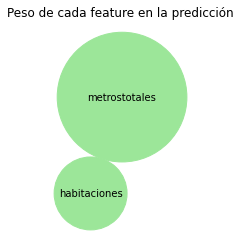

False


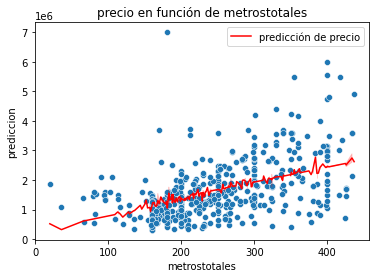

In [8]:
#df = get_data()
columns = ["metrostotales", "habitaciones"]
plot_prediction(df, columns)

In [62]:
df = pd.read_csv('../data/train.csv')
(pd.to_datetime(df['fecha'].max()) - pd.to_datetime(df['fecha'].min())).days

1826

In [17]:
df = get_data()
print(df[df['tipodepropiedad']=='Edificio']['banos'])
fill_banosterrenos(df)
print(df[df['tipodepropiedad']=='Edificio']['banos'])

242       NaN
510       NaN
1228      NaN
1684      NaN
3029      NaN
         ... 
238459    NaN
238890    NaN
238933    2.0
238982    NaN
239142    4.0
Name: banos, Length: 774, dtype: float64
242       NaN
510       NaN
1228      NaN
1684      NaN
3029      NaN
         ... 
238459    NaN
238890    NaN
238933    2.0
238982    NaN
239142    4.0
Name: banos, Length: 774, dtype: float64


### Lista total

In [19]:
df['banos'].value_counts()

2.0    87683
1.0    58173
3.0    49365
4.0    18558
Name: banos, dtype: int64

# Como primera experimentacion vamos a probar con todas las features, y sin segmentar para ver si obtenemos resultados. Y dropear los que tengas columnas incompletas

Nos da negativo si ponemos muchas features. WHY?


True


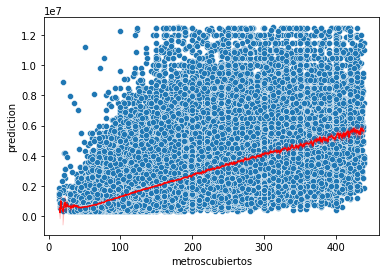

In [20]:
df = pd.read_csv('../data/train.csv')
df2 = df.reindex(columns=["metroscubiertos", "metrostotales", "habitaciones", "banos","antiguedad", "precio"]).dropna()
#df2 = df2[(df2['lat'] > 13) & (df2['lat'] < 34) & (df2['lng'] >= -117) & (df2['lng'] <= -87)]
#df2['lng'] = df2['lng'].abs()

y = df2['precio'].values
df2 = df2.drop(columns=['precio'])
X = df2.to_numpy()

#from sklearn.linear_model import LinearRegression


#linear_regressor = LinearRegression()
linear_regressor = metnum.LinearRegression()
linear_regressor.fit(X,y)

df2['prediction'] = linear_regressor.predict(X)

print((df2['prediction'] < 0).any())

sns.scatterplot(x=df2['metroscubiertos'], y=y)
sns.lineplot(data=df2,data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYIAAAERCAYAAAB2CKBkAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+j8jraAAAgAElEQVR4nOydeXhV1bn/P/vM88k8kJCEkIQhIUwRqBVaiVBsGVRwFqtiud6fGCra2vZWUbR6nSvV1nlqq+LQWqXqtXUoWJxAZpkDCQmZ5zNP+/fHyd45+5x9kLZQpZ7v8/hIzl577bXWXnsN7/t9v0sQRZEUUkghhRS+vtB82QVIIYUUUkjhy0VqIkghhRRS+JojNRGkkEIKKXzNkZoIUkghhRS+5khNBCmkkEIKX3OkJoIUUkghha85TsqJQBCEJwVBaBcEYccxpL1fEIQtg//tFQSh999RxhRSSCGFkwXCyRhHIAjCDMAFPCuKYtU/cN81wERRFK84YYVLIYUUUjjJcFLuCERRXAd0x/4mCMJIQRDeEgRhkyAI6wVBGK1y64XA8/+WQqaQQgopnCTQfdkFOI54FLhKFMV9giBMBX4NzJQuCoJQDIwA3v2SypdCCimk8JXEf8REIAiCDTgVeEkQBOlnY1yyC4CXRVEM/zvLlkIKKaTwVcd/xERA1MTVK4rihKOkuQC4+t9UnhRSSCGFkwYnpY8gHqIo9gMHBUE4F0CIYrx0fdBfkA58+CUVMYUUUkjhK4uTciIQBOF5ooP6KEEQmgRBWAJcDCwRBGErsBNYEHPLBcAL4slIkUohhRRSOME4KemjKaSQQgopHD+clDuCFFJIIYUUjh9OOmdxVlaWWFJS8mUXI4UUUkjhpMKmTZs6RVHMVrt20k0EJSUlbNy48csuRgoppJDCSQVBEBqSXUuZhlJIIYUUvuZITQQppJBCCl9zpCaCFFJIIYWvOVITQQoppJDC1xypiSCFFFJI4WuOk441lEIKsYhERA51uWnr95HrMFGSaUWjEb74xhT+ZaTa/j8HqYkghaQ4nh96KBRhZ0sfLX0+8p1mKvMd6HQa+TkHO900dLtxmvTotQLuQJgcmxFvKExTj5d8p5mKLCs72wZo7feR7zCRZTewp9VFIBShvtON3aSlc5iTjgE/hWlmLEYdnS6/atmPVp7j3U7H0o6x5RmWZsZu1EXr6TQRjkD7wNC9AIe63HS5/Rg0Gro9ASwGHXlOI6GwMm0kIsr5ZtuM+EMhwqJAukXP6Fz1OkciIk29blp7/bQP+Ml3mhg3zInBoFWkeWtnKyte3IIvGMGk13DfeROYU5kn102qU5fbj8NkIBCKkGsfeqeF6WZMOi0dg++o0GlmV1s/LX0+ijPN+IPiYBuYKc+ysLN1gNZ+P/lOI1lWAy390fuK0i009nhU2/dobX+sfSAUivB5Sx9H+nw4zDryHWby7SZ2tvXT6wlgNehw+UM4zHqybUYEgcE8h96d9O+2Ph96nUCPN0imxaBo1y9zYk1NBCmo4lg+9GNFKBTh1a3N/PzVHXJet51VxVnjC9BoBPk56RYDl36jmAfe2SenW15bzrMfNmDQCVz97XJuem0oj1XzKxEEuPFPOxXp39zewpnj8hX53Lmwmu9V5aPTaY5anmOZDGI/2By7iYNdLpY9t1m1ndTa8fazxzGpKI2ijOiHrlaeZPW499wJaDVwx5u7OL+miNXvRq8VZ5q56ltlPPy3/cytLkCrgZriDLzBEMtfGHr2yrmVvPJZI7Vj8jjY6ebMynxFnSMRkY8OdnC428fK14baddWCKs6qHiYPWgc73XKdAHzBCCte3MKoa6YzMscm1+lX7+5TlPNodVu1oIqH3tuH06TnwqnF3PJ6zPPnV/HQ+/to6PJG6zGvkuc/bqDPF+Tq08u56U87EtofSNqHIxHxmPqA2rv5+ffGYNJrVeu2YlYFJp2Glzc1yfWryLFx/pQibl37uZyubmY5v9jYyNWnl3NW9TB0Os1x+97+GZx0WkM1NTViKqDsxKO+w8V3V6+XP3QAk17DG3XTKc22/UN5bT3cw/mPfpSQ15ql07Cb9PJzrj69jCc+qE9It+S0UgDVa/csGs+y5zcrfrtr0Xh+/PLWhLSPLq7htLIstjf3Ji3P+OHpR61L7MCebjFwbk0hRRkW2vp9/O6jRlr6fIp2StaOS2eUMjrPwZzKvKTlSVaPpTNKCUeU7XH16WWs3dacMDDdOHcsD767n5Y+X0K+S2eUUjs6R1Hn+g4XTT0elv52U8Jzf7dkKjUlGUQiIh/Wd/JhffSQwFc2Ncn5P3VZDaePzpXf+ZLTSlXfW7K6LTmtlFF59qTXHnpvvyKPPa0Dqvm/UTcdIGkfHvAFj6kPqPXdutoyHl1Xn7RuS2eUUpYTrUO6xcCNc8cqJs3Y+jzxQT2/WzKVDKvhuH1vySAIwiZRFGvUrqV2BP+h+Fe3mW39PkWnhOiqr63f9w93zJY+9bxa+3x4AmH5miCgmk46a0jtmjsQSvjN6w+ppt3Y0E1hujlpeQ73eLGb9Edtq0NdbnkSWDytOGHQHfAFcfnDdLv9lGbbkrZjRIQ739pFQZqJph6vappk9YiIiW0lCDC3ukAuj5T21rWfKwZQXzCCNxCS82nt8zF++FD+bf0+ut3BpO9ebYdTN7Oc337UQI8ngNOsZ+Ohblr6fFw5vRSDVqNet4B63QSBpPUWhMQ8kvWZ9gEfojh0Ld9p4pxJhQgCdLj89HkCSfuk1B6RiEi/L8SV06MLEWnCi4hD5VHLQ6fRyHU4Z1Ihu1v7VcsxKtdOusVAW7+PYDiStB7HayI4GlITwX8gjodZx2LQYdIrP2KTXoMlxk58rMh3mlXzynOasJv0imtq6cTBgU/tmtWg7MImvQaLMVr2dItB/ui0Apj02kF7rXp5ImJ0BXnvueMZnm7GHQgnTKLSwH7OpMKkg+4TH9RTnmNjUkQk12FKUm4t59cUcf6jH3Hl9FL1tjaqvwONABExsT20mqNPpNL95sF3qxEgz2lSpM91mAiGI6rPzXWY5Ikwtt6r393H0hml5NiNHOhwc2OMmeb+8yYk6UfqdRNFktY71ngh1UP6d3zaHLtJ/nf8pP34+noeuWSy6n02k476DhdF6Rbe3tWmOuFpB/tismeX59jQaARMeg1CzLtSWzwsry2nIM2Mw6w/aj1ONFL00f9AqH2sK17cwqEu9zHnEQiHqZtZrujwdTPLCYYjX3BnIirzHdx2VpUir9vOqqIy30lJppW7FlZj0mt4ZVMTy2uVz1xeW84fPmvi9a3NrJqvzGPV/Eq8wVBC+sfWHeD2s6u49BvFPPFBPQ++u59H1tWj1QjkOUyq5Vk5t5LH1x0g3WKgsdvDeY9+xIWPfcx3V6/nrZ2tRCLRUUga2I+2e/EFI9zwyjYOdbkpybRy3+BgGNuO4YgoDwivbGrip3NGU1dbxrKZZSyvLeNnZ47msXUHEtpjxawKMi0GXt/arHg/r29tZnxhmvy3BGnAj63nsxvqWV5bTkWuncp8pyJ9SaYVnRZumV+pbOsFVVQPcybd4RSmmSnLscmTgPT7/761ixvnjlV9R/F1W7WgirXbmnls3QFWzqtMeNdrtzUP1WNe9H29vrWZlXOVae87bwIlmVa57c+tSZy0b3ptR0IfWF5bzvUvbeO7q9ezob5LdcI7t6aQbLuR286qSngHJr2Ga8+o4H/f2sXhbjfLa8vRCsjp1MrxwDv7sBp1qv1Eqse/AykfwX8gPjzQyYWPfZzw+wtLpzKtNOuY8qjvcHH5058wt7oAQQBRhLXbmnnqsin/1FZVYmi09vnIc5qozHfKTrlQKMJHh7o40uPFaTEgRkTCiFTk2PGHwjT3eMlzmqjIsrGzbUA2d+U4DLT3+9FrNXgCYbJsRtz+EM29XvIcJi5+4uOEFdbaZadRlmuXy3O4x0tEhMfXHWBbc39SP4Vkq5V2W3ta+3lknbo/QzLDSO0tsaJ2tfazt22AlzY2RQeFd6Lp8p0mLju1hPv/uldeKd5x9jiGZ5jJshkJR6DD5SPbFnVM37r2c+ZWF+A0aRlXmIY/GMZs0JGfZmRzYx83vLJNzudH3xlFcYYFTyBMusWA2x8kFIF0q55TijIUTCAJCtaQy0+ew0T1sOj72t7cx/mPfqhqW2/q8XL1c5sT8ntk8WQyrQaC4QjZNiO+wXdaEMMashi0CAIEQiKdLr/MGmrr92E363n500a+PSYPbyCEfZANlm41sK/dxfu72/n26Bwqcu2MyXMwIkvJGnp/bztXPJ04Ztz4vTFkO0wIwL726HuRfB3Xz67gnrf3Jtzz8CWTGJVrxx8O0esJ4faH0Gk1dAz4ae3z8fuPo36iRy6ZxKg8O6IImw/38sA7e/l/3yrjhj9sT8gztp8c6nLTPhAlIRxv1tCX4iMQBOFJYC7QLopilcr1i4EbAAEYAP5bFMWtJ6o8XyckM0cc6zYzEhERRfjR7NHsax/gxY1N9HgC//AKJdZPke80YTPqcZjD2E16RQfX6TRMLkjDoNXQ4wmSaTMw4AvR7Q6Q6zAya+yQSWtSUbqcZygMVXnOQRpfkEhEZJjTRHVVPu/vbU/iB/DIE0EgFCHTqufD+m5mjMphxqgcVZt2RU7U1r+7tZ+CNAszy7MpyjAzPMOiYJPUzSznrR0tXH16GU6TFq0gsGF/J3lOEyOyrBRnWBiebmZsvoNsm5FHByeScyYV8twnDSw5rVQ24/zynb2svmCiTEPMtploH/AxItPGs1dMob3fT683iEEbNTO5A2FCYfheVT5Vw5w0drvRaTU0dbsJiyCKIhFEDnV7qRzmoCDNjEYjcKjTRVu/n0A4jMOoxxOMmsPybAZa+/yIIkREkTa3l+1NA9z51i7qZpYrzBv3njuecQVphMKiar/LsOgJhiMyRXR3Wz96nYDLH6Kj349Br6Huhc0yI+i+8yYwMtPOrrZ+RECnEciw6siyGegcEEm3Gnh/TyuLaooZ5jQzdUQG/mCE4kwrI7Ki/bO+w0Vbv488hwmnSd3skmbRkW0z0OnyE4lZD+c7TYzMtqneU5FrpzjTyt/2tuEPiliMWlXHenmunZKs6IKpONPKhOFpdLj8Sb/LSESksdtNx4AfTyAcbfd/I530RPoIngYeBJ5Ncv0g8C1RFHsEQTgTeBSYegLL87WBtM2M9xEcyyB+LHTHY0E8uyaeFhrrs/D5Qry+o5WH3t/HRVOKWR6zMl5eW055ro2Zo3IBJR2wONPMNTPLFYPxilkVjMhyk2kzqH50DpMeny/Ea9tb5OdJA7JJr+H+85U27eoCBxdOLebypz+V06xaUMWLnzbQ3Otn6YxSKnLtpFn0/PIve5hTlc+ajY2cX1PE4ic/UdTXoBNkmmlxppnbzqri56/uIMOiT2D71M0s57OGHh5dfzCh7W47q4pfvbuPQEhMuHbvuRMw6pXP+cmcMTR0e6nvdFOSZeVgh4ufv7qd62ePoqnHywufNiY8P56uuWp+JRsPddLQ5eW3H0UnLa0GKnLshCMigUCYMbk2Vs2viqP4VvHY+v28/XknNcVOzj+lmAffS6RdXntGBU9vOERLn48nPziA2x+SzUznTc6npiSbK2LfwfxKmrr6aR0IK/J58KKJBEKiot+98Gmj6uTlCYQV71XyAZwzqZD/VZnw7lxYTUmmdXDADnDTaztJtxhYXlue0LdjvzWNRqA020auTa/aPjk2He/uaWNfm0vOR61vn0g66Qk1DQmCUAKsVdsRxKVLB3aIoljwRXmmTEPHhn92m3m8aKOx+XyRueXTg10sfvKTpHS85bXlnDoyky53gK2He3lxcAt//ewKHnxvv2r6qSMy+Phgd0JMwtQRGYQjYtLnFWea+a8ZI1k1yPl+8MKJXK9CZXzqslPY2tTLMxuibJk/XzOdHk+AS574+Ki0QskcJD1r9QUT8QUjfP+pTxLSP7J4Mp8c7PmHKbU//s4outxB7CYtTpOeW2L46ytmVVCaZWXz4T5sRi0PvLMvaXnj6ZpPXnYKF8WZHJfNLOPx9fX89oopCILAdS9tSTAnXjd7NHXPb2b1hRP58ctbv/B5Ujrp+nM/mCpPArHpn718Ch8c6CQiDjF6JGpnfL+T2DpaDUwuTsek0/D9pxLzlCa41e/sVzB8RBHGD3dyxuhcNjZ0c+mTQ+8r32ni3JpCCtPMlGbbmFCYpgiWlFb1Wo3Aj17emtA+dy8az5bGHiwGLcMzrfS4g2Ra9fxAZafxr9BJTwb66BLgzWQXBUFYCiwFKCoq+neV6aSGtAr5RztNMmfgP0pji83naBS/0mwbrf1+haM1Pl22zShzuWNXbtk2o2r6DIuB5l4fz344ZG4RRXj2wwaGp1sQSU7/a+jykuc08rslUwdpfaLqMz6s78Ks13LVjFIeXldPh8tHryd41HpE4tZcDV1evMEw3W51KmPHgP+fotSmWw3c9X97WHJaKb/8q9I5ed9f9vLwJZOxm7RkWo1HLW88XbPL5VekMek1MRTIaFkburzy5CHBO0jxlSiVX/S8eGpp54BfNX3bQJTK+frWZi47tYSnNxySqZ2g7HctfT65XHcuHIdZr1XNc3SejWx71GwXe480kZdl2+hyBRSMNICXNjaxcHIhTb1e2gf8qgFtv7pwomr7tPX7GZZuZsAX5r8GB/+62rLj8h0eK7501pAgCKcTnQhuSJZGFMVHRVGsEUWxJjtb9aS1FI4TJP9CLP4ZGlt8PkfLM9dhVLAl4tM19ngS2BvnTCqUaYbx6a1GHbkOIz2eAA+9t58H393PQ+/tp8cT9TnkfcHzdBotlzzxMbtaB9BpBdU04Qg88M4+ujwBzq0pJMdukmmpyfKVNmTVBQ5WXziROxeOQ6/RJG1zi16bNC9pI6927WCn+6gDrjcQpiDNQlOP56jljadr5thNivR1M8u55+3dXPqNYgrSTGRYDar5SDTP2PeV7HkmvYaiDIvierbdqJp+d6uLx9fXc35NEc990sDFU4sU1M5kzzEbdEnzzLIZ2Xa4l1sXVCXU9aWNTbQP+Miw6hWMtMfX13PpN4pxGLUYtBqZoRfP3ovt57HPzHUYQRTkSGoYopzGpz1RdNIvdSIQBKEaeBxYIIpi15dZlhSiOF40tth81GihsXma9BpumV/J61ubufaMCkW6G+eOZfvh3ujAec44fnXhRCpybFE9l16PKt0002ZgXJ5DhW5axbh8J+Pyndy1sBqrQcutC6pYXltGvtMk24Fv/NN2fMEordPjCyZQGetmRimt0iq/ItdOSaZVpqWq0QrvO28C1YVOZo/N4uJpxfz45a3c8Mp2Vry0BRAT6Jor51XS7fartp1Es1S7duPcsby0sUl+D2qDCUBDl5sXNzZRN7NctbzxdM1V8ytBCPPbK6ZQV1vGktNK+e1HDTR0eXngnX1oNQL3vr07gcq5an4Vz26oB+CZDfXcukC9fe5aWM3po7J4o246k4enK6idf/yskVXzk7+D1e/u47rZoxmebqFqmJP/+e6YpP1Oos9qtaIqHbnf4+epDQ30uKP+n2Uzh+ra4wmQYzeh1Qi88GkjS06LXr9yeikvfNrIiCwbWo0gr9zjd9ehcDjhPd8yv5KIGMYdF0T3yqYm1T50ouikX5qPQBCEIuBd4FJRFDcca54pH8GJx/GiscXmk+cwyTTI+DzrO1z875s7uXjaCLyBMGkWPS19PnLsRrJsej5r7FfozqycV8nYPDtOi56GLjcDvuiHZDXpsOg1nDYym6Y+L50DfhCgY8BPjt3IuHwnJpOOSETkzR0tXPfS1gSHeIfLz7kPfyTXId9p4oczR1KSbefvBzoJR+APnzXJUhJLZ5SyYHwBI3Oi23WJltrt9mM3GWS2TEmmlVAowpbmXtm+nO80yQFGFTk2ls4YSVgU0WsEHv7bAa6dVYHZoE1oO60G3tjeSpbNSL7TiMsXZm+7i1Akwqmlmdzwh23MrS7AbtJiN+kVGjfR+AEb3mCE61/aKps47CYthWkWrEYtGVYDr285zMyxw+hy+cm0GXn1s0ZGZDsYnWfnchUq5sOXTOKq331GdYGDK2eMxBsIYTboKMk0YzPqaR+I0l/bBjz0e8IIGgGbUYvLH2JkVtSEqSYK2NrnI9NmpLGzj8IMB20DPna3uuR3IEGie0qO54goUpplpSLXTr8vSHOvlyyrEZEIWTYzI7KsBAJhtrf00drvJ9tupL3fwx1v7pWZWj/6zih+9sftCc7av+5uY3+bK8G5b9Rp6PEGeXx9varExaOLJ/PypgYunjaCXk+QNIue3390kMtOLaXbE+T6l5S+qOJMM/csGk+XO0B+HOX6n8HRfAQnbCIQBOF54NtAFtAGrAT0AKIoPiwIwuPAQkA6UDmUrJCxSE0E/3k4WiT09qZezn9MRRPmB9MYV5iWcF88a0aNbXE0hzgoP958p0lmnlw0pVjB9Y9lNH3RRBmJiLz9eSveYJhr10RZ0kfTVnrig/qkjkE1vSOJQz88zcxr24/IbJPiTDM3za1kX7sLTyBEltVA5TAnmTYDO48McN1LWxLq8+3ynISoWulats2kGkfw2yumsH6/0nEb79z8Z4kIgUCYV7cd4aY/7eDK6aU8vl5du6huUHNKmqDPmlBwTPb0ZOV6a/l0IiIJC6JPDnYpnMVS+nsWjWdv+4CsIQVKH8GjiydzoMOVQGA4rSyLbo+fI71+pdDeIDttY0Ofaj/+R/GlTAQnCqmJ4OTEsUo193sDhCLQ6fKT7zTT5fZxxdObEvJ75JJJlOfaVT/gexaNZ3fbABAdlHo8AcVgkyzg7qnLot+IIAisfG0HDV1eBQsl32ni4qlF5DtNFKSbCYYjDHNaFAFMyepsMejYeriHLndADkRbNrOMB9+NOg7llbQ/RH6aCRGR6WU5soKpJNNtNUT9H4VpUenlbvdQQF2uw4RGgDkPJLbJ3YvG0+P2k2UzIgJ5DhOhSJiOgSBNvV6GpZk50uvBGwgza2wuo3MdHO7xcKTPy4AvREGaGQFo7PFg1GlZtXanTC294+xx9AzKMTstetLMerY19TEqz87U4gya+300dLsxaDXc9dZuplfkyE7WVzY1cf/545lSkinX0WbUYTFoGfCFyHWYGPAGqVuzOeku56dzRpPjMLGzpV/O86a5Y5k1JjpBx/c7GJLxNuu1eAJhWvt9HGh38Z4UnJZjZ1yhg46BgCx7LklG/31fB9e/vE3hLH5lUxM//94Y8p0mxuY6ODJoGpJ2cK39PryBMD/74w7OmVRIhkVPWa4tKpmebmbCsDTa3D7a+vx0uv3k2k3c8ebnbGzok/vH0hkj0WigIM3yT8mmnwysoRT+g3Es2kcajUBRuoVXG3sU3Onbzx5HcaaZhi6vnJ9JryHPYUrKcNrbPsCD7+6Xt+y//ahBIZaXLOBu8+FeVr+zX7a15ziMhEJDrKGWwcjRxdOK+Z8v4Her1XnV/Cre293EtWdUcP9f98rPrcixceGUYpkyadJHYwUkWYv4fGJX7rtbBxJiPtItBoXZxBeM0OPxo9dpWRFjDqubWc6ajY1cNaOMZzfUM7U0G60mymLp93XS6wknPPfZD6O28tvOqqLPE6QwI+p0vvv/9qimi13VSlLZsave5bXl5DtNqnWU8vjVhRMTJLfvO28CnkCIjgE//nCEa+PuPdzt5v197XJMQey7MugEbl37OVecOgJPMKwqhV2aacUdyFeV4h6WZk6I37hx7lh0Wg3XvriF62aPornHizsQRivAuEInM0flcqjLTY8nwPq97Vw4pVhmCMXmXZw5tFiJnQQunFIs05il/nGssunHgtSOIIUTjmM1CSSTq37ooklc/dxnCh/BqSMzCEfUZYbj+e/xcstqg7Q08MTKNd+zaDz72gcUUhKS3LPEBYcofXH1BRPxBMLyASQN3W5FzIOU54ozyjHqtHR5AlgM0dWt06RXjVWIl+mO5cJHHdQWFj2caKaJj1cw6TU8uniyagSsZIaKD0B88KJJLBtsc7W2lcwxGlAte3y6uuc3JzWFrfnBNFXzn5TH8z+YKgd+xV6/a9F49rcPyDu22GvLTi8jEI6oXpNkvKU4CrXnThmRLg/Usdd+t2QqBq3AeSr9dOmMUjItBvzhKE03tm+dWZVHUYZV1q1Sa7PHL61hWJpZDlr7w+ZmIiKcUpLOTX/akbAYOhbZ9FikdgQpfKk4ltiESESkuVddjrm518sjiyfT4w6SbtXz9AcHGZFlYUpJZsIAJu0AYu8vSrcQDEcUpppRuXbeWj6d1n4fAgI/XLMFiA700gAfFiMys0ZajTpNWtWo2LZ+P/WdLg526uVgtNjySNLX5bl2/vv3QwNsvtPEDXNGq9Y7VqY71rEcuypUW/1X5NrlHU9xppmb51fR500u7ewLRhRSyb5ghN0t/UnTS//WCmDQqctMx6aT4giS0VlbkvQPKY8jverXdRoYm+9QveYLDdUl/lpERBFHofbcnqNIcUvMILV8uzwBxeTjC0aF5SYVpVOSZWNOZR5v7GhRvf+jg908vr6eBy+aiD8oKiLeJYnzZzYM9aV4CfF/BamJ4DgidYarOpKZYvIcJuo7XHS5/XS5AthU5IeLM81oNYJiG728tpw8hwmNRmBOZR6j66bTPuDDrNdS98JmxcBo0mvocPmpKUlP2AXccXY1JVlmNIIGg05IGOBvXVCFQSfIkgqCAKPzHYqVtS8Y4f6/7pVXmfEBXKvf3adYHXe6lMFjLX3RgSVZ+9gH5YnVZK9//uoO1dX/mDwHb9RNp9vtp7nXx3//bhN3Lxqv+gyJux8rKpvvNFGWo661Exu/UJhuxnYUOWnp3+YYqXApbezuJttmVDX/SXkY9RrVZxSkmQH1thuVa6el16N6TSNE7ez72weSlj3Dqq5PlOswodeql0cUIYL65OMZnAw1GoH8JN+DdH7Ctqa+hMnk1rWfs3RGKYunFctU1ngJ8X8FX3pA2X8KJHPDd1evV5Uv/k9FJCJS3+HiwwOd1He4VOurFpvw4EUT+bxlgO+uXs/GQz0c7Izq2Mdzp2+eVyk7BmFohSUNXFIE9bTSLMYVpHHDnDGK+5fXljMiy0r7gLsuSCcAACAASURBVD9BVvinf9xGS5+fW9fu4OZ5lQkD7Y1/2sGtC8bJgWmPr6/H9Q8cFiNdk85SWDm3kq5B4bFYPLOhXjWOIM2ql9su2VkD0upfuu/2s8eh1UTbPN1ilJVIH1t3IIHjXzeznLXbmvnF2ePkmAGAi6cWccebuxLehSQJLu1GKvOdaDRCUulwyfYtxRG8vrWZlfMqKc40s3haNCBr9Tv7ufiJj7lmZjnFmWbVPOwmbVIZ8zG5dlapBH/d8/ZuMmxGHrxoouKaFM/R6/HLu73Y67cOxmg89cHBpFLcajLmUlxDfECbdL0oY4j/P26YU7XMf/gsGv8RGx0d38ckKWyp/scLqR3BcUKyMwBGH8ej5r5qONYDcOJX7jl2E6II3/tV1PZdmG7hR4M201hBs9NGZhGKqEs8dLh8Mnc//jmjrplOY7cbi0FHKBLhZ3/czrzxBar57G7tZ2ppNjuPqJtC9FqBN2LKPeALJV3NJTs8Z9LwNO5eNJ4/bDrMlNJMbpw7VsF6uWhqCa9vaeauReNl/v3j6w4wIstCcWbUnFCQZla1d4/Jc/Dna6azq7WfIz0ejvR6OdTlZnJRumLy2NbcD580cNei8QiIOM16/OEIT35/CsPTzFgNWj5v6SciRtUyY8XlBAFMOg2TitIYnmFRyFIf7HIrpDxMg87L//neGPIcJqryHEwuSqdxkA1kM2m5e+F4Lo3RVpJ2N2t+MI1uT3RnaDZomTA8Td5ZRyIi5Tm2BBnz+g4XL37awCOLJ7OpoYdwBNkU9/NXd/Dna6Yr3p/EGtrY0E2PJ6Coo0aAkiyL7P+pzHfIUiO5g3U2GLREItH2W15bTrbNSGOPR16lF2VauH72KO55e4/im5BUUQEMBi1nVQ+jNMtKh8vPrpZ+ucyAPJkk2zGMK3ByekXOcXMUQ2oiOG44Xho9JxP+kckvEAjT5fLTMRBAKwhoNYIczBSOiFw5vVTmn0uO3slFaRj1WtWPwqzX8uGBTvIcJgZ8QY70RU8eq8x3MDLHxogsKx/s72TpbzfK96rlU55jB6A5iRkh12FSaDZ9eqgrQZVScjQDCddWzKrgf17dEWXQzB9LSZaN9gE/z14xhT5vgAyLEYAPD3bz3t5OxbMleeJDXW4C4TB3nF3NT/+4TTHADE8zs+1IH0d6PGTajTR0eYiI8Fljz6Bk8pDJZVtzPz9+eSuPLp6M06yXB9NIRCQcQZ5olteWUZxpVjjEX9p0mJJMK794Yxfn1hRypM/LMGdU4tmgiwaHFaZb8PhD0SMrTTo+a+gmEA7jC0SwGqOyDsMcZv62v0P1W+n2BPhWRZQyKwWU7W0bYMAXYtRg+0f3mwL7Ovpp6PKSYdNz0dQiBKDAacZh1pFrL6XdFQCgtd+DzahXyGVoNAKeQIj7zpvA7tZ+Wa/o/JoiulwB2Yy3aFIBFhGC4QgZVoM88B7sdPOXnUc4a1IR3a4A3xyZxfB0EzkOM7sGKazLTi+jNNsaXfQgyocUhUIRth3pkympmTYdZr2WHk9Afu9j8x3cfvY4RTCb5GuK9gvjcTc5pyaC44R/9QyAkxHHOvlJss+x8rt3LarmyukjFLTDWMdqcaaZpl4fj647kDC4rppfxa1rd9Lc61eVaD5rfAGNPR42NnTL5ZNC9uMH8Nvf2EWPJ8CKWRX88vwJ/HDN0aW7M61G1mxs5O5BRpFBG9UE6hk8A3fNxkbuP28C+wYjfY3a6OCRbjHQ5Q5y02ufxNSjktv+vItASEyQMr7trCoKnWbe3dPGtqY+IiI4jFp+dcFE9rQNMKEojXyHiTc/b6W+w0WmNXpIT6yDcXltObcuqJJ9GtJvO4/088A7++Td28FOtxxYBvDe7vYEmuct8ysRhEiCw/qRxZO4blYFzb0+eVdn0mu4Yc5oTHotVzy9UfHsgnQzR3q8qt/K7tYBvMEIZ4zKUQTF1RQ7Oa+mWNF/Vs6r5PmPG7hkWhFhUVDUceW8StbtaWdvu4uijCoeem+H4qyD2WNy6XYHFQPtjXPH8sfPDjOhaLTCdKm223X5/NSUZCXIYv/qnb1y8NfPzhxNnzfEihc/ltPce+4EwmKEH7+8TdGu+1r7FbuShi43T21oYHltOcPSzBzocMk7jrqZ5dS9sJkb5ow5rpLUKfroccLxOCf4q4RjcXwfKy1UkpmOTRcbqBV7792LxnPP27v5yZwxMjc81rFYlmPn3rd3c/3s0QDy4BObx5ql0/AEwvz9QJciClWSCy7PsSecSGXSR08v02iEwQAwLYFwhEyrUVF36T3f+dYu2bksyUOIiOg0Gn7z/v6oKYYhOiJEJaNjVSsdRi0lmTa2Hekj3axn+OBJYlqNwDMb6rl5fhVbDvfSPhA9OEUrRAXYIhERd0DJf09G93zs0ho+PdRNRIwOMpkWA6981sT0ihy0GvhWeTadbj//9dvP5PuS0TyfuuyUBBrns1ecwsaGHtV3uby2HJc/rKDZLphQgFmvRRy0d8dOEhAV8vvdkqlcEnO6XLwstZT/XYvGk2nVs+SZjarX6p7fLLd/LJ04GV311xdNwmnWkG41K0yX8X270+VXjSyWnpnvNPE/3x3D3vaBhEhrNef+I4sn8/0nP5V/iw00LM40c++5E1i3ryNB3uQflaRO0Uf/DVCzg5+srKFjndSO9QAcSWZa8YwkDrF97QMsr63gSK83qdRvQ5eXPW0DaJI4Z1v7fJTn2mVxM2nA6fEEKMu2YTNqFR+jdF+Hy8/UEZnsbh1QHFgSW3f5PefZ6XL7+e2SKexrcymCfepmltPhCsg0P6n8sYeXS4em1K3ZrBgMpSCqupnleAIhBnyhBBphQbqJbU19MnU0yjTpVW2LYDjMN0oz6XIFyLQZ6HT5WDipkDve2o0vGOXZxx/kLggktP0rm5rodCW+x253MOm7zLYZeeAd5QluGk30OEq9VuDuRePxBEJkWA3sb3eRYTFw5fRS2geUO01vEge9Pxim251MYTUk/zteTru5T52m3Onyk2WzU5pt48MDnVTk2ORob4tRx2PrDtA+4KNjQF023BsIyceOxvcHaadbkGYm32mSFyDR+8IybTnqH4iqzuY7TcytLqC136faX4+n2Tk1ERxH/LNnAHzV8I/Y/g06gaUzSuUVp0GXOPFJss+xH08yh1g4Aj/743ZWXzAxwewjrRpjqXpqeeQN7mBumDOGO9/aJTufa4ozOLU0k50t/ar3WQzaY6q79J4BXt3SnED1i6eMiiLYjVrF4eXnTCpUBDP5glE21K8vmoQ7EOaZDfWMK3QmpLl17edyEFjsACPJFsfWqTjTTLc7xM9fHZpsVs6rxGrSKiaRkBhRmKYcRq1q2+c5E82fGVY92k7196AmH37PovFoNILilLn/9+0yxbMejpuYLCq0YpNeQ47DiEZQp49KlFWp/WOvZdkS+6P0ezAcBmBYmokLpyqjvVfOqyTfaUKXhO7rMOm5eGqRrEcV3x+e+KCe5l6vTAGVTKDuQFjegZn00biU6gIHc6ryWf3uPq6cXnrCzc4p+mgKCTia7T8Wh7rcLHtuM6vfiWr+r35nP8ue28yhLrci3bh8Z4Lk78hsGz87c7QqhU76INQGSkBOpybVe8v8StJtennl/tRlU5henslZEwo4rSwLnU5DIBxOuO/aMyoIhUX2tg1w5fRS8mM42vF1lyize9sGkq6GJQbRnYPyyt8sy2JEllWx6la777PDvfzo5a0snFSUlKoq3SudywBD1MzYOt08v4qfv7pd0Ya3vL4Tk04n3wfg8oaw6LWy7PKILJtq22sFgdvOGqd4RigSoTTbmij3PK9SIYcdW/aGLjdXTo8+64JTimQZBynNytd2cPvZQ89RpdfOraShy83rWw4n9K2V8yp5fN0B2XYfK6e9YlYFuQ6jIn+p792ydifhSHQh0+sOKs4HkNqu1x3EadapUmY7BnxJD0vSapDPNJDem1SP//mj8h3d/9e9XPedUazZ2IgvGPm3SFKndgQpJOBYHd/H6iw2mXTMq8qjJMtCW7+fXIeRYelGLn7sE9npGkv7M+k1eINh1bwL0y3c/sYueWu9ZmMjT11+Coe7PJgMOp7dUI9eq6EwzZp0hyY5fGMpj2a9houfGHLsxa62Y+seaza7cnopWoEEhs3rW5uZXpbFORMLZPPghwc6sRl0ctpRMdG/sW0sUQRvWbuT3y2ZkjSN1B7ShLN0xkiCoTDLTi/DF4qgEcCTZCJxB0IKc4lWq+HJDQflOvR61aNq2wf8OExa7jtvPMFQBINOi0GnYViaiWFpZh5ZPJnWXh8dLj993oDMhIktu8WgTdDoiY+ObujyYjVq5fczKtfO+r2tPLJ4skK+efE3StFqNPx11xH5Wp7DREQM81/fGkm+00SHy8+CCQXyjjXfaaLAaWGvyaU4vU561x3u6ClsyaKdm/u86LUa1dPvVsyqICvJWdmTi9P5ySvb5XoWZZhZclopnyeJ4N7U0MP5NUVyuSSaa3WBg/LB8y+Op9k5NRGkkIBjtf0f64QRiYi8t78zIT+JTx8f0XvnwmqcZvXIzhy7UUG1WzpjJD95ZZsiKnXHke1MGJ6W1EQnmY2k8tTVlnH7m7uTbudj6x5rOnplUxMrZpUnMGxWLahiYmEaBoNWfma+08Qebx9Xf7ss6aHnsfIYvmCE7U193Dyvkptj8o5NY9JrGJ1r5+5F4xWTo4Q1/zVNtQ2tBp18Wlp0cNZwwSlFclmW15ap3vd5S78syhfP8Fp9wUR8QoSVg2XNd5oSWFp3nD1OrotURyliNt6BGgyJsrlEEl2LF2lr6fXI8Rhvf94p3/ubiyfxnbF5NPZ4uOjxjxPqUTnMSZpFr+oQz7EZB9+XWbUNIhGwWXVykGHsNZtRRyCcyABbXlvO50f6FcSExu7okZXLZqq3dTiCwsTY0uc7qjT5v4oUa+grii9bruJYDqeJZdDMrS5Aq4FTijP4RmmmItilvsPF5U9/wtzqAow6DSOyrLT0ephamoXTrKPTNSSlHAyL3Pin7ZRmWvlu9TBu/NOQs3HFrApqitLpcPmxm3Xk2U3s73Cz9LeJMtUvXzWNDKvxC2Wv2weiej5XxBy2IrGUxuTbKcqwYDfqaB2Uku5y+9jb5iIUFvGFIkwdkcEPnk1krcQLgh1od7GrpV8hNiaxmKqGOTHpNfS4A2g0Gh5bd4C97dEV6/q97fz3t8uIiCIWg5abXx+Sf7797HEc6uhnWlkO7f1+Mqx6nvrgIO/t7cSk1/CH//4GO44McNOflLTLYU4jxZlWGrs9tPT5cPlCFGaYMOt1dLuDFKab2Nfu4pbXh4LefvSdUTy+/qB8aMu5NYUUOM0c6fPK6pqN3W7W7e2g0x0gIoLNoGXsMDvhCLT3+ylIN/Ojl7clTFgPXDCBG17ZJp+tMDLbhscfJNselSAZle+gtcdDUZaNXk8Qq1FLS6+HgnQLlzzxKfF47sqp5DlN7G8fYGkMG0pq89UXTKDLE0Cv0SjktK89o4LSbCulWTbVcx1unldJtzvIsDQTnS4fAhr5QKRgKESu08yRXh/pFj1721y4A2E0AozItPLLd/bS0OWlpthJXe0oWvujkijr97YydWSObB6Kn2TrasvkyfdEnkeQ2hF8BfFVoKIei+NboxGYPSaXYDgiSxmolbXL7U9Y9d84dywf13dSmjN0sItER63IsTG7Mp8H39snO3onFaVzpNfDRTHmm9vOqmLy8DRVJ2lzr49LnvgkaZli61ff4ZLzUBN3i2XzXHtGBRa9ltv/Gt1BaJIcMh4vCNY+4Es4jrClz8dLG5sYPstC3QvKwdpp0vHw3w7Q4QpwsNMtM43OrSmkKMNCa5+P5z4+xHk1RQo++y3zK9HroHZMPk//vZ7asfncf94EAqEI6VY9Rp1AdX6aYocW5ekXsfy1rfLfl36jREECyLAYyLYZABLa5/azx9HY7SbXasRs0PHo4O5KcgTHSjmrqbymDdrcHeboOQMSo+rhddHd4k1/2sH5NUWsjKnn8tpyrMaQqkZRKCJy+dOfyJIasRPv5d8skanMUj90mHQ09Xgx6zXsb3dxzfObue+8CcwfN4yidAttAz78IVEWC5R8Dw+9v1eeRFbNr+Lpv9fz9ufRSfjWBVVo3X76fGFe29LMdbNHIyASCIlykKN03//taE5qIj1jdA6njsw84SzE1I7gK4h/9iSnLwPHUtZk8tJLZ5Ri1ms5syqPkiybfGCMGm88WdzBi0un0dTrU0yajy6uUUQUq5UpFrETr2QOir83lgUUa8pYNrOMx9cr4wO0Aswam0tVQZqinT5v6U84jjBZve4/bwI7jkRjEZKVJ9m1Zy6fwt3/t4tLTy1V5d8/c/kUvh8j8RDf3kfj7e9pHVB95tIZpUwqSueq3w0J8iWLR5DaTxrQTToNne6gnFa6T3oXyd7J0hmljM5zKN79ynmVPPy3/cytLmB8oVNxIliytpYEA5/4oJ5lp5fJR16uXXYafd4gLX2+o0ptS3/HxgNIi4/YeJNk9bhr0XjueGOX6gJE+jaOB1I7gpMMJ5NcxbGU1e1Xd/zqNBpZorcow4plUMlSjTeejJ3T0udLiN9IVqbuQUdg7MlRLX1R09HsMbn8+Zrp7Gn7YvllSVcv32nCpIuuiM0GLf/75i55hViR62DsoCgbRP0Sh3vcrJxXqfAnjMy2qT6v3xdEq0le79jyxF9r7fexsaGPcyerO4tb+4/O00/G2/cNOpnVrhU4zQntrpY23WJg4vA07jxnnMzNnzEqR5FW+nf8/+OfGRFh/6AJrSLHxuEeD33eAA1d3kEp6YDCqVvgNCfNR3pGrHz1zpZ+7vvLHlbMGnXUdyD93esJKv4GkXvPnSAHxyWrhzcQUjiEizLMNHZ7efbDBiYWpR23ieBoSE0EX0GcTHIVx1JWaxIeeMkgnTIYDsu+hrqZ5VhNiemTxR3kOU2qZqwvMhcVZ5r5yZwx7Gt3EY5EqCpwygPv0Zg6UWerlhvmjJJNGWq23ete2sKYfGXswTdLs9nX0c9Tl51CtztAQZo5KQ/eatBRlmPHpEsueZxM5C7NEnW0J+PfZ1iVzJb4dMnuK860JuXgN/d5k7ZdrGnm0m8UK0ws0o6gyxNMYFRJ96u9T5M+KiftD0XkXUOs8xXAalI6deMds7KvI82MZZDRFfueD3S4aOjyYtCqv6P4+IQ0i17xd0GaWT5PQq09pL+lmAfJIRy7+zTroyJ3J9oknIoj+ApCTbb5ePOGjxeK0i3cubD6qGVV4+3XzSznyKDQm92oZ8WLW2TFy26XP4E3Xppt5dYF6lLE8VBrv1sXjJP9GPlOE+fXFHHti1u47y97eWRdPQc73fR4gtz9f7uPKr98/exR5DlNeIPhBHnsWF6/tCuSEImIvL2rjbN//SEXPvYx1720lSN9Pkbn2hPqtXJeJXqdwAd7W3H7Qwmc9RWzKvjDZ028vrWZVXHtdMv8Sn7/0UHqZpbzzIb6hNiC5bXlePwB7jgKT/+ZDfUJ+a6aX0X7gJdb1u7k2jMqEvJ8aWNiXMfrW5sV0tfn1qgH0ZXn2tnZ1MtV34qahG5/YxfLa8vlyHDp//HPLMux8XF9h/x+IBoBLd3r8QUV9X99a7Pc1tKk9Oi6em54ZTs/enkrV32rjPV72+W+JcVB/Ob9RAnv+PiEVYPtHt83pYWSVDa1uJe1Ww9z9ell1NWWcf/5E+QySLpCr25p5lCnusT78ULKR/AVxbGwdr5sqLGGpOjdZKwhiXe9dltUd2Z0noN0iz7hMPnqAgc/+94YOl0BcmxGcp1GRBGae724fGHynUbGDqpnxpZHYlpJR0Z2uIbMRdIzvsh2Hatt9M2RWexp7afXG6I0y0qGTc8VT2/kyumlsh5MLCSdmHifRKwvJTb/2tG5OM06drUMEAhFSLPqaeh088TfD3LXwvF8/6lPFP4HjQCnlWdxqMPN8AwLB9p6Kc9Lp30gGp9hHGyPYDhCOAK/+PPn8mHxogifN/dy5rhh9Hr8uAJhIuLQ7wsnD4dBx/BHB9qZVpZDl8tPps1Ij9vHdS9tJ91i4KoZpXR5osyg0bl2fhFDXa0ucHDljJEIgNOs43cfHaQ8Nw1BgOFpZm74w/aENrtr4TiyHSb+O8a/IK3WJwx3YjPo2XK4J6puGgxj1EVZQyVZNnLtRjrcfpY9NxQ9/eBFExmRaaPH48di0NLnDdHlDpBrN1KV5+DIgJ8jfV5Vttdjl9YwzGnGGwwpjgGVDo8XhOhBOi9vauB74wvluIY/b21i0eRi+cCYWGXXWOJHcaaZG+dW0usJYNBpeX9XK9+sULKGbpw7ln5vUHaqx/pDTjrWkCAITwJzgXZRFKtUrgvAA8B3AQ9wmSiKn8Wn+7riZJCriOXUxzrNpAFQkhLucvu54Ttj2N3Wj8WgpSTDStUwB06LjnyHWdXEsbfdRY7dxLTSLMUAX5BmjtIRB3w09ngoSrfQ2OOhrd+HAGw+3Is7EMZh1DK2wIl20JCbYx8yYR3N5hyLiAhuf4iyHBsWg5Y0i4FOV4C7F43HalCXx5ZO/Lp1QRV9ngA+XwiTSUeX28+y08soy7Zi0GvZcrgXo07Dx/WdDEu38Is/7+KcSYUyvfbCKUV0uaOaNtk2A6Py7LLmjdsfpH3AjwhkOqx81tjDiCwr2TajQpI7265jSomT6eVZdAwuKL5Zls4VT2+SZb+XnFZCrsPM5KI0ghGRjn4vGVYDG+q7KctLw+sPAwH6PNEgs3NidIogOvEZdAJXn16GUaehqsDOnlaXfHD7d8cVcP9fo+yaZPEJJoOOzY09it9b+qL6Og9dNBGNECLNomf3YCS3VoCCNBP1nS4yrHqK0s08cMEEzHotNqOOTJueI71R34/UPwAybUaMRh0jzXrqO12qekr93iAGrYYsm4HVF05kR3Of/EwRkTlj81m3v4P1+3vIdljle9fv72F25TAyBplVnzZ0y36obLuBNUun0e0OsPlwLze+ukOeOOtqyxIiiyUZkVg9oojICT3f5ET6CJ4GHgSeTXL9TKB88L+pwG8G/5/CSYKjOYqL0i28urWZn7+6g3SLgcu/WcKftjRz0ZRifhh3aHxZjo27FlUr5HlXLYjKMMeuqCRaYbxc86/e3UcgJMrXpHRXPrNRsUp88KKJbGvqo8BpZnltWcLB8lLkaTx7Y8WsCqoLnew40i8rg9aOyUs4YOaOs8dhMWpZXltOp8vP4R4PPZ4g00rSaen18f6eNkbnl7PlcC8REV7ceJgl3xyBTUXbp25mOY1dbmqKnSycVKTQvFm1oIr397TJksfLa8v59Xv7OXNcviKPe88dz6j8dC57aogueeuC6DnHNqM2QQb8xrljybSZMGoFrpxeyuctQwPvyBwbNcXOhEl03Z52rppRxi1rd6q+n+W15dy5sJqGLg86Ddy6oEoRG7JqfiXv72plWIZVdZL4vGWA6kIbgqBRiO/duqCK8QV2jvT6uCSGury8tpyCNBPv727njZ1tcv+Il6HOc5hUy9rY7eG6l7ayYlYF2Xaj4pn3njsBgDynkcu/WaI4oH7FrAqMeoHPGnplrSEpT4l6/OBFE6kudGLWa8mwGBJ8YdJOUYqmlsTppAXGiSSMnFDTkCAIJcDaJDuCR4D3RVF8fvDvPcC3RVFsOVqeXxfT0MmAo1FHB3xBmTIaTwdUM8mY9VpZslgyHa2+YCJ2k15+RjKTTjyVUi1dcaaZFbNGyX6CeGdxabaVPk+QTncgKcVw9Tv7Kc40Kwa+WF7/S5sOc/HUYoxajbxqNuk1/OaSydz82g7qasvlg2O0gyYYfyhMWERhO5eeuby2nKphTn6gQoWNlTw+t6aQikFp7djJ7Wh0SYNWw4Pv7Vdtyyc+qJdpmIGQKNdxeLqFrYd7uC/mXObYtk72fn590ST+33OfcfvZ43ju40NMLc1WvOfrZo/m3rd388PaCn4aYyK5dUEVBq1AvtOsONFMyvfZK6aoykEvnVHKtNJMLnrsY7lOD70XNfldfmoxGTYjHQN+1TZfdnoZv/+4UXYiH+7xKmSkH11cg9WgleVIYu/91QUTueaFzapt+tB70b5z3axR/Dhm4rpp7lgeWXeAQEhMWIDUzSxnzcZGWWqixxP4lyjkX1X6aAFwOObvpsHfEiYCQRCWAksBioqK/i2F+3fjy44kPpayxP9elG5JKkXx9uetSemAsZC2ve5AWBGyD9DW71ewLo52JrD072Tp5lYXqDqLY1d0a7ce4eKpxUc1G82tLuDhdftlSmJEhF+9u4+51QU0dHn5/ccN/Gj2aK6cHp2cXtnUxObGHi44pUj14JjSbBvbm/tUn+kOhJNq3kiSx0tOG6E4FvH62aN4bUsz0ytyktIlizIsNHZ7kralLxgVWFteW55wbsDN8yq5a2G1PJjFHoeZ7P24B9/hz/64nZ+dOZo0q1E2c63fqycYCnPDnDEUppt4ZPFkBnwhzHqtHPX7qwsnqObbpiJvLr2rbndAXlELMTs9VyDMfa/u4MrppUnvjR+Qb5w7lgFfkGc2NLCxoZsxeQ6Fr0fqfxGO3j/nVhfI7SZde2TdAW5bMI4jfV5Zel1ShV397j6e+H4Nj6+rp8cTOKGEkZOCPiqK4qPAoxDdEXzJxTnu+CpEEn9RWWaPyeXtXW2qv8efCavRCAqtFrNe84U0wHiY9FGaY4bVcExCbfF+hvh0sQPWOZOG5KAh+vt9f9nLktNKOdyrfnqWtHG2m7RygJC0I1h2ejl2k06WDo7XotdooDDNoghK8gWHZKePdkatQ4VKa9JHJY+XnFYiTwJSnve8vUdegV+TRMem1xOQD71PVk9fUHmWtPTbzYMThDQRlufYj9ruJr0G3eALrsixYdRrE6Sdy3NsjM138ucdLdzwyjYeWTxZ1hWC5BTlXBV5c7k/iXDZqSU890kDojj0zmMnNAs+eAAAIABJREFUALV7S7KsimA6X3BID+nSbxRj0mmwm6JU0/ho+dvOGqca6Sy1aWwfBOQFyQ9iIo1jKci+YITNjb1cdtoIrvp2GaeUZJyw8eDLpI82AzFB+BQO/va1QzIN/Hg55y+zLDtb+lR/b+zxUJptY1ppFqXZNrmjVuY7uO2sqsEPU5ApfWrUw1G5djItBsXvdTPLEREpSrdwzcxyBa0wNt1tZ1WxdluzTBs06TWKf0vpxhemyX8fbWehRvGLpScWpFnkSWDxtCj98Ecvb+OHa7Zw1bfLEiaY1e/uQxRBqxHUV/bBMCOyEmWc62aWs3ZbM+bB58eXp2PAR65DfcUvrcCldo+/NxgW+cWfdyVQdCV5b+nvZOqlWTYjNmNUUK+51yO/U7V2v3leJb95P7rTWzpjJL9+P7qbWjazjCunl/Lw3/bjDUZo7PHIO7b4lX4gHOTXF02irraMZTOj5ymvml+J3SgkSJkvry1ndK6d1n4v7kCIOxdWk2s3UJRu5srppdiMWrms8X1xxawKjvSq75Qig+a7wnQLFoOWn8wZk/Cuf/7qdn4yZ4wiz1XzK2Xq8eSidIozzVx9erQeP/tuYh6xFGSTXkNRppW2Ph/ZJ+Cc4lh8mTuC14BlgiC8QNRJ3PdF/oH/VJyISOJ/1tSUrCzSCuVYyhiJiDT2eBjmNPP7JVNpG/Bx69ooK0ZE5P7zJuDyh8hzmhieHmUNrd/bwSOLJ9PjDmLQCTz5QT1zqqIKkpLwV0ufj2c/bGDpjFIq853kOY2MyXUwqSid9gEfeQ4Ts8fmsa99gIOdbpadXka23Uhjt5fmXg8rZlVw31/2Asl3Ji19PtZsbOSB8yfiCYTIshkZ8Ac5r6aQFzc20dDlxheMqO4qdreqRyUXpluSrl5zHUa63AGsBq0spZxu0XOoy83KuZVsbern+U8aEySPrz2jPOluwTqoeuoOhAeZQcp7F04upMcToCjDwuvLTqOhy41WI3Dz6ztlW/jN8yrp8QRU8z/c48Gs1/LKpiZ6PAF+duZo7j9vArta+6kcZuexS2vodkdPRPvlX/awrTl6EJBep0lYRdfNLKfXG43IlcwiZv0QIyvfaaKlN6hwMN84dywvbmykJGsMT/z9ILfMH4vTbMCg1SBo4EC7m3vejjpsH11Xz/Lacn7zt3pZK+qnc0bz5IaDmHQahZ5Sps2A1aDeppKzNhiJynEnk0nf1z4kb60RoHKYg/vPH0+O3YTLH1Qo1dYl0amSdrd1M8tp7fVQVZB2wmOITiR99Hng20CWIAhNwEpADyCK4sPAG0Spo/uJ0kcvP1Fl+arjeEcS/yumpmRlSSbLqyY5Hf/sxxbXqMr2/vma6RRlWHl3TxsD/rBCZvi2s6ooSrfwacwB9DBEK1w2s4zla+rlesVORoIAP1wTZRndNG8sT3ywk4ocG5d/cwRLZ5TiNOm57awqeYIx6aOBPeMKHEwcnsbmw7089N4+5lTlK5yXN84dK0fWqu0qkkXW7m4d4J63d7NqfiU3xQiwrZhVwZE+HwVOE/UdbkX9l9eWE4qIBMIR1bZzmPX4w8qTxWLvk6B2r0aAOxdWc0pxBjqdhvJcO5GIyFOXWeVJYfU7e1WZUZLposcTkJ2gt7+5m+W15QxPt3DDK0PUSMmGfl5NEWOHOXD7w6or4EcWT+b7T30iM2weW3eAW+ZXsvK1nZwzqVCeBKR7JHpltzsgy4nfvWg8P1zzWQIhQTLBSWW9/697WXZ6GT+aPVpVP2h5bXmCfLZUZ5NeQ7rFQDAc4VCnW/VdhyIROSr4vvMmMCZGZmTr4R7FYTfJ+suoXDtLTitlzcZGVs6rZFJh2gk3EacCyr4CON4+gn9FtC4UirChvouNDdEDz1/f2swNc8bIPoJjkZyOfbbE1EizGBSDoCSoFRGHjnuMF247e2L0QBG1uiw7vQxvMCIfwB5BJMNiRKuBDpefLleA9v7ogOQOhPEGw7Kj9urTy1i7rTkhwO3ecyfQ7w2i0wp4/GGZ5irV49yaQoozLDjNeiIi7DjSpzicvDjTzNIZIxMGzrd2tDC9IocRWRasRh2BYBiNRkNzr4fnP2nkp3PGcMdgu8YebnPH2eMQBGjt8ysmpNvOqsKggX5fCLtZz4EOt7yqLcuxkW7R8emhXnQaDeW5NoUG0sp5lVTk2JhYlK4qK/7+3nZ++Ze9LJk+ggMdbiwGLRU5dj473IsoDh2eDspD1n998USy7UbufHMXV3yzlEBYJMOqJyKK+EMiaWY9Ww/3cvubuxP63E/OHM3/vrl7UKK5gpZeH4XpZoKRCL2eED9csyXhnutnVzCtNJNJRekc6nLT4wnwycFuvMFwwvm+8WVdfcF47CY9mxp7gaH3J6WTIpA7BgI0dLt5aWN053P97FHkOIy8v6uNeROG0elS7lTuXFhNSaaFI70+bCYdDpOOUdl2TKboenvD/k6ue2mr3MdtRi0CgoJuKjmmvYEwo3LtzKzIwTB4hOq/SiT5qrKGUhjE8T74/p81NUkyCLET0o1zx2I1ao5Zcjr22RJT476/7qMix8Y9i8YTFqMHlz/8/gEmFqVFzx4WlQe7S3kXZ1qZXz0sgZl07RkVmHQaHnxv6AB2iWp3wSlFPPthA5d+o1ge/NMtBn5YWy6XK3pcojeBpbRuX4esinnnwuqEesQrQ0oDRCzNb82gGUf7/9k788AqqrP/f+bu9+be3OwhJCQQkhCykBACrlAFRWlZRAF3rctLrVKp1qqlBURc6lK3ui91a+vS4r5X1KJ1Axc2gSQEAgnZ17uv8/tjMpM7985F7U9r31fPX8mdmTNnzpw5zznP832+Xx2U5Dh4cMNuRXs29tpYkXpBh6bLpN8b4sbXd3LRUeO5+7Q6Pm8dIBKVUEqnTC3k1a3tnHFIIWU5DjzBMCkmA9FohIZOjwqdtHpeJYO+IN5gBLNBIDPFqLyvWBdiOCLS1OlilNNEMCwqdSyfJTGsJgssW4w6BAQe2NDEkvpCLv2bOhisR6Sx05WUG8mgkzJ3T6orZGmc+EwoHNG8piIvFbtFGpejHRb6PEEK0q2k2bQVwuS2FmVaCUdR8R3Jxvqo8hwmjkrlyJJMnBYDvR5JAOmkKQWK6yjNauC46lF0u0PcFUOTXlOQhicQVCDT8ntu6fNybFkOZrMkBhSfu7BiTjl/Pnca3e4AFpOBq17YphjttQsk1P1/Akjyw47g/2D5d3cEya5bOqOYE2rzAe3VeTIqBRlXHjvJp9tMnHN4EaW5DsJRkcwUE18cGCTNZtbcqr9y8XTGZqawt9dDS6+Hz/YPYDXqNTHgsltg+axSMmwm9g/4lFWgTBftD0VVf8dfLxuH5bNKuG/DwfHxseRgMpVwrOjKxbNKFHrjg137yDnTlKSv2HNuXlTDjg4Xeh0J+QBFmVauXlDFJy39ql1JstyB2Pvde8YUZpRmA4mTzCXHlFE7Jk1FUy3z8sS7oGRjtnJuBfdv2M0Vx5UrRiD+OUSgfcCrypmQ6ynOthMIR7Ups8+dSlu/nxVxwi1PbdrHzYtqqM5z8sLWdla9MCIgE68YF9vWW5fUKrDh2L6M38ldt7Ca24fFZGLb89g504iIIucMayPEP+eyJz5L+C0n1UyGzciGxh5ufH1XwnWXHzeB3hga7thjj587TdFPiP395V9MZ3zO14sf/rAj+J6Vryo1GV+S7SSiokTpIAfM4o/H7jRi7y370eXAqsxT4w1F1CIfC6qSojW6XH6l3RajnqlFGexo18bdmw2SDzfVauTAoI9Us56LZ5UQFcFq1PGb48u5/rWdCroldkK65JgyoqLIspklALy9s0vx6X+V/IWmLpfKCFiMOiYVpLGldeBLr03W7809HswGHcFIVHVchh3GxhRkP/ZXoa3+dF8/hRk2BGBnx5Aq5+HWNxu4eVFNQlzmsQ9aJE3iQUlgpzDDxpXHl5PlMBGMRAmGRUJRUfPekkaySEG6jbUv70gIXv/ymFLl3PhrW3q8OG0mTX3hTleAQLhfMQIg7fTu/WeT0laHxUCPK8CVc8pp6HTT2OVOuM/cSfkJBIIrnt2qaBPEtqfLHUj6HXiCYeX9yO4fm0nPja/t4OSpRTgsRs3rUkwG+rzaOtGdLu1ciX19nq9tCA5WfjAE/wfLv+NqikZFwhExKZpGDgp/WcA49t4dQz4efFenMgi9XnXmrj8UZdXz27hpUY1m3dl2S8Kq9fqFkzTx2iU5ds45vIi1L31BWY6d0w4p4pY31cHZh386FXcgTPuAj1uX1DLkDzE6zUr7gJdVL4ysCJfPKmV0uoVbl9QSEbX7JdY1Uj3aqRgdvQCFmTY6BrwcUZKluUKPvTbdpq3PHI5GqS1IwxuKqJ5XC7EkC58cLCdB/jsSlVTj9vZ4VS6klXMreOrjfWRqCLD3e4NYDXr+8mELpx9axLInPlP11c9/VJwUGZVmNTHgC7Kr06UZvB7ltGDSa9Nt5zotmA06zdVylt3Ee029CRNlS6+PT1r6VeI3JbkmdIKDHrc/4T7x+H65T0c5LUpSmnzPjBQTBp2g5LbExnRSTAbNJL+r51fy1MYWLjq6VPMZbWZpGtaqM9nYsJm+2an7Bxrq/6NFJq2Lx/cnK3t7Pfzu+a0JGPqVcyuYVOBkbGbKV6bHlu89rSiTa06oUiYnORNX66Pb0+NJuPctS2rRCSTkL/zm2S2sma+mbr54Zik3vLaD0lwH/lCU6WU5CULpt/yjgRyHhenFWViMBi55+nNue7ORjXv70Ol0/GJmCXlOC/6QhDTx+CNc8vTnXPvyjoNSU19yTBkdQ37u39DMnW81cd+GZoJhEW8wwsBwHCDZtRItspBARb18Vik5DjO/fW4bl/1tMxcdXUpRphVIPnHpdRJtxaXHJuZqyPeT8xMEBE00zs+PKsEfCmvQUFfS1NnP9LIcRXoSpNiOLxTBbNRj0gtcFUd7vXpeJVkOI6tf2M7TmxJzNK45oZq/fLiHxi5XQl7D6nmV/OH1XWzZP6CZDyEIqJIV5SIbO/m5bl/fyKctA/z675vJTDHxux+rsf4T81I169jX52Vx/Qimf/W8SqxGHQ6LnouOktyFd77VxIPvNnPhUSVExQj/M31cQpLfqhe287MZJUlzQlr7vWxvHeBCjTrf3tGu2S+jnGa+yfLDjuB7UmKDgvHqXGMzU+gc8it6ALHb8KIMK4ePz1YMydfZaRgMOk6oyWdn5xBjMmzs75NYILVWOIFwlCc+bVWCb7PKc6jOT+Odhi7NSc8Ximi6CzzBiGJ0tK7rdkuUA6te2KYZoI7N7BwY3q7HqkcJAkwbm47JoMMXihCJQlQUufaVHaqPf82L23n83Gm4/GEMOrjnjCl80tKPZRhhdfbhRYxOsyEg0usJYzHCg2fVM+QP4TAb2dPj5q63dyur0VXPb+PGRTU0dLoSsnnlPjx8fBZ7ul14QyLLji7BH45y6LgMRCS+oEgUntq0j0uPnUD/MLNpfP/s6BjiiPFZPL2piRsX1eALhrGZDLy4eT/nHVmCw+bnpkU1PLBB0lOO779rTqjkwbPq6feGyEgx0tbvpX0woCDC7BY9d55WxxYl8N3AsqNLcdqMvLn9AA+eXU+vO4heELh/w262tA0xY0IOG3Z1Se0ZpqZ4YMNuMlNM6AQhKdwz9rn8Ycm9dvm6rfzpp/Usn1VKaY4du8VAJBpJgBPLdaz48URuOKkaq8nAgxt2c/bhY8m0mxUEnFz/6he289i50zAZtPs1HBURBAGbUa/KXRiVauG29Q38anZ5Qkbz6he2c9+ZU1j1/DbVWL/3n01MGzst6bf+75QfDMH3oGjBU2MDaLcsqVXoG9oH/SpK6ZPqpifwDNlMBvRfEbFgMOioyk+jPDeVnZ1D7OnxJPjnZYIzWaHpD4trqc6XsNP2JGpZmSkmTXdBx6BPguD5QpII++HFyuTx6PvNijZBus3Eb348kaYul0LJ3D7oV2nLjsm0KfeW+8Vi1FGcVUm23UpJjh2dINCZJNnu3aYexT1x92l1SoBaRiGpqBbmVuALeFn14hf88phSXP4IJ02RVqNy2/zDPuhnPtnPqrkVXD0s9L64voBxWSkMeIOkWo0M+sP4w1Fe3NxGUbqVUWlWynMd2C0G8tPMZKYYsRi0abRLcxyEI1FOnlpIx4CXvDQbgXCEU6aO5fJ1mxVEyzUnVJNuM3DRXz9TTV6/e247D/+0HrtZz5AvzOg0Gw6LQQk2n3dkMde9slN135XPb+Ov5x/C9LJctrYOkue0srPLRbdbQu3YzXrmVOep+mv5rFKcNhMdQwE+a+nj/jOnMOgLMyrVzGf7+lV91+8NMiHXwa+PK0MnCPS4g1SOTqXXHVRcXNcsqODmRTV4YgxNv1dK9NvX5+H1bS0cVZ6DyaDHF9ROJuv1BLEZtfvVZtYjCALbD/RzQt0YgmERXzBCMCxlP3cMascCBrwhTYRbt9v/Q4zgh/L1ihZtRGySzaVPf85ry6cnDTBrGRIZuXHF8RO/FMoWC0tNt5n4+Y+KufeMKXQN+elyBVj3yT5WzKkgHI1KnPJWPcFgBIvFgM2k10yaSrfpuXZhtUrQY/W8SlKMAmFRZHSag/QUk5q+eX4Veh3YhmmfL4/jBJJ3AlkpRm5dUkvHoJ9bT65V4fDXLqgkFEHFD5OMY8Zq1HPR0SUIAjR0urhp0SR+/fctmj7+NS99wa1LalkxpxyrycBtb6pXp2/t7MBiMpBq1vOTmtH88a1Gls8qTZDLXD2vEptRz21vNnLtwmrsZj0b9/YpsYvi7BT6vQF0gi5hFXzpsWVc98oOTAaBXx5TRkRE4RqK76PfPbeVm+KCyiC5ipp7vKo2XTWvkic37lOC1loTniwSHx/Af+T9vYQjooopVR6/lx83gYo8B6NSzSx9/BOF7lxmR5XHSopJz3Wv7KDfG2T5rFKuf2Uni+sLlPhIntOCJxjlmlfUhmaRSc9vn9uGySCokEjJdBUybQbcwYjmePWHovxxfQNnHTaOzfsHVcfXzK8k26ENe81xaMddvmnZ2u+lIfhvYvr8T5RkqJRYJEnHUKIIvOz739o2kGBI5JWzllhGfP/G+/k7XUGG/GFqCtJw2kyU5TgIRCL8OkaPYO2CKhbW5uPyh1UC5KIIr25tJzfVwh3rG1gxp5yxWSkM+sJk2IzodCIfNPdj0htUvmzJV7uNR86ZOuzyiSQwPco7gYp8J/9q6lEmz8tmT8Co1xGOiKTZjJwfo2wlrYK3cs8ZUxSFLYtRQiiFoiIPvTfywV89v5I7T5tMrzu5W6Ykx5HgInhq0z6uW1jNZ/sGqC5wsqt9iHk1+USiYgLaZc2Lkjvh/OnFPPHRXhbWjUlgPK0fm85nLf3YzAaVm8Ksl9xWcyfls6fHkxDUl/voruFJ2RsMDwe7RxIBy3MdKhhwus3EgUEfF/6ohP0DPoXrJ35is5r0Cr+/fD85CzgeNSUfT7UYae52KxP/iXUFCXXcvr6RZUeXKC42eQEUG6s6sa5ASerSuu6io0tUGcFPb0pEna2ZX4nZYECnk7SKY/t1dJqFJz9q4azDi2nqciX06+oXtvP4edMSMs+vnl+FzaTj+hOr2dvj4enhvJVvg4X0e2cI/puYPv9TJRltRCySJMeRKAIv91UyDh15dRcLH9Xq3+sWVpNuk5SbtBKzQM3H7w9FWfn8Nibk2rGZDJgMI+9FEGDupDxWPLuVshw7Rr1enYQ0vxKnxYgnCWHa+7t7FXdNPNOjXge/Ob6cAwM+1XX9niCRqMgNr+/ipkWTNOvtcweU+MbUogwau1yaQcPls0qVOEb8+4hEQUBUuapkqOh5j6oZKl/c3Malx5RptmXj3n4efFfSHR7wBlUG7/b1EqXDhLxUFcOn3AbZ4DotRuVvGHFPyf9bjDq6XQF+c3w53lBEeX+x/DlaiXgy10+sXsPyWaW4k7yv4uwUUi3ayJkBX5ChwJfTlPvDUdX/sc9wsF2KfF38cRlOe/dpdXS7A6SYDHiDIbyhMOc8sokn/2ca2Q4zXUMB0lKM/OXDPUwdl0k4EsWg02neq8cd5K53mlQLnrveaWRBbb4yXlfOraCmwElFDG3FN1W+d6ih/yamz/9U0UL7xCJJkq0w5L6SOVFii2xILEYJ4hl/TWz/rnh2K4vrCzRdIjKjo9bHsbfXy9qXtnHBDDWaIi3FTLrNxPkzxrPmpe3K9v68I4tpHfBRle9U1J/i2yyjSdJtJvzhCL+cVaowWpbkOIYpHdQIIE8wQkmOHX8oitNqVDFIytcaDXrueruJO9Y38bvnt5KbatF8pgybiXWftLJybkUC6umlLW3s7HDz4LvNnHloEZPyU/lNEobKxVPGkJFiTvpeZMPjDkY489Ai8pwW5fqOAT9bW7VzMQQBchwmnDajqs/PPLSIokyr8s4vnlnKXz7ahysQVhnx2LGi9b5vfbMBbyjCLUtquXnxJJbOKOaxD1rQC0LSZwmEI0lZVGVEWuw1WnXE/7+9dSABjfNl18WWfm+Qz1sHuGLdVi77+2Z6PSEEQeCwcRk0dnk555GNLH/qc372+CfUjsnkqU37yHNaKM5O0bxXikmvxALufKuJu95uoqXXp+hg+EMSqssTiHwrC9bvnSE4GP3C/9UiY/tfuXg6Ty49hJd/MZ05VaO49eQaXrl4etLdkNxXWtTM8sS1fFYpel3iNbHFH4oycZSDKYVpnD9doiCOnZj8oYjmx9HjDnBIcbYiBCNTF9/1diOL6wvwDa8i5ZXnQ+81c8f6Ji5ftxmjTmD1PG2aZfn8+zc0c8UzW3nw3WYumFHCY+83U5iZkrA7uX19I/ITPfdpqyZ08NlPJI2lPKeFuZPycSQxRClmg8Rw+vE+bllSy8WzShSCsZPrC3nm01bFHXTytEKaulya/ZltN7OjfVDzvchU0v6QtAKNpzbudgcoytSekEQRsu0WJXYg13PHW41cNa+SrBQjd59Wx1Ob9tE+6E9w28SOlWQr7YJ0G2tf+oK9vV7uWC+BBFp6PZqT/b4+L95gVHEPLpsp9ddjH7TgC0UozXUocFktGuyr51fy0pY2VZ3PfNrKSVPGKJTYdrM+wTCvnjdy3Yub2xLGkkwxEjtGAqEoS380njvfTjTccyfl0+0OIIqi5juTmV613kds33mHAQPfdPneuYa+aabP/y0l3u0DMDbr4KgDua9k+ORNi2rY0+NhbFYKBwa8zJ2Uz2MftDC5ME2pK1n/Woz6BH4XmcUyYzg4u6NjSCG6O2VqIfnpNkTRq+LhKcq0csXxE4lER1bncyflq1aeLb0+Hnh3Nyt/UslDZ9fT55GonX/73FbF55sYrN3OA2fVJ3UpeQIRls0sIcWk14QOnndkMTs73Vwwo5hebxBfSJsZ1GmTDMSWtiFueG0HK+ZU4AqEOO+IcYxOs3LtCVV4hjmBrn1lB/Nq8jX7My3FhM1soH3Ax31nTsEXiBCOity/YbcqAWpsVoqy0pcC21UMekPYLXquP7GaPT0eJRZSkuPAatIRDGv75P3hCBX5qfiCEX41u5y9PR7GZam1hmUa7xsX1aBLktwmDJ8Xm/kdiUJRpk0NrXRaePi9PVxw1Hj6vUGe+bRViUUsqS/gyNIsQGTAG1Su0wtw56mTiURF0lNM/H1TC7+aXY4vGCbVYqTb5WfV3ArCUVGFxpF3lBNHOZiYl4ovFOaqeZV0uwIKoOHWJbWYDAJmg54bX9uZIHy/sUVyycW6HOW+0+ukXWggFOGpTWpacZkj69oTqvntc1tV4+WxD1pUfVeQbjvoN/vvlu+dIfh36Re+jyW2r9oH/TR1uRT+HbnEu4a0+vf6hdUJyV13vNXI0hnFZKWY6HIFVdwwcobrGYcWUZJrV3zZsr88tu6r51cx4FVD7/KcFmaWj+LkB0YIwK5dWMU5h4/j96/tTLpS7Rry0+0KaE5ezd2SyyaWjC72WqtRx1mHFeGNIbr7+Y+KVRObw2IgEhFZM68Sp82IThAY8ofItJvQ6wQau9wJAvavbWtPwMlfv7CaAW9QCYbL58oTSrc7qBDaHRjwYjHqmDjKwS1LarnhNQkBtWLOBBAEVSD50mPLmDjKgd2s7ZNPMRlo6fEy4A0qAdo8pyWhfSfXF3L9KzsANKHCfZ4AV86ZgMNqSsj8thr1eIJSfsZtbzZw2exyDHqJnM0TjKjqKspMIRqNkGI2gCsAgDsYwRUIU1eYRp8nyOTCrDiYbiXdbom2JN6APfReM4+dO00CS9jNBCNRWgck98zhJdlYTAI9rhC+oI851XkJRj52bMfyVkn9n0pTp4tHPtibQDC4el4loXAEo17klsU1uAJhijJtNHRImdhyHctnlRIIR/6NL/nLy/eSdE5GtXwTTJ//DUULBQUcFBn1VZFT4XCUL9oHOTDoJ9VqQEDgyme2KHDKFXPKKc6xoxcEpZ5oVGR7+6AS7Oz3Bvjpw58k1H3fGVPIc5pZMszYKBeLUcftJ08mikg0KnLNy5KoTUWeg18Nk5rJfC56HRxZksWv/75ZgW/KJHFlOXbOnzEeXyBMisWANxCi1xOiarST3z2/NSGdf0FtPn/b1MpPDx+roga+5JgyXt5y4KBU0rcuqSUQjrK1dYC8NBt7ejyYDAKiCGPSbezv9zLKaeE3zySu+FbPrWBfnwd3MKL4hGX8+3lHFisrYZnRtK3fq0m6d9OiGm5+YyeXzS5nZ4eLl7ZIz1SUaSMzxSwZOneAP3+4jxU/nqiSoZTruG1JrSLuEp+kNSHPTigkkpZipHPQT3OPh7d3djF3Uh5lo1LxBMJ80e5SUVXnOS1cf2I1nkAYu8VAIBQhz2nFG4yoiO3k+8sT6KT8VM6fMR5RFMlIMWE2CJz1p0SitwfPrsdqhEhER6dLGstOq54+TxibUU+Xy4/FZMDtD5NlN+EOBOkaCqHXiZgMBpq63cpOorbQidVooHOfnQs8AAAgAElEQVQoMEztICCgo2MoQG6qGZtJz0V//ZQrj5+YQFxnMepU3EQXzypRgrx/WFxDilnPgDdMU7ebDbu6mF6Wo+wIynJS+P1ruzAZBGWnVTvGyc2v71Kd98ynrayeV8HxVXlfMiNolx9I5+KKlpvkf2tJhoIyGQSW/fUz1W9yLOCrIqe0aKmXzyrl4lmldLsk8i1fKMr5MYiWO0+bTDAsqq6574wpmivMUU6zIqsYW/yhKNvbB7ljfRMr5kxQkpFkvdl4NMr9G5pZM7+Su9+RAmx6naSPe+q0ooQ8gjSrAbtFx0VHlSpkZfKxP3+4l/ZBP4+8v1fZuteNSeO2NxsSqKRjV+BXHFfOZ/sHeOwDabUXj723mnSMzUxRTR6yX3nZ0SVEEbFbjCr8u+xekDPAH3qvmZVzKzgw4CXLbtbsM18wzLmHj6NtwMtD7zWzam4FY7NsbGsb4rfPblOtQCPRZO6fKLlOc1L3hSjCHU/HQGIXVHHX24209Pq48vgJCUl+/d4gBp2gGPD6IieL6wtpG/AlDVZPyk9Vvbv6IidnHjpO83xEkd1dgbh3WUlrn5v89BT6vCHVyn3tgio+au7hk/0DXDyrTNkR1Rc5yU+zseqFzxQXZPwYuW5hNecePo4dSVB0MsrIYtRxWHEmJr0OvU6gbcCnwFrlHa/LH8IdiPDSljYWT5EUe0+uL0xImnvsgxaVq89pMxKNij+ghn4o6pIMBbUlBhUi/yYjo5Jds6fH86V1376+kZZeLy5/BHcgkoC/3tKaqG38x7cauDqOS+fq+VVMyHZgMx0c3ROMiKrVr8Wo00SjrH5hO7+eXc6ymSWU5jhYGoMoks9Z9cI2Uiwm2voDKsZK+djSGeNZNrOEk6YU8MynrTz4bjPeYITpZTmayJ25k/KlQLIIN72+KyFWIZ9n0usZ8mmzS2bbzegQuDouH+COt6SAeH1ROpfNLuOWJbXcv2E3v391F639Xs0+ax3w4Q1FmFTg5Lwji3H7Q3zY3JeArV/z4nayHdqIo+YeNy5fmJPrC5WA+EPvNXPK1EKAhOdb9fw25k6SKMpF0Az4fnFgZCyedXgxq1/YnhSJVp7r4JfHlKne3VmHF9Pc49Y832TQa7zL7RxZmktbTIKafGzl89tYNLWQxVPGKMmI8j1i65k7KT+h3hXPbsVm1n0piu7imaVc+cwWdIJAJCom9P/al77A5Y9IIIUflZCdYkyKqIvnOtrd6fpWEI7fyx3B/6VyMOro+N9kvH+ya3Z0DDEua8RFJJ8XS6sLErWuOxBRrostWqRyhxRnKyIe8grz6U0tmA06bnlz10G5YvwxgUsZkeIPa+8i/CHp40q3mbhyTrn2ihMIJ6FLbuhycedbI4yVKSY9FpMuKclbYYYkiC6vrpPFHjpdfgXOGr8rspkNuJIEqEuy7dz8+i4uOKpEZVy1Eppig+9/WFzDQ+81s3ZBFUMBbXrvXneAGxdNoqlrxDWSYTNx74Zm8o+x8tSmfSw7uoTCTBt2k4HfPreNk6YUJO0HKTs3uUayXGSkl/wuY9/71fOruOmNncyryVfdxxcIK4R1seevXVBFfxL65g6XPynBYa87QHbcrsoX9w6SvUuHxcS6T5oS2nLtwmqGhl15I2M3QnGWXVWP/C2V5ti5aVENL27ez9mHF4NOp8ofke+X77Ry5ZwJVOc72do6RH66lT5P4Bv3ZvxgCP6XlGQ+/WQonfidYywyKtk1DZ0uKvJSlUGWm2qhKNOaENxaObcCHTAUUCdG5TktlOc6FCSIPKj1ukRFsIuOLuGKZ6RMYpnQTa+DKUXprHp+RPdWbps/NEL+9tufTNSeVE161syvJM9pwZKE86WxKzlpWzxj5Z2nTuYvH7RwzpHjNM/f1+dTJlyZGVQTMWXQY9TruOL4cm6ISaS69Ngy2ga8FKTbNK/LspuYOykPb1A9ScXqA2zc268i3QPQCQI3LqohGI5QNTqV+iInhxRnK/KIoiit3iMRURUsvmz2BEwGgT5PUHnnt51cizcUUQUt49vZNuDjzEOLEBExGQSsRh3ZdjM2s4FzDi9SjUPbMHdU+6Cf17a1c+OiGvzBMEWZKdz0+g4lzhN7H5vZQL83qCL+0wlQkp1CKCpq0jdn283s7nJrtjc31YIvFEm4h9a58f9bTXoJONE5xN2n1/H5/gFMeh29Lj/pKWa8oQjluXYWTy1kZ8cQ+mHK6pZen2aC3Zr5lax4dqsSc4t1G724uY1udwC9TlAlFN5w0iTqvmH3kP6qq676xir7T5T777//qqVLl37XzfiPFtmnf9afPuapja08tWk/43PsjM+2k2YzMT7HzvqdnYSjouLvH51m4Y0v1L/VF2UgCAJOq5H8dCv/bOhWjq+cW8HLmw9QV5SuQNScViMlOQ5+F0NXHI6KvL+7hyX1hfhCYY6tGMX7u3vIdpg567Ai1r78Bf9q6mVL6wBLpxfTOuDl1KmFfL6/nzMOHcshxRlMG5eB06Ln7V09ALgDYTbu7eOjPX2Uj3JQNdrJJy39hKMinUM+rjhuIu82SW0NR6NMKUxn2rgMNu7tU9q/el4lt69v4O+ftPHqtg6mFKVx1IRc3m0cecbls0p54uP97GwfYtnRpfxrd49y7OKZpTy1cT/uQFh5zlnlOaTbzRItwRHFfLKvP+H8AW+Idxu7ufaEah56rznhvNXzKrFb9Kz7ZB/V+WmMz7EzdVwG9WPTKcq0oQNyU82My7Irzyy3tccVIByFQCjCxuFjcglHo8yamMv1r+zgg929Srsl11k+y5/8jFe2drC1bYCfHj6OW/7RwJ4eDzUFady+vpGiTLsq8zkcFfl4bx9/WFyLXgcP/WsPp0wtQi+IOKxGDhmXyV8/atHshyc+3s8/G7qZPTGHw8dnc8NrO3lteydv7+pi2rhMRjkt7OgYYtAXptvl46KjS2nscnFCbQHXvPwFr27r5KUtBzhlahHNPR52tA+xdPrIfbpdPpYdXcqr2zr4YLc0tuZOGk1UFHm3oYM5VaO55R8NvD987Irjyvlodzdlo1Kpyneq+nX1vEquf3UHr2/v5GczipVjcrvea+pRxt1ls8v5V1OP6p0UZ6awu9vFaYeO5aK/fkpzt4faMWnctr6RV7d10Dbg5YzDxnLFui38q6mXt3d1cdmx5TR1u1hQW8C9/9yt6vP3mno4ZWqRMpbf391D5eg0HnqvmcuOLcdp1dPrCTF5eMzv6fHw4pYD/GRSHukppq81j6xZs6b9qquuul/r2PcSNfRdln+H5+jLpCe1UFDAQZFRLb1uvjjgYkfHEJGoJN5+ytRC5lSNUuUXvN/Uw2kPfpTQJlkMXN7qHjIuXaF6iG3jY+dOw2HRs7XVpQq8XXNCNX98Sy0FWJRp5foTJ9HvCZJqMRIVo1iMelp6PbQO+DHodBRnpaATINVmZGvrIJ5ghPJcBze9sTOhrlsW19LtDmA16rGZ9ax98Qu2tA0BqFApaTYjq57flkAad/+ZU1g5/Lv8nGW5dho63SpkDMADZ07BbtEz5A9jMxoY8AVxWo0Y9LC700umw8yujiGe3tSqCv7dd+YUrCYd+/t8tPR6Fahp5rCbpt8bZNnRJeh1ghqGObeCdZ/u59iKPBXCKV5iMVZmM/bvWDH32HLz4kk89v5eLjiqhJ3DY6Oxc4Cf/aiEYFjEHZDw+J/tH8DlD6v64fHzpvE/MTxM8jMunVFMSY6Dpi4Xk/KdOCx6RHSa8pwyaijPaWFxfQEVeak4rUa6Br3o9QZ8oQg5qWZaej30uoNU5jm5+KnPNOtxWKTdT0G6DW8gjMNi4IbXR8aJfI/SHAeNXS5KsmyYjQaCERGjTsAVCLG/36e8k9IcB5OLUjnQF+C93RKzbLyMaTJZ0xsX1SAA172yIyH/4KQpBap3Ib8bi1HHPafXaebf3HpyDYcWZyW8v4OV7ww1JAjC8cDtgB54UBTF38cdLwQeBdKGz7lSFMVXvs02fZfl3+E5kid5LX+l7PNPhoKK5w1q7nYrBkgAFYolzyltl5u7pQSjAqd1OMFLW51L5tWXES21YyZr+8eH/LzX5E4g2vrdc1u5+/Q6Lhwe5EWZVi6YUcK5w1qw8qSWaYe2AT9/i5lA43V5l80sUU3ieU4Lp00r4vSHPlLqWj6rlEVTCuh2Nyv1mHSC9JEDP/9RiZLrIH9wK5/fxsn1hYrb5a63m/j1cWWaH3p6igmjXsfD/2pmbs0YGEZU7e/0KivvokwrK+dW0NTlJhiR/OTdrgCRqMhtbzay4scT2dXpIhKFdTHJU0WZKTywYTc3DesDdLkChCJRTplWxB/fGhFQnzgqlagoqvoi1tct/53ntDBBw4VnMeowG/RsaRvize3tLJpaSI8rwIyyLF76vI1p47Nxmo00drq47c0GFdmc3aQnkCR2ExVBFEVKcxzcsb6RLW1DXDY7kScp3WZi4igHy2aWDCe42TEMfxeuQBR/2MeoVCsufxhvMMJzn7cl+ODle5bl2slxmPh8/yC7Ol3S+9brCIZFhRHWbtYTjoiASFmug3Wb9jN1XCb+cIQ71jepYmORKPiCIdr6pASzirxUVsyZgNNqUvXDhFyHwu0U256mLhdHlWVraj/HFjnoLF/32f4B1Xcj59/8r2EfFQRBD9wFHAu0AhsFQXhBFMUvYk77HfC0KIr3CIJQAbwCjP222vRVyrfJTJoMrRPP3hnblte2d7CrY0hzMv6qgyEZEVxZjp3pZTk4LHoclhE6Y4lLp5RVz29j+axSzQzZ8dl25YOtLnAyLiNFs42NXW5sRoPmx9rS41EmsfqiDJY+rmb1XPHsVm5ZUstzn7dx5qFFyoQcFUn4+OKlHLXYJJfOKGZxfQHv7OzivOnj+GI4k1kvQH6ahfvOnMLW1kF8w3GLWH0COb7x9Kb9rJ5XqUqAu2z2BLpcfp77bD+zK/MVCGCswdJKhls+q5TcVDORqEi/V5JylIPd8b7kFXPKMet1BHQC43Ps/P7VHaz4cQULavOVzNx73mni50eVqCZ4+T3IfSHHfOIhrk9t2sdFR5WQZjVw86JqjAadyiivmV9JUYYVvQ463QbNBK9Vcys06bh1AjR0unnoPSnrdtAfoio/NSG+dNZhRQpzaVGmlRVzKhjwhdDpJB/+NcPiP3LfnXv4ONoHfZrjbn+flwMDPlX77jp9sjIRp9tMnHVYkUJvLbtH79+wW8nmjtfmuO3kWi5ft5m5k/KxGnXUFKThDYX5xcwSBfWVDPZZV5iOQZ9Irnj7+kbFGMhZ801dbpbNLOHFzW1K3Cr2uynLdfyvYh+dBjSJotgMIAjCk8ACINYQiEDq8N9O4MC32J4vLd82M+nBeI60DIFsONJtpgSUQmw29JcZL20YaANLZ4xn7UtfcN6Rxdz25sgAnTspn1XDcYFkSJDF9QWs+6RV4vwJRogCd58+mc/3DyqTa2munb09XipGOzQDesU5dtb8aSOAirUytm92dgyxeMoYhSBu/4CPUQ5Twspq9bxK1n2yj0OKsynMsCZdmRamW1k5r4JNe/sT6JkHvCF8oagqqO0PRSnKsCpGLzPFxBMfqYOW0WiU1j4vS6aOZe1L25VjpTkjq8Nk8MDLj5tAbUEay2eVsn5HB6vnVtI+5FOdm24z4QlGFBeIPHm39nn52yZp52A26Pj5USX8fjhzuCjTytoTqhjyBbhuYTUrnt3Kuk9aWTW3IiGf4Y63Grn/zCnc/PouGrrcCmIqlrVUVuDq9wTZ2+PBYTEkTGpXD2sqXBJn7GxGPeuG1ef84QhrF1TR3u9VLTAW1xcof8tGc/nw88bvAGMNu9WoT6BvvnimJGMZ376GjpHM7RPrChKOy9+CjGh6atM+5k7KR6+DusJ0/vrRHiWInm4zEYxEqR2TlgD9ldsmJ5Rdu7Caw8dl8najttpecZadu0+bjHd4YSg/x9oFVfiC4QTd5MJ06zeeR/BtGoJ8YH/M/63AIXHnXAW8IQjCL4AU4BitigRBWAosBSgsLPzGGyqXr7ti/7rl6/IcyYYjXipxekkWUwrT2dvrodcT4MCAnyvWjXD533DSJH5SlYdh2H2jZYBOmVpI55CfC48qoXaME4elFHdAmvTjoXOy4Li8VV5cX8DEvFQumFGsohO+ekEVz3/epkxEFx5Vwp1vN1GWY1cJe0g+7kp8MQRaZoO2eHlpjgMQVVoFd59Wx4V//VSZNE6sK6B90Mels8v5zTNbkvLz6ARo6fORk2rRXJndtKgGd5dL1U8Wo45eT1Dx2V5yTBndbrUA+82LJtEx5Ke5y5WAsJJXh8ngiCkmA43dbh77oIWbF09ixbNbufBHaqOoNWnd8VYjt58yOcEgyrQUJ9UVsKV1gKgouW3uPG0yO9tdyvXx7djU0s9PJo2m+/293L6+kavnV3D7KbX0uIM4zAY6h3x0DPq4+MnNyo5Sq55ul58HzqrH5Q/hsBjpGPDxytZ2JeZgNujY2T5EdqqFNODWJbUM+ULkp1sw6SV5zQm5Dm5+Y0TFLBkMNCqCLxRhQq6Dx86ZRqcrwM4OF49/2KJAXeXxYTboVG6b+Pchn1eYYeWkKQVs3NOrLJTidwyxO7YLj9JewFSNdnLnaZPJTDGRZpOmWWsSJFsoEmVHh0vlcvSHpJyHmxfVcPnxE7Aa9Tz47m4W1o0hGL9N+AbKdw0fPRV4RBTFPwiCcBjwuCAIVaIoqp5UFMX7gftBChZ/W435uiv2r1u+Ls9RrOGIlUpcVJevZPzKYiqxA+iKdVtIt5k4siRLE2Ka57SQajUmTCAvbm5TYIDy+bGrI61JLnbVKGur3vV2E3Mn5StcONPLclTCHv6QRPJ235lTlPY4zAZFfjG2TTe/sZOLjirhTz+tp2tIIqhr7/cqH3l8hrE8EV5yTJkqiLp8Vik5qWbuWN9I1ehUzffsC4apyBtxWcSuaOVV2a1vNgzz50cQBGnn4/KHCEailOY62X5gkPOnFwOSa0ZeHcpJSPGTgNNqJDTsGurzSLKE+wfU7g4tI5JuM2Ez6jUNxK1Latnb60nY8eh1AjuTuBkjURQhmDe2dyAIOs7608eq68dk2JR+MCUx3ONz7Cqo420n1/CTmtEJLrGH39vDnOo81ry0Q9NNE0/clsyw1xWm09DlZuXz2zh/uvpb0II+xxK5yXVqwTpjv1O5b+UdA6BkXhdnpbB8VkkCCMBhMbCvV9Lo3t/nobHLw2inRdPNur/fm3Sh0NDlUnYWa+ZXohdEMlK+WeF6+HYzi9uAMTH/Fwz/FlvOA54GEEXxA8ACfL1Q+DdY5AkztnwdX/yXlXg66INRQIO2jsAtS2qJREcUv5INoE0tfUoGYnw9i+sLEpSt5EzZO95qxKgTFK52mU3yuoXVmq4Nmd5Y/k0QpIm9MN2qmsjSbSYVh3+6zcSuDpfSnute3cmTH+/jwbPqFWrmxz9soaXXx6oXtvNhcx+/fOpzlj7+CYJeT32RU9PdcsdbjUwvy+GR9/ey7OgS/njqZG5aVAOALxjhiuMnKgygscVi1JGRYqJryM/SGWq64+uHmSZBeo5U6whX/30bmglFRY4Yn0GvO6DoGMgc/uk2E0UZNiaPcSZQHS+fVUq63cgDG3Zz8cxSjHqJkz+e9juec39SfirLZpawo31QoWaWqb39IUkoXWvHU5Bu4+lNrayNy/KWqav9ISnTeemM8ax8flvC9Q2dLqUfWvu9mnTKve6AIkKUbjMhikICpfXt6xs5f8b4g7ppYqmzteilV86tYEKugzSrQWlrbL+t+6SVK49P1HKQs3Vj69QaR8nEmPQ6cFj0Sub1sic+474NzZx1WNFw/orUD0P+MPsHfDR2ujAa9Ax5gwRCEfLTLMr4WjqjmCy7ibGZKdSNSdMck7G5Latf2E5+Rsq3QpD5be4INgKlgiCMQzIApwCnxZ2zD5gFPCIIwkQkQ9D9LbbpoOU/wUz6dXiOZMMRLx/50Z7ehNWR1govFlUUW483Cb+PbFScVhOvbZWSfXzBMGk2U1J6ZiHGhhVlWqnMS6Xo2DKsJr0SOLQPawTHr4Sq81P546m1CAiSW8EdpGPIzx3rmxLuEyvQser5bTx0dj0f7enTbJPZIBmwO99uUnYoFqNOQSml20z8+rgJ3PT6LqU915xQxR3rG5kxIUcTVik/p5YRveUfDTz806maNBFLZxRjNuhp7PTw6Ad7E2ItJr1ESW0yCNSPncgNJ02iudvNa9vaWTqjmNIcO639PmWHk24zKbGApTPGJ/ATPbVpHykmvWa/eANh+r1BxmWlcP+ZU9jU0k8kOpKMZjFKeglRtDOvoyIUDsdLENHkI1pQm68E9k+sK0jKyyNGR5TYki1mZJ2Lfq8kCr/saMl1VJ4rJQRajAL7+kc4i2JdqGW5diKi9nPkOyX3z/hsO8uOLknIMgaS7uDqi9IZ8oVVcpyygblpUQ07O1w8tWkfv55drspSrxnjpLXPR2ufmyNKc+ly+clPs9LU5eaS4Thgsmzx2LYPekPfCkHmt2YIRFEMC4KwDHgdCRr6J1EUtwuCcDWwSRTFF4BfAQ8IgnAJUuD4p+J3mNiQbOL9LplJtQxHrKtHK1VfnhBOqpM4YOKDyWKSQS7/3jbo4+2GHt5u6FHQHP6Qtryi3DUySVdsoHD13Eru3dCEQSdw8xtqFM+TG/dRV1iDKEJWqknJft3f503aNhjx5fZ5ghxRkqXEJGLPLc2xq9wA8gpSdk+1D/p58N09LJ1RTEGaFbvFSJ/bT0OXmxkTcg7aNyXZ2nDFfb3aVA6F6TZERHyhsBJria23zxtidkUWx1Xlq1wxV8+vZEyGFVGU4iPpNhPnHVlM+SgHOzqGmDspX3NXd/fpdRj12u+3zxtkzfxK7t/QyDlHFJPntKrjNvMqyXVKq/hk71rOpr5lcY0m5FamuZANRLIJtaFrBEUU64qMPeeI8ZJzIBKFezc0K8bqliW1rH35C25aVINOiGgCEX41uxyDTvs59vVLz3DrklrufLuJ86cXJ5z34uY2Vs6tUMUIls8qpd8bwGY0ar7rXZ2Sn19298i/376+kXvPmMK47BQiIgrramwQXM4WXzpDesfRKNz0xs6EDHtZ0OmbLj8klH1J+W8Uuo9HNxVlWrlqXiXbDwzhC0WHlcPKqCtMoyDNxhs7OrnhtR0KAuKQcRmEo1E+aRlQ8cz86f09/GzGeOwWA7u73Dy9qVUFt4v3o156bBmRqIgnGKEs18Ef3tg5rM6lJz/NRkuvh+oCJ/5QlJ89PkJDreWTld0V172yM+HYyrkVyio9/tjqeZXc+88mJUC9am4FJoMebzCMXhBo6nbj8kdwWPT8/tVdqjacWFdAYbqVA4M+jijNxO2L0NTlwmE1qSbIa06oxmk1YDbosBn1/OrvmxMmnivnTOSSpxKpie88dTLBSBSbSUo2i+X2GZ9jJzPFSCgCF/w5MRnvstllZKSYcPvDeIIRMmySGM2+Pg+BcDRh5wRw2ewyJQM1Vq9g7YIqxmXZCEejfLxngLIcO9cPjwl5Rf/SljZuPGkS/lCE9sGAapJfPquU/DQL17+6i/ZBPxfPKuH5z9u4bHY5uzpdCk2yPHHJKKvnPm9L8NPH+v/lugHVanjtgiqKs6zs6/erhNtXzq3g2U/3s6C2gKJMG42dbkpy7OzqGGIoEEEvQHF2Ci9vaeO86eNp7vYmgBTWfbqPU6aNJSPFgN1sZMAXwu0Ps+LZrSpD/OcPWxJooFfOnUiW3awY7dj3ddOiGhq7XBQ4LXS5gwob6bpPWrlqXiU2k57/iYFIxyf1yWNy4igHualm2of8XB4Dkrh6QRWlOSk4raZ/ax76gYb63yz/bUL3sUapIs/By7+YTrdb2rkUptsozEhhR8cQel0+N72+i35vkBtOmsTjH+xJ+BjXxiB8LEYJ4iYHa+XfbjypGobdNvHIpUPGZXD537coH/71Cys5ub5QCSrH4tSvOaEqAecf75OVERJanDKF6VZllZmgLPbidm5cVMOBAS/ZDjMNnSMQwaJMK1ceP5HGLjf5abaknC9FmVZqCtL4on1oOAAsqgRlTAYBu1nHqQ9s5L4za7noqBIVXHHN/Ep8wZBmILDfE2TlC9u554zJBEJRVQB37YIqzAY97YPau4mMFDO3r2/gzEPHKvWumDOBbLuJPKc2P5EvFOXjPX0UZli55/Q6Bn1hmnvcPP7BXo4qz6E4y06KSU9TtzuB/wngX7t7iYrQNejh0XOm0esJSPKa/V5il4xRUeKPknMftFwoIJKfblMIB4syrLT0+RLUuwozbIx2mqk7ZypdriAOi8QtdPpDG1V9VZhhpWPQz9IflTDgCSqZ7HJfyxoOy2eVct6R4/GHotz7T7Ug/L0bmrh2YTW3/WMXM8tHqcbA3afXsa1tiEA4itNmoqHLrWSiy8+lF3SK6E/8YqVtwEvVaCd7ez2qwLc0Dvzs6kwkyDtYwPqy2RO445TJ+MMRzHo93S4fC+/+4FuZh36goT5I+W8SupeN0o/veJdTH/iI429/l12dLqaNzaQ4247BIGnEXva3zYoOrD8kIYjOOjxxAl0ZQx/sD0X57bNb2dw6qEzW/lCUpm4Pu7tH6H9l5NKD7zaTOvyxwnBwODNFFXCOvdfvntvGlcdPHAl+JmHzbO7xKPqt8n0sBj393gA3L6qhNEfbLdPQ6cLlj9DSOyLYImPRL3n6c275RwO//vtmLviRJDQfa4jk8y7866fc/EYDf3yriV5PiL9tauXOtyQx+sv/vgVBkNqeZrVoSlWmWc2auromo57DxmWgF3QJAdiVz2/DG4wo7rDYIrsBLj+uXMUJZNTr6PWE+N3zW5PqSBdmpnD5uq1YTXqufGYLf9vUyvFVedy/oZlfPvU5N72xi/HZds17mvQ6cuwmphXncPbDH3PhXz7jZ49/Qp83zC3/aFACuHIAW0vPevmsUtcj4BEAACAASURBVHa0D7Fx7wB3vd2o7DpynRYeeq85wd2RajESEQU+3TfAr/++mY17+xUBn9i+6nYFWf7UZra1DSa8Axm4IP8dDIu4/GFNQfiP9/RxSHF2grzphX/5lHBUyiPZ0+PWpNTOsBtJt5mU+MgNJ1azdEYxd77VxO9f3UVDpyuBdvr29Y30eEKKrKdcvixgffMbu9jcOsjlf99CikXPXe80K8e+6Xnohx3BQcq3DSf9OiXWKMlbyJ0dQ+SnWanOd6LTCUnb6wt+eaDXH0qkrpazU+OTayaPSWNibqoiffir2eWK4UkW+AtFo8oquyxXm/0zEI7yxKcjyWt1Y9Jo6HLR7QrR5/VSmG7VhOrpBIiixptrfVhrXtzO7SdLSmIHO08O/O3qdCn0Cz3uIHlOC12ugObzeYIRzRjA7m43504vZiAJXbI3GNGkWL7mhCquHM6JiL0uy2FRdltarK3nHj4Oo07g/OnFBMNRJQM7/hl//9qOBB/46rkV6AVoHfRz/6s7VefLGdaFGVaKMq1k2Ez89scT6XYHCEdFbl5cgyiKdA75CUVE8pxW9DqBu94e2XVcOWeCZjzLG4oQZQTplGwMRUSRZTNLyHdqJwzK41nawfrISTUnBVIku4dsIB99vyVBatRm1DPoCxGJouywz59erHLv+JPqPUdpG/Cqnr/fG8RuNvDgWfX0e4NJn8kfitLvCXLDSdU8/N4e3m7o+cbnoa9sCARByAeKYq8RRXHDN9KK/9Ly3yR0H6sNEI+dl7eJse2VjYXVqGNcVopm6n9seCg28CsXvSAhNiQEizq55poTqinJtnHFceVc+rfNSsBNriu+z1y+EPVF6fR5QpgM0rZXXunKW/9eT4CTphSoZBpf2tLGL2aWclPMuXIQuN8b5NJjyyjKTCEYlvhc5Hsn+9C3tw9RkZeqBBgL062aPPCyy0M2gpkpUowky25KMibMrF1QxZ3DK2CZ++eed5oYn21HnyRwmW03a7rDclPNOC3GhP70xqC3YikQ/njqZE6ZWkggEk3I7NXqi5ZeH8FQhDtPq2NL68BwQHY3p0wtxKDTqSg8QFoQ6HXQNuBj6YzxvLm9g0PHZyXQWBt1OiUZbPmsEtV4zE+zcfMbOxOQRlJyYSShb+L/T7dJ/dHvDR4UUGAx6uhyBbjrnaYEOpCr5lVyzz+bkiYdZqSMBOXbB7yY9Dr84SiRKPzp/T1cvaCKVIuePreXR86ZRjCsDaLQaps7EKGhY4D7zpxCvydERoqRP3+4h253GvVF6QcFKezskILra+ZXAvDBnr5vdB76SsFiQRBuAE5GooeQ1ZNFURTnf2Mt+YrlPxks/m+KEcgMpPEJZDDCRDo2M4XXtndww2s7EmICsVKOsYge+X8tectrF1YRDIu0D/pUKf7yPeUU/8c+aCHbbuLUaUXcu6Ep4d6XHltGpt2kkktcMaecIX9YStMvSOPudxrZ1DKoTF42o557NzRzYl2B5vPec3odOztcjE6zcMs/GgiGRX7+o2KF/+b86cWavuu7Tqvj9W1t1I/NSqAliA1gxsJO7zqtDrtZx9kPb+LHlbkcOj4rIUawfkc7Pz+qlC/aXQlIE70AL21p59RpRYrylhyQLM62src3wO+e26pqy1Ob9nHFceWsfXmHSkP5yuMncJuGXvGyo0sIRqKa7+nmRTUquKPMujlxVCo7NRhRbz9lMs3d7oR4R/koByue3Ua/N5hQZ+yYkIPYMuLsyY37VPGj+AQvi0FHms3Ib4bHh5a/fPW8Sp74qIWGLje/Ob6cQCSqkn+MXRxcckwZj7wvyY7+8dRaGocD9CkmPaW5dkJhkd3dbsZn2xVKDvkeoXCE617dyd2nT2ZXR2IfOK0GnBYBT1Bg1QvblWS42LjUBTNK4t5zFXe900hxZgrHV+epgvhXz69iTIaZh/+1h1kT1cdiEzljx6aUuR3+2vPQwYLFX9UQ7AImiaIY+Mp3/ZbKd4Ua+q7hpLJR2tkxpIkWeXLpIRxanEU0KrK1bYCTNQThb1xUQ8MwwuPdBklAe1J+KqXDJFb7+jy8uq2D4uwUrEY9HUMBUi0GoqLIhX/5LOGey2aW8OC7zUq25UtbJBRJ24CX0Wk29vZI6Ba7WZ0BK7fnpmFq3ngKaXliu/mNhqR0yXefPhmn1ciDG5qpyE9DECDTZqQw04ZBL62sXP6Qkswkf1hv7ezg8uMmclYSCmQZ0hgb0Lz9lBpGp1n5Z4Okn+DxBTi2ajR9niCpFgN//nAPtWMyKcu1s+yJREpk+Vlk6mtfMExhhg1/OIzDbKTXE2JL66AKndI+6Of2k2tZ/tTnTMpP5cKjShCRGDN73EF+E4NwuW5hNekpBgIhkQv+/GlCX917Rh1DvpDmxBVvBAHuOb1OU5z9stllXPPyTgDuPHUyy55IHBOXHltGIDziptmwq4sr5pQr2cbyTlXSlXYQReQPb+zCaTFyzhHjlOeSkXDuQBgBgfs37FYCt/KkPCbdhsmgo7XfS3megw+b+4hER/rPYtRx65LaYUW6CGPSrXy2f0D17NcurMakFxAQsFv06ASBQV8Yq1FHRBTZfmBIcQ2V5NgZ8AYpz03l1+tGkGNWow6jTqAo08729kHe2TkiTq8TIN1qpMcT4oiSTIXIL7ZfHzirfpjnKkRBegq97gA5DgtD/hCf7x9MoDy/89TJ/Lg67ztBDTUDRuA7NwT/6RKP44+nc/62DUMsUmhCroOCdKvmqk/eJup0QtKEsaZhKUa5NHS5efkX0k5ib6+Hhk4XpTl2XIEwy58c2QXddVpd0m1rrG82GYokGaGcTA8cawTkYwa9wEVHlzAmTTsuYDMZEATIdhiZMMqBLxDGZjZwzztNXDyrDKMO0m1GlRtCTs7p8QQ1XR8T8xwsnVGcQG2Q47DQPuBn2th0/vzhHo4Yn8OnLf1kO8yIIkwuzOTJjfu4bLa2PGaOwywlYQHXv7KDfm+Qh386lWAowuZuL6U5ds1dT06qmUn5qZxxaCHhqIgnECYiijiteh46W5o8Mu0miT68y0NhhjaSKBgRufVNycdfX5TOz/8yAlWV/f8ybYZeJ7thEqmUvUHpmqJMK1kObRdZ5ehULvrrCH/+8lmleIIR5T3IfS2t1icz4A1y3hHjsJkN3La+QYl5TCpwsrvbjcNiZH+/j253UNUWXyjCjg4X9UVOCjNsRCLSRJ1mNfJF2wD93iCr51YoK/48p4VrT6hKyGD+7bNbue/MKTjMBvb1ebn1zQbFtTejNJPDx2fSNRQg22Hm2U/3MSothf7UkGpnI7OGhqJRJo5K5fnP25Td5MUzS7n/3T30e4NMHOXQHHcD3iAgcNfbu5VvYdnMEibkOjTHRbbD/J2RznmBzwVBWE+MMRBF8eJvtDX/5eU/7SrSut+dp03+0uznHLt2kOyQcRlKrED+SFsHPOzqdCVwwcRyCN3zTiNXL6hSGEll19ITH7cosQWbSc/Fs0ow6CS63utfHdly1xSkJTUkBl2iT7Uo04rDYlQYUeO3/mvmV/Lov/bQ3OvhoqNKFNpneasdDofp90ewmQyqD0l2VbT2eTQznXNTzQz5QipZxqvnV3LlM1uUZ7nhpGr6PSEVPHD1vErOPXwcQz5t33XrgE/JMl05twKHxcDm/QPkpVl4desB7FMKWLugSkEVyTGTP7yxkyt/XM7+Pp+KnlmCr468L9mF8KtjyxLqWT23kgc37FZ0IyrzahKMVbrNRJrNxO3rR9wSlx5bxsP/2qsyiKU5doVM8Ip1WzQ1hK8edokoK38B3P6w8h7qi5zccNKk4YWUmZxUA5GIjnMf3ahQU9hMerqGAkoSopbrbuKoVPb3ech2mNnT42NL2wjr7cK6fC6ZXcbOA0OcNq2Iv37cwsn1hfS4tQP9Qz4p5+TPH+5VJvjDxmWQn2ZVuWrWzK8kP82MyWBIQJ3Ffj/XnlCNzaRnR8eQkmB39YIqsjVYc5fPKiXPaeFXf9vML2aW8uTHLWxqGUQvwIub93PDSdXsHtYI0QswPttORor+/2te0Spf1TV0ttbvoig++o236EvKd6lQ9mVKYf+p+722fLqE9U7irtrWNsC7jT0JA85h1pOfblMCtg9s2M1R5TkJO4yiTCu/ml1Ow/CKPcWk58mN+xKSjxbU5pNtN5OfZsUVCNPc7VYSf1bPqyQ31YTVaCAUidDjDqkSduTJ69zDx2E06FRkc7FUxrHPLafwv7SljSuOn0hLr0dJdpNXWXoBDi3OJBSJcsf6BhVWXM7kXHZ0iTKRx9Z/+XETeO6zNoUp89DiTH7zzBaCYVGpv3yUg5teT3RlLZ1RTOVop6ZvPZ6bXnZBXXpsGVX5qQTCEVy+CE3dbpUbwu0PUZBuUym/JVPAkut86Ox6hnyScMvodAs7DwzR6w3x4mYpsUsnoMQYZFeV3axXBIJi61w+q5QbXtul/F07xsmAN6y8m3g3T+uAl0ffb+H0QwrJTbXQ2u/FqNcpfT0pP1UjTlLFuGwrd7+1W9H5Lc2R2Efj+/iRc6Yy6AuTajFI9Nqv7uLahdVsbR1M6POpYzM4MODFZjJgMek5/9FN/GJmCX98K/G9y323am4F922QVuWPnjuVn2ko7j16zjRc/hArn9/OiXUFlI9yKCiu2PMeOruefk+IUDTKqFQLVz6zhTXzK7ngz58mfGvXL6ymbcBPrztA3dh0Ogf9pNlMCAJ8cWBIFQu59NgyjinPoTjHcfDJQ6P8f7uGRFF8VBAEE1A2/NMuURRDX7sl/8vLfxpOmux+HUN+Di3OSnrP1n6fgmmXJ+5Xt7Zz8rTCBNk7XRymX17hqFfZlQTDYkLy0fisFDqGAgoldOzKbc2L27n7tDrOGfaJFmVaeeDMKURE8AYjGHQC1y2s5rK/beHimeN54Mx6+rxB0mxGet3BhDadWFeANxBGECAYFpUJ47BxGZxzZDHtgz5sJgOPvt9MbqqF+zbs5uT6Ql7b1q70gww7TAbxcwcibGkbYu1LX3BiXQE9rgDBsJgQuLzkmDKiopRRDdL2PirCgCfIqzEcTaOcFv7w+i7FCMRmM58/vZi/fNTCKVMLqc53cvm6xNjC0hnFHBhUr2KToaHk3z/a04fVKEk0/vY5daasNxjmmU/blOzck+qk93z+9GLNOgvSbSybWaLwIo3LqmB7+wh3UCxqadnMEk1OqbULqpTzz58xXhlX8j1WvbCNO06ZzPHVeapVdXzcwh+K8v7uXnJTLbT0uMkdDigPeEKaBHv3nTmFXZ0eHnqvWaHM/vOH+xJYaeX7+EOSnoIMEuj3aMN9O4b8uHxBVs2tYEeHFLPQcqP1eUI0drmoG5NOnydIMCwmuGzlb+3cGLbWa06owmTQsWlvH+WjUhNyEm75RwM1BWn8P/bOPL6K8t7/7zn7kj1kIyGBkA2SEJaASxGVoKJFkFWLxaVaaxVBEavVioI7orihFaVWbd0QLULVqrhQVFRA9iVAIJCQfc/Zl/n9MWcmZ86Zo9x76e1tf31er7ySnDPLM/PMPMv3+1ny0zml5aQGAkEQzkGylDwKCMAAQRCu/HeHj0aW/2046X/3fP0TrVGY9nlVBZraNMtmVKjOEYk5T7aZqOt0cfOEQo53uFS2hoJOF+UEFu7otb2uz2bP6xfZfaI7KlGXFmfCaNDzu7W7mDQsm0SLnmEDkhSXrY0HmplYlhXF4owz6UmLMzKxPEtxNpOP6ff5WXh+CctCkhfyfZDhjPJ9jLyvZf0ljyS5g3vlF6OZWRmNwV/+SbVCIgpHBqUlmLiwPEs1iM6vKlTi25EDyrzxhQxKtcXkGATD4JCRddUKs1mMEka+OCNeGZzlYy16bw/XjcvnwvIsAoEgN1UVqWa8WsdMsErdgxBiVydaDWQlmDW1fUQR/AFRtdJy+4LUdfRpR7liCBcadIISgtF6juT6BIJw3/q9XDcun0Cnm7xUGz0u7WO6vX2DY22bA4tREiL841dHee7ykTT3eDimwXKWhe5S7EbNe5IWb8LlDURBdCNXfQIo8tFLZwzj6p8MxGLQq+5dpO+C2yeRL+UVykPTtD0fnGE+HqeqnCyz+DHgfFEUzxZFcRxwAbD8lNfm/3iJJQv9j5CF/Z+cT0SMYkUOSLZpv4R6gYemlivbhrN+sxItXD9OQgR1OL2UZMRz2wXF3DGxmDsvLOFoq7aXsiCoJXRB21zlrnd3ccM5BTz96UF+ceYgEi167BYjV730HU9tkJjFl46RYIfh+923fi/VzQ5ae31RHchd7+4i3mZm2Uf7+dW4wQzLSeTpn43gzguLGZBiZeH5xazbUa/Jhk20GplXVcBtFxRx/5Sh2M16BsfwxA1XQ31yw0FKshIIBLStCGdW5sSUzE60mUiwastii2GEPvn7dTvquefiUlXdZUax/LslRiw8KEr163b7aezsW21qsYPvubiURWt3K5LaN5xTQLzZIBkSnV2gyHC/+Pcarj+7gL9XN+MOEdjC5cY/29+syG/bzNrX6YgBbpA7ZfkaZals+TqSbSaFUxB5zASbgQFJVqUOSyb33TNBEDjR6dJkOY/IlfD8L206okixy98tnlzK4SaHosEU2cbydgvOK8Jo0DF3fAHXnpVPY6eLxz+upqXHpbp3t729g0src1VCcuGru6OtDs1rG5Bs41SXk00WG0VRVBS7RFGsFgTBeMpr83+8/G+rk/53z3c8FBqae24BmQkWjnU4ae5xa85wzAYdD32wT0FrjM5LUba74ow8nL4Aa0PCYQvDw0VTyoiPYWyvE1DIVXKJFdLwBIJc85NBOLwBXL4Af/72mAphsnLjYWVWH24mXpwRjzuGWfr+kDqnvNSXFSFd3iB6ARZPLmN/YzdLZ1QoENdXvq4l1W5SZnH3XFzKgrd28Mux0cqUcicdfk6nNxCCKUbXJzvRqvwd+V1rr0fJqSyOEHmTZ5mvbpZUKbMTrRzrcPH6N7U8d/lIdtV3k9/PjojIHROH8HCIP9La64lZZzk0JnfKbl9QdY4hmdKqKBxtM21kDvWdrpAaKtEmQ+uk1YbNpC03LgaDPDN7JHpB1AQdNHdrP5uj8pKZV1UQJZUtX0drr4f+SVYWnFekiqPfeWEJu4538uAHffmNvH42np8zil63n+rGbtLizdx5YQmtDq9KBBCCLJ1RgT8QJDPRxAtzKul0eUm0Gnlp0xFKc5K0w2hJVp69fAS1bU7S4szMf6OPj7No0lCSbSZaen1RKyatlY/8bL21pS7quVhwXhEG/T9PhnqLIAgvAn8K/X858M/J2P6Ty3/FT+Cfcb5gUCQj3ozJIODyBTnR5aYwPZ4uZ593bXiI5d51e1TiY3mpVkV6ICfZxm1v79AUe1u0djev//I07r24VKVSuWjSUPrFmXn9m1puririSJuEeCjrn6D5sh9u6aUyL5mnNlQzd3wRA5Jt1HU4laTzvPGFGHTaiqWxYK3hEgLyb9kpLDvRisvrV3k0y/tZTNLrIMV8Xdw0vhC72cADU8tUZLhwlyt5X5tJ/4Oyx/IqKfK7fnFmatucjMy188KcStocXlLtJpwh2WoIMWkNep7YcFDpDHs9AR7/uFo5zrOzRzJpWLYCkdWScnh1c63S0bz8VY2qU+5weslKsLJq02F+edZgTXG+lRulGLZWTDwnyUp2slXhC8ifP7nhIK/8Ygyba9oZ1M9OdUMHL101mtZej9K51rQ5ojq8JZPLeDoi2S8/sz1uH3mpVgw6HQ9/uI+lM4axbEYFDo+f9tA9e+mrWlUdls8aTm27g5wkG0EgyWbE4QlEiQDWhyZRD08vZ1ttF3mpdpq7PRh0OmraHJTGQMDFW4ykxZtItZv58nCriq2+JBTOipWbilz5yG3Y4fQyKNXGMz8bwd6GHjz+IC99eZRhOYkM7Hdq+5+TRQ2ZgRuBsaGP/g48+88gmP0zUUP/jHKyMtjBoMiRVkkkzmwQaO7xqmCED04tJ9Vu5NujnVKnZNAxINnK/Dd3RB3rjguLyU6yIQBzX/9eReoK94At7Z/Ac58f5LT8NPQ6GD4gCZ/PjzcIyz46wFVnDuKRD/dLZiphrF+5TjID9KFpZTRGyB6Ha9v/4arRbK5p00Q3zasq4i4NNNKkYdnKSkC2lRyWnUiC1UBTpxNPUFDNTJfOGIbL66ep20tJZjwPvN+nwrrw/GKCwSAZiVYyEky09PhY9tF+Zo4aQFq8mcwECzazDn8gyNE2t+bM3mQQuGl8oYrg9sAl5bz+7VHqOz1c/ZOBqlntg1PLyU620OHwIYqoGLCybPMjHx5QkD+IIoIg8EKIeJWXamXpdEnN1R8QqWl1EAgGKcqIx2jQYTXoQQjS4Qzg8vqJNxto7fXQ3OtlbEEqt6/Zya3nl6iSuxDNHpY/WzlnFN1uH3Nf2658LtctGBTR6wTW7TjOhCH9WfRe3z24/5IyshIt2EMy3Y1dbuxmAxaTjkBAGtDtJj1tDi8CAnWdTlzeAPlpdpweP799dw9LppSSl2rD6QmQbDey/VgXvV4/a7bWAVJYsjgzDrvJwJL10sTn9onFUSRH+Z41drupaell5/FOpo8aQEAUMRt0BIJB4i0G2np9KkLfA1PLKUy3caTVpULOhSe8n7psOKbQ6jsyv/LwtGG0ObzoBYGHP9yH1y8yszKHvBQ7GQlmetwSSOLZzw5R3dz730YpngrUkAd4PPTzn/K/VE6WtyBvJ0tLuP0BVafp9gW5891dLJ81nFWbahRvgZpQDDLyRXd6A+xv7MFm0qlipFqeBJH47hWzR9LPZuSBqeVcG5odThspWVHK5ioy4zIoSl69dpOBe9epk5vhS+Yup5fspGihsdo2F/FmAytmj2RHSC9HpuS/ueUYv51YgtsfVOCWcieaajcSZzFIs0ivn2SbiW63j3ve26t5Xcs+OsDccyXs/DVj8/mmpiWqU59fVUi8xUB2soVlMypw+QL0T7JwuLmX6aNyyIw3EW/Ws3zWcPY1dhMIwlOfVjN7TB56HVHGPXe+u4u7fzoEnQB6ncBt55fg8PixWww4PT6Wf3JIgWOGJ6cfmlpOh9NLvMWIKAbp9fhV9ZT5AR1OL89dPpLfvL0jql03H27hxnMKOdTcozmDDSeuyffq7rW7+d1FQ5XPteq2eHIpb22pjUqOLp1RQWuvB4cnEOVZ/eaWY/zmAknUMFJSYmReEnmpkrjdorW7Q2qz6omGxaDjoQ/3R7WrSa9+7odlJ3D9OQV8ebiVoCh10DecU6Cw3uVwYWaihUAwyLOzR7I99Mw9taGa688uUCQw5HPIz/CqTTXEWfS09ni4/uyCKDOgxz7az/RRuegFkcvH5GK3GFUyJfJ9uP7sAvonmf8hOckfTBYLgvBW6PcuQRB2Rv6c8tr8p6jKD8lgB4MiR1p6+fJQCx/va+RYm4PLRktkmKCo7RHc6/Ezb3yhgoR5a0ud9LJEJE1TbSbe2VbHnzYfUyVXtRA04d6ybl+QHXWdODzSzE7eTg7PyGgcWd7Z5Qswb3whTTEUPcOTzsc7XJqJs8MtvfzuL7sJBCHFZuS+KWXkpdp4cGo5gkAUqunJDQfJSbHzyIf72dfYw/EOFx5/kKd/5LpkO0NBgHOKMzR9eJt7PBxvc9Ev3kyc2cC3R9p57gspMZhgM7OnoYdb3trOUxv6JJGXf1JNZgw1zbR4C3qdgIjAwrd3cPs7u1i4egeCoMNkELh23GAFkw9Smzd2u1n6twPc9vZOvqppj6qnLCXt9gW5d90e7p40NKpdT8tPY9F7uxV3sch73tgl+TovmzlM5S3d1O1SEtmRdXP7JLnuK87Mj7rOQ809VDc5NK0+Jw3L5kAMaWevX+TeyWXct36vpvz58k+qaQtT9Qxv16GhUCWEYJxjJFKYAlKozOXZzw+ppNoXr9uD1y9iM5m44bVtqnZcvG4P144brDqHHPa5b0oZBxp7qet0a+ZXTstPY/G6PdR1uulyB2L6iS9et4cki+mfYlU5P/R70ik/83/Kj5ZYPIJ2h4ea1l4ONqnJS3JSKpZHcILVyKtfH+XWC4q59izphfzrzhOKb2tWkoX9Dd2s2VbHtJE5xFv0pNiN3HZ+CXWdTkoyE2J22NDXaXc4fKTHq9nNWpDDUXnJ3LFmF4/PUkNY5WPpBCTEiUnHxgPNUXHvJZNLWf6JFDd/Z1sdV505UGVWsmSKdjy7x+1j9pg8TTx5OJQw/Lrk5KrdpKefhset2xck0WIkJ8XGV2GzypvGF9Dt9hEMiiqZ7PD9UmzaUEWLUUf/ZJuyspK3v3vtbkXBMnyfSGRWrPOFS4Ik24wYdIJqO3ngjmWDKt+nR6aVqyDKiSG01jVj8wnGSJy7I6CPkTkdrbrGuo5etx8x5K8ca/9IaXV5206nT5HRLkxXk8LCV6SRUu1tDi9iaKIVKRXhCl1b+CRmzMAU9DoJkvxD7SHX9cd4Is09/5ho/A+uCERRbAj9eYMoirXhP8AN/5Aa/acoReYRhBeLUYdRr2NnGJsSpIdkyfq9zKzMwR8QVd8l2yQ9Gp0Al47J5VevblWgfz8d1h+9TqC+y4XNpGdI/3guHZPLqk019LgD3PnubvY39fDEJwc50tqrWR8Zwy7DF5PtRgTgrouGMK+qgDiTgUWTSlm/s145743nFtLR62b6qBxsRn0UJHLJ5DLiTHqe+fQQc1/7nollWQo5bF5VAX+8egztTq+SUL38tNyo2f+itbsVWF94fZOsRk3+g7wCiLyuBecVYTbolNWGjI0PL3mpVhKsRm748zbVrPL5jYfpcQcw6AXFzCWyPj2egKbJjNsvuY1pdQwtPR7MBkF1PK1OJFZ7yX83drkl9q3GdjKa6NEZFcyrKlBm/+FG9+HF5e0zgpFltyOPmZlojbrOd7bV/WBdY923jASzqu5a20ROnuVjpsebMBl0rNxYw4Em7RCYXkeUVHu/OBM5SZJUSTiE9oozJInyfAVJoAAAIABJREFU8PPOrypkV30XV/9xC4UZcTGvQ37OEsx6ikNeHbG2ibMYCEaObqegnCyP4DyNzy48lRX5T4kusXgETm9ANbvISrRw47kSZnnEgCRMekH13ZzT81i5sYbtx7uUZWdWooVrxubj8PoZkGJj9ZY6bl29A48fOhxerj0rH7NBp5oZvrXleFQo6YFLykm06LlmbD6f7m9k0aRS9p7o4UirA5vZwMqNNTz84X5ufG2bgpmWO+nmHml29c2RdvJSrLx4RSXLZg7jD1eNZsXnB3kw5I8rd9RnFaWzapPkWtbl8hIIitx5YQkWo04J3YQXty+ocuKSV0YnOrVXWuHoDUkTSK9oEM1743tue3sn+xt7FCOZ8OPePak0yoFMXtILAqz84jAD+9mj+B0PTS0n2WZQHK9kd7M3txyjrt0ZMzyTl2Ij2WZUDaByRyM/D3FmPYtCGP7w639nW53yd3ayjfpOp4L1B2klI3tISzmS/WQnWRXcvXx/TAYd86sKyEqUJizpIbLZjecW0OH0ROHw75lUykubJLXaR6aX8+iMCt7ccoyGLrcml0GeWBRlxLPgvOgQJsA97+1m3vhCTW7IgvOKSLWZlDrNqyrguctHUjkwiaCIioOidY+H5ySxfme98v+SyWV8sucEgaCoyRcJBPqeHVmeXeZIPPzBPganx0W1/6JJQ0m06HnxilGkxVtY9tH+mPdh3vhCWnrc/xCHxB8MDQmC8Gukmf/giJxAPPDVKa/Nf4qqxOIRHG1zKC+9VgL3wanlirhcOJFJnjFqQTHlxNrc17aRbDMxszKH/H52Rfnzw90N3D5xCHXtDpbOqOBYm4MhWQlsqm5i/JAsXL4AA1NtivLkvKoCHozhcrXis0NSCMti5PFP1PV++tODXFyRralIWpQex6MzKnj5qxpyUvJ5+lPJf/blX4zG7Q1qhldMegnlMqifnV6XFEroF0OU74z8VIoz49Eh4PUHSLWbSIszc/mqb1ThFi0jGbcvNikqEISd9d28tOkIv5s0lGdnj8ThDdDS4yaIiC8gcvlpeVGaMh6/NAhHyiLMryrkeIeTXo+fJIuBlXNG0eH0kR5voiA9jroOl0off8Xskbh9AY60Sh3I9FE5imzEzMocntpwiLxUK4/PGk4gGCTJauREp0vlzqUTUDwPRuel8Lu1u5Qk6qJJQ0lPMPP+TinBKnewlXmJrLpyNCc6XZiNel7ceJiWXi/lA5KwmQwY9QLXjs3ngff30dDl5s0tx0IwTyc5SVZERB6aWk6bw8tLXx5VSaa88nUtOck2attcfLi7gVvPL8HrD/D8nFG4fQEsRj2BQBAEmHtuoQpBd8uEIgb1syvtpRUCe3BqOYk2PQ9PG0Zzj4eMBDPvbD3GlBEDaOjWzmm5/JLK6jOfHlJxHkAKw5lDM41HZ1TgCwRJtBoVFJOsg+X2RTvP7WuQeDFvbpEUbv8RkjY/liN4DfgAeAi4I+zzHlEU23/s4IIgTASeBPTAi6IoPqyxzSzgXkAEdoiiOPvkqv7/R9HiEQxMtVOekyiRpHyBqCSZjBC65a3tUeECi1HbH1WWTdAaWOTZ1wINIbhlMyrYfKSdUXlJqhnxj8WnZ1bmRCUH5Xrvb+zW7Kirm/tcmt7dehy3T2ISL5tRgdWk0zSPP9rmUEhi86sK0esE9jV0aW4rIilRLo7gRYTnGcI7DVlqeH5VoSJjEFnnkswE7lu/F5Bkvzcdao2CXt5/SVlUR/fSl0eZWZkTii2LSqcsd4IdTi+rrqxkZ10Xv3mnr5N77ucjVbPV2jYXN762jefnjNIU2pPZ37VtLha8tZ3HZ1YQBO5Ztzdq2+vG5TMg2aYMAnK7yTj5sUWZKrjpltournn5O56ZPVKZYETmrhZPLmXF7BE4vUEONvewZP1elVTDs7NHkmg1atqAZoRWIBPL1LIed4e4LDvrutDriELQLf+kmj9ePVppr3BC3dCsBPwBURmc5HNdMzaft7Y2kJlkZ2xBP822TrWbVAi1cE6AxagjwWpUrj1SPDD8fQnXcFp4fhHLPqpWnrOGTielISmUU1l+cCAQRbEL6BIE4UmgXRTFHgBBEBIEQThNFMVvYu0rCIIeWIEUVqoDvhME4T1RFPeGbVMI/Bb4iSiKHYIgnGIppX+NEskVyE22cazDSVO3m6xEC4GgpDQaziMYX5xBfqqdA029MZJkoqR57++bKcudWCxGblCUEo5ymELutN/47hhLwsTDwvcRdJLJTWlWvGZ8OvJlkWOdeSl2zeP5gyKl/RNZNGmoCkp496ShvPmtJDVxz3t7mF9VyNDsJOLNBtITzPS4fYzKS+KFOZU0dLuxmfQ43T6Whzpdty/IgGQbC0NwyevHqf1o7SY9dqORhq4OJZG+ZmsdS9bvVVQ4AWXmKpv8WAw6MhNMtPR4WTK5VDF/mVmZw+C0OJq6Xcq1L5lcxp82H+X2icXkJNtwevy0OjxkJlg0O7phIfKSwxvQNOfpdfvZsK9RErkL+TEcbdGW/eh1+7n/knKVE9pvJ5bQ4/ErXglrttZxqMVB/ySLZjK0KCOeug6n5motKBJTS8jl9fPojAriLAZ+/Se1F8I97+3h8ZkVOD1+Vm+pizqn2x8g1WxULDXlJPyllbm4fH7unlTK3AhdpfvW7+WFOZXkplhpijF7b+31snLOKPac6MbhDaAXYGA/O3aTDrNRAluY9DqG9k+g2+0jyWpibGEyzV1ezHohigB3z8Wl1Lc7mF9VSG6KDVGEug6n0pZ3TxqKQQ8PTi3FpDcQEKOT6bEAFY9MK8duMeD2+bEZDfT/B2ibnSyz+DlgZNj/vRqfRZYxwCFRFGsABEF4A5iCZHcpl18CK0RR7AAQRbH5JOvzb1O0uAL3X1LG059K8LjIGZTMIwgGReo63QRiyDxYjXqu/qOk8S7PfuVO7P4p5Zr72E16BIEoO8G7Jw3F7QtqGsSYDXouPy2XlAgv3zVb66Jm3TIr9Lpx+TG9f/c39rBqUw3LZg7juctH8v1xCau9MqQmCnBheRapdrV+/i0TirAadUo4Sv4s/Nj6EDqmocvNmm11iltYZqKFP246gsWoVzFN5RldVqJV5eNw/dkF1Ide8rQ4IwFRx+OfSNo3CyYUkmw3R3kLFKXH0e32ccv5xTg8furanbwcmtk/ednw6I5lUil//lpaJQzJjNduL7OeGaPUSrHPxmBb722Q5LuXzxqO2xcgLd6E0xuk7UQXIHU61541CB1g0guaqLNAMEAgKGp2WGVZCRj02sxqEYHfvL2DpTOGaXbKPR4/JgOKomdQhM2HW1g0aSgmg8DhFqdqUnD/JWV8tOcEA/vZqWt3ah6z0+XDZtIzaqA2E/h4u9R+4de4ZEopf9h0lDH5qVEObm9u2ccN5xRgNQh8c6SD9TtPKCqzVpOBFzceZuqIbHSCwK2rd6jq2t7r4ZlPD1GeHceEIf25890+j2+5XhsPNEdxDJZMljgGsoXrfVPK6HF7+ehAExOHZGIynTpfgpNlFm8XRXF4xGc7RVEc9gP7zAAmiqJ4bej/OcBpoijODdvmL0A18BOk8NG9oih++EN1+XdjFsfyHJDtH7W05z+cfxY76rq4fc1OzeX2A1PLeWpDtTJzkz1qy/onotMJNHY66fEEol708pxEOh0+TS9aWcM/3CBGJrpMGZ7NOUVpbKntiNJ86Xb7SY83U9fpYnXYIJKXauVX4wZHEYhkVEp4zFQuealWrhs3mKZut/KdShM/I54H/hq9pF+1qUYazLwBHv3ogGb4K5YHwnUh0b2SjHj2N/UwIjeJxk4Xi9fvI9lmYtGkoar9YvkFyLNPLWb1zMoc1m6vj/J7mDQsm3e21XFLVQGCTqcaXOaNl0zpw30iQOpAp44coCIk3T1pqCpuvWBCIf3iLTy5oc+Na0hmAqs2HWb+hCL0Op2mpeLLV4/haEsPQUGn6rAWTy5FL4gUpMdzoKk3yszlw10NfFbdyjOzR7BwdfSz9cSs4fR61cQ32VNbZohH7vPs7JG88d1RLq4YoOkHcN24fFJtJuwWPR6/GEXQCoqiZqhs6YwKTTa1/BytnDMKAYFfvrolaps/Xj2aq16Kvm+yVenLvxjNorW7mTQsG7NBMvqRGeNaz7vFqOO6Mdk8t7GGgKDDZDYqPuFn5KcyPDeZ/0o5JVaVgiDMQ1oFgJRArvkv1UK7GIBC4BwgB9goCEK5KIqd4RsJgnAdcB1Abm7uKTjt/50Siysgv9ha3zV1e7h9zU5ldvvK132iZC29HuLMBrx+kRvPLVCOs3pLHYUXxbPjWCujBqax4vO9Ucm3hecXY46YPcnnzEyQwgVPbjioGMTI8c/hOUnUd7rxBYKKNeHogcnsPdFNWpwZEaJ8lmvbXKTYjCydUaFIELwQctIC7RzDpGHZ3Ld+r6Kfr5X0Dh9M3L4geSlW/nDlaHbWd1LT3M19U8o43uGMypHsa+zWvO7cZBuPfVzNXT8dQkF6PF1OH43dHiV0ErlfTpJZ05axscsdhTRZ/kk1j86oACDR0qfhKHsu6HVwxRl5tDl9vPHdMSWBWJKZwO8/P8RFw7Ki+BC3TCgiEAyq2rbH7VPxI7KSbCz7aL/mys8fEDnR6VQmGOEhrE6Xj7QEa5TE9T3v7eGZ2SPpcPp49vNDqnPLpKzPqltZ+cVhFk8ujTJvT4s3cfMqNXFy8fo9ynG02mVvQzeTKgZQ3+mMyXW4+sw8PI4gf/5GSr7mpVipbZeSy78cN1gVApSfl1jhLbkeXS4/drOOJRcPxWY24vD4SbQZsRp1tPZKaLuNB/o8iwFyU23ceG4Bbm+AX5w5iDanF29AEkecV1VIoquXLl+Q5LZGmuNSMQT86EQRFxaST9RScaIaURA4lDoA0R/gyY01pzxPcLIDwfXAU8DvkJK6Gwh1zD9Q6oEBYf/nhD4LL3XANyGTmyOCIFQjDQzfhW8kiuJKYCVIK4KTrPP/+RIMigoOWiuWHkuozOuP9oB9asMh7riwhGS7iX52Y9QqYdGkoQxMtZJiz0IQ0IxJmw06bEad5jlbej1MG5nDis8OcaCph3e21XHFGXkSdj7CmGbN1jrKsxNx+STjFpkVHDm77/EEoma5snZ/iUY4JFwiO1bSOxyZZDHq6Hb7ONHp4vVvj3HT+CLe+PYo15w1OOpll2Gakdfd2O0OyWDoNU19ej0BZb9pw7MwGgys2rQvIqxwDKvJoNnBHGjqYd2O+qiwwPyqQkbmJuHwBhT3sHCFymvG5jMwxc7NEczz5Z9Us3zWcBat3avaNvyanF6/JhP3vvV7+cNVo0kK04a6LUK+IsGqfR076zoZkpmgEjCUi/ycVjf3kpVoZtWVlbSHtINWhlzyfmgyZDHqolzoSrLi8fuD9LgDrN9Zz7OzR7LteKfiTd3Q5WZAil1Zra347BBzxxewfqeUXwi/rnBdq+QYPgRybksA7GYDTXhVarzhmlLXjytQubDdf0k563fW85OCFGpaQ/Iv3gBDuuqZPvk0KrZv4Gv7AMY0VbPdPwhDMIgoCJzIzKXgy78xrMFFTUp/hrfVYHRKz27k/fqflpPiEYii2CyK4mWiKKaLopghiuLsk4jnfwcUCoIwKORudhnwXsQ2f0FaDSAIQj8kB7RTsdL4P1/k3MC8N7ZF4Ybvv6SM9TvrlTh7+HfPzB5Bq8OnkFnW7ZAcp+68sIQRA5JwuH34NXDOS9bvpdUh2UU+/P7+aALXlDJS7EbsZkPUOWXUkCBIHXhFdiK/mVjMgGSbJh3+8tNyaXd4WbmxhuOdLk2Mdyzc/eWn5XLFGXk8+rdoPPXwUPJUTnqHDwxykTsQi1GCYOam2DnW4WTSsGx+95ddnJafhsXQp6EkF/k+hp9v3vhCVm89zvyqQg6GkY7kumYn2VT7zRidy9OfVit8gGvPkvgA904uo6EzmoQmdzCyfED48Z/ccBCXL4jrB7T6tRKObl8QR4jhKrdrOBZ+flUhKTZTzHvX6/ZT3+Gk1eGNeoZ+++6umOSzQBBFfTXyO4tBJxkjTSlj74keTAYdt729k7mvf8/O+u6YXAnZj+G3E0tUBK7nN9ZQ0+IgOc7MNzUtXH92AdWhARUkeOzc8QUEItjNa7bWcfvEIZqTh5mVOcyvKsRo0EU9/zKOf/HkUtZsPU57r0+zvaaNzJHaMkJa43d/2cXkIWn491fz4vvS4BHvddK/pY7Nr6yl4K6FFKx4lHPPHEpRTxOZva2k+R08NiaJs159mkWfvciL6x7hmkEW1u5swGLUMegU6w39GI/gN6IoLhUE4WmklYCq/JB5vSiKfkEQ5gJ/Q4r//0EUxT2CICwBtoii+F7ou/MFQdgLBIDbRFFs+x9cz79MCdcRCscNV5WkU5qVyMjcZJp7JNTQmfmpNHS7yUq0YjPpufiZTUpoJNI4e974QnYc71S9AHIcvbnbzUNTy+nxBHB6vPzhykpaer0cbull+cfVdDi9LJ0+LMrmUsabJ5j13HhuITeFtNbnVRVodiYDU+0cbO4h2WZizdY6bp5QqIQMEi16hmQl0unSduXKT4tT3Ze55xaQmWjhWLuTJz6pVhLQr26u5a6fDtGcvRVnxHPduHzMeh0iIkMyE/AHRW4aX4BRJ4BAVHL20spc3vz2GPOrCslJlpRX6zqdTBmeTXaylYfe36+cQ1HVFEXuv6Schk4n143Lp8ftiwq3zBtfiNcfwGzQRyXP5RzB9FE5mvdi27EOzshP1VxNjcpLJhDUBgqk2E0smzmMY+1OPth5gjsmDiEgisRbDNS2Onj604PMDQ2ykfvGW/VkBi20x3BNa+xyc/8lZap4vrzqGZGbyO0TS3gkTOTt3otLMRoElYz3ksmlFKXHKeETq1FCMIWLwy2ZXMaKzyWAg9MXiBqUHv+4msdnVrDwghL8fj9DM+NJsZtVyqbPzxmlusaGLklVVOu6shOtPLHhIHdcWAIQIhJaSIs30+7wcOv5JbzyVQ2n5afRHfnsiiJub+AHw7kVvQ3YTtQS3ynSlpLNoLY6Zm//EI9BYiOPaq2Bh2/lJ6eP5dgZ5xCXk4X3uGIBg8HrIaF6L7aSgcyvGorRcGr1hn4sNLQv9Pu/lZ0VRfF94P2IzxaF/S0CC0I//3LlZCSi5W3aHB5MeknZMyPBQpujD9aWFmeiODMel8ePxx+kvqsPOrrnRI/SMealSg5b8n6xQiOPzqhQkB3xFj3xEWqG86sKsZv0pMSJSsJZXnYn2YyYDEJU2Gh4ThJxZgNXvPStcr5Y4ZR9IeSPvOROTzDzu4uG4vL5QRD4rradwnR16EdOaIPIozMqFDllly+oEk5r6fVy3bh8cpKsHG93csfEEh7+UI0UejCEAbcYdbx01WjFN1lebQUCImu2SuQlXyCIxagnEBT5+el5pCeY+WJ/E6MG9qN/kpW0EPlMlrIYlp3A7NPyFNVOGSZamZeM2aDnqU+3R7XHH64azb0b93L1mXkKmazD4aHb7Wf6qByKM+IVVFL4fQwEwen1s/jiodSHtGoSzHoSrCZ+9epWbp5QGGWukmo3IYoiv/vLbiUpfkvERKGl18sznx7k4Wnl1LQ6lH0zE8wseHMnV56RpxAWI9s2Ld6M1SSw6spK6jr6fKKvGzeYpz45SKrdxPNzRtHt8pEeb+FgUzf3rlMTC1d8fojrxg1WTIc8/iCD0yy8+cvTOdbhkqC8Fh2PTq+gqceNQaedt/IFRQIBEYdPpNPlYsXnan2g422OqMFXlnDQCn12OL2kx5txewOSyqvbx2/e3qnkV4ZlJzC2IFXZRz7GoPZ6RKsFwTcQfcCvfDe49Rh1SZnY9JDZ241/82ZmNLhYPeRcfr35bapq+rpVU4dEy0pb/y5p699l3wXTeFvIpDzsmoe/tYqlN6Twi68TGZGbdEo9CX6MR7Au9PvlU3bGf5NyMhLRkfLQ4TPFR6YPIy/VSqLFGCXXe8/Fpbz+TS3nlKSrkARXnTEQg74vhh8rkVbf6VLilNeMzeeJELRR7uzdvgDDByTS5fJrImjk2ZgMl7z/kjLe+O4okysGRC21YyXqwuP1Tk+AW1fvUEJMKzfWqGCtWsinJZPLcHp9UWYeDV1untogxXs3Hmjm6p8MUvEBLAad6l7squ+KWKbv5vmfj2R8SSYPf7iPX43Lp77TpTr3fVPKVPLDiyeXcueFJTz4wX5+fU4Bt7y1XfO+PTazQrM99p3oDklDm3j284NMLMuiX5yFNoeXNVsl7frFk0t59vNDyjnlWfbpg5LR6XTKczCvqoDHP5FWMu/vbGD2aXlR5ipWOWfxAzmU9Tvr8QVE1b4y3DbZaiAj0RLViS6eXEpzjwtfAFXCV+Z4AJxfmqV4Icv1iRT+mzQsW4EDh9+/xZNLyUuxcai5B6NBr5zjjonFmp13dVMvt2+q4Z6LSwkEAlHHu2VCEQNSrFw3Lh+DTkLpNHS5NMmEegGWTC7lpS8P89HeVuXzK87IU3wfLj89j6v/+B1F6XHKitLn8THQ2caUobm8tHEXBe3HWDJnKvd9sJ/+3S3ozSYWDrHR7713yFz3NsOB8oZqzj68VbmWxsQ0MrtaVM/NkL+9w+LQ3++VjMNvMnGms4GDSf1DA9ap5RL8WGhoHRohIbmIojj5lNbmX6jEkoguCTONkLfRcvi6fc1OVs6ppNulhmu6fZI0rUxYUocE7Cxev0fpfK0xErv9k6zKwCIIaHZa6SFBu/AOWD7/ovd289JVozne7sRiMvDKVzVMHTkAu1kftdT+dH8jK+eMosvlA9TIH/n8jhASQ3Y8c/vUaKfReSkqOJ5cB9lHWGu2LIrw63MKWLXpMFecma8Qql7+qoZpI3N4Z1sdMytzSLQYmTu+QIUMsRgNSofY2O2JYp7evXa3knB2+yRUzNxzJQ0gMbSNVidb3dSj2R5FGfFcMzafj/Y0REE75YHznvf2sHJOJTvrOslNtfPYR/u5aXwhJoMuJmP7rKL0KP/cu9dKbZeXamVQP22f6twUa5TpjNsnJZqvGZtPWoKVxev3cNnoXB6dIZG92p1ekmwmTHpBSZrL+8mG8gXp8VHHvHvt7igjG70OzWT1Pe/tYfms4fRPsqmQSe/vaohywpMnS/L78vycUSwKtZu8Injt21oemjYM6MUbCKLXCaTYzTz3xb6o0OfNVYWsCCGcPtrbitsX5I3vjnHflDIWnFfE6IHJ3PvGN7h9klwI39SybPowEr7/jpym43TububWceNx7Azyt3UbmV+czdQ/v0z1hdOJ3+Igc93byvWPdjUBUD9kOCc88FLZBcz9+k229y9i9o6PiCzf5QzhYL9cdMWJ1A0/nccH9z/lngQ/FhpaFvo9Dcikz6ryZ0DTKa3Jv1iJBfsM1wGRt4k1czfqBXQxknYurz+qo3d4A9S2uXh1c60ihibbSoZ3LI2dapKNVmd/3/q9LJtREdPU/rujHXj8Ut1Py0+jx+2DJIsqtp6XamVWZa5K+lkOPcihmbKsBBJDMsvOCGiePLt/+mfDNeuQFmfm6c8OsmhSqaJhJM/UPtjVwIjcRKaPVBOq7plUil4fTcQLR4bI5u4/JHEcKT/s9kvIk1d+IUkTaLXpW1vqohjRiyYNxen1Y9DBuKI0zeS6POjsrOsk2W7iRCg3kRpn4mhbNGHqx1aE7Q4vN1cVYTGpB245/KYTBASImqkrA3foOZPZ1HJZOr0cu1kbNZSdaI0pPS0L/8n3ZEhWAvsatOG6MqEs/LvzSzN57gs1LPX3Xxxi5qgB7KyXjtPt0s7PuHx+xgxMoc3hldzFHF5NxNyxDhe1bS6l3eX823WvbsXv9pLt6WJhtp8nzak0dnvZWSey8NXNPOPcRv4rvweg9duN9Nv9PVunLuCcjX8i9XgNZ6x8VDnP54NGcs6RbQgtLTSfPo67B52Pwe3i+/7FPGy+ijjRxwVCB3tHjOWsl5Yr+x1PzMRvtTE42UL/gcmMHJJxyj0Jfiw09AWAIAiPRRAR1gmC8O/D6vpvFFkiOnL2F75kC5eR1to2I8ESBR+VX1abyUBxhokVs0ewo64Ls0FHWryJeVUFBEUw6gXufHc3N08oVJa+A/vZOdHppH9yn4PUxgPN/GJsvuZLV93cEzPOPzjNzr7GHiV0cd24fNzeIL8PeyGLMqJngOGuTPOrCjnS5uCND4/xwNRyWmKYlKfYtVnGMtpnX0O3ck6LQUe8xcA5JemY9LoohMbi9Xt45eoxLFr7bVS9rhuXT26KjUSrUWmXuIjOUj730Mx4RXph3Y56RTwszmxgwXlFODz+qP06nF4yEsyqUES4xWQsfwQZ5TQw1c4D7++jw+nlzgtLaOzy0Nilht6GM7ZjPVdpcWaOtDloanVz10VDeOD9fZrhNxnyGE7AE0Wwm3XKcyafs8PpJTPRwt4T2jpQxzpcmpBfi1FH/0QLj8+sQKcTMOkF9HqB4QO0Gb+yN4H8XVaihaFZCVxcka3URa5vWpxZdc23vb0zqs2Xzaig3uGi2+3neLuTMfkpitm91+PDYtQxNzRJSBa9iKGLlld8osvNiIZq7B4n31c3c9UFZ7Pu4FH2ZuRj1wUp//hdpf79dn8PwC8OfoHtkHoQBTiUmsM5R7Zh9XlozMxm5uQxPP/JAVrtSeiMRmaOyeetTDtlo4ZQXXuQroNHsHjddCelcM3U02g7foSdx7vpl+085aJzJytDbRcEQQEjC4IwCDj1fmn/QiWWRHT4kk3eZt2O+ij55vsvKSM32UZpVgJPXjacZ342gmUzh3H/JWWs3V7PTa9/z9zXv6e6qZfVW+p4+tNDfH+sk9Vb6li3o56C9HiuPSufQFAk1WZizbbjHGjswR8QyUwwc/8lkozwWUXpMX0EAkE05X/nVxVy/1/3KTrrd15YQlqcmcMtvQpO/JlPD0WFriCkEpoRx9xzCxSFyKvPHEhOsonRA1OUeoXfh+UfH9D24mFGAAAgAElEQVSGbm6pIy9FStgKglTXZR9Vs+KzwwzNSqAxho5MLMeznCQrCRYjr34tCdet21FPYUa0NPA9F5fyyN/2q7wTcpPM3HZBEU6fjwHJVkr7J7IkQmb5gUvKee7zQwSCMKifhGEPF2eL5Y9gN+lZMrkUk0HHzVWFLJtZQV6qjcXr9qhc5ORJQk6ylRU/G8GovMSo+3bPpFJuW7OD29fs4okNBzHqJSbxnRcN0ZROlusjtUU5eakWOp1+Vm5Ua+0vnTEMu0ng5a9ro56XJZMliOoLGw9HwZIXTy5l4ds7uOG177n5ze0cbHZwoKEnhLgqi2rzd7bVKc9kXqqVOafnccNr25S6zDk9T5G9ls2C5lcVKmG/yDYXBMhKtOINSKu621bvIC3ezG8uKGbFGSncUmLj1c219PY4eCzHydbPtxDncWIQJdhuXscJTH4f445uZ9Hffk/5J++Q6uwkx93JUwkNZBzex46JM3GYbcp5M/ZsI8ndq6rLrqop1CX0Sal5h5ZRl5zFBZdfwI1VRfykahRrDrRRWTKAN6p7ODrufEx3/RbnosVcNOdClu514Bt7Nq/vbqO5x82pLidLKLsF+FwQhBpAAPKAX53y2vwLlVgS0eFLNnmb3BQrB5p6lKRmgllPosXI3w+1MDDVTo/bHwXHk0kxT27oCx08ueEg86sK0QkC1/+pLxxz+8QS5lUVcte7ElJErxMUJmpuipUnPjkYldQNlx2Q4aslmfEcbO7hg10NqsRycUYcRr2OTlf0LFjr/7ZeD/FmA1eckYfT6yc3xU6nM8CeEx3YTHqWzagIOUv5sRr1bKntYsLQTJXCphzGqet0Keqh4eGdRKsRfwz4ZKQ7mvx5bbsLnU7g0tF5tDs83D5xCEa9jg92NahWOY+FEsXQ14HLq5wXr6zkaFuPkuSWVxkDU2x0uX2ML8nkqU8PKuzn8OL2Bcnvpw6TyHBVq0nH3Ne+V0JuiyaVcsM5Beh1UvJ2wYTCKC/bRZOG8u624z9Y93vXSYCB7liDdno8j0wvJzfFhiAE6XAElGR4+DPgdPvwxZsxGYQoCW4xGJA8lb1+PL4Aj8+soMcjaTgtWrtbVR9Z5fbal7cqEtn7GrrJS7Wz7KP9ymz/1c213HXRkKj8mbyysxqlldw1Y/N55eta7rwoGkqcl2ql0+VTI+bOHsSKD3ezaPoogms3MrxfMpefNoHhQg/mr7/krqIMdvUEyLb6yXW18/TapbiNZkpajgJQ+sUHzJ7xC/qVGcld/AiOlDQOnjeZom2boNlJ/YSfkv3JXwFosieT4ejg6dNn0W/SJWzfekKp26Nt8WzadFwhYLa3OrAb0jnHI/KlQ0/vwXb8NW5mlGdw/wfVABxuc/5DEsVw8ub1H4aUQktCH+0PGdr/f120JKK1tnF4AgqOWpZFCMfiRyYrw+PG4fFqt0/C6N8SkaR+5MP9UujGF1TZFcpsSi39fHlZDVKsftWmGhZfXMrqLXVRieW7Jw0lzqTn4Q8PqAaUdTvqo/D4svriweY+G828VCvXn12gQqjMryrk9EEpfF7dQl6qFVGUQmmRMNdXvq5V3Re5Ezjc3ENagjXq/Esml4EQ0MTsv/ZtLZeNzqWlxxMzRDJ3fIGmuqYcj+90+JR95RyHxajj9z8fhcmgVyVAtQYji0GnKSm9bEaF8nxcWpkblRMJBEUej8gvLFm/l2cvH6kwj+dVxa57rPpUN/co1/Ds7JHsa+yOiSTz+ALcO7mMX/9pq8Lcnje+kGc31nDr+SXYzQaV2UuseymHnGSJ7GvG5vPg+/tU5+xwenHF8HjIS7GRYDHS4/ZjM0n+zQ0aUhO3X1DCgpC2kdnvRfSJvPvOJuaUplC7YRNzlt0FwMzfrGPG/i94dP3jBOLieWb8DVwoBnjQv5/iNgkN9XHRGaRUDmPUa88z9uWnaPq2AltLEy+PuIinj8Bwv54CYF/JKNp3H6C88RC3/HQBl+38iN25JVyWl8WcYRU0fb2K7+Oy2GjPwat6190INis9Vh+9JpHDqTlY/B5cOoPSVjlJ1qiow6kqJzUQCIJgQ8L654mi+EtBEAoFQSgWRXH9Ka/Rv2FxePuSpFeckYfLF1B0TmJhpM2GviWzJexvf4yEnPxyyR2WTHpy+wK8MKeSJzccUL28D7y/lyvOyFM6ovlVhbQ6PJoG9fet38sfrqxk6fRy9HqBlXNG0eP2E2c28NhHB6IQGPdMGqq6RrtJr8nEHH7VaFLjTNxwTgHPfn6Iy0bnsmxGBTodJFqNLFy9MyqeXto/EX9Aut4kqwGPz8eqKyvpcPpIsZmo63DQ5QxiN+t5dvZInD7JYMZi1DF8QAI97gBzX/8+qi4ysiUWfl7OETg8fs4YlMJVYwfR4fCRYjfy0qYjBMQgLk9f22hBa+dXFXK03RGluwQgIvLs7BFYjPooLZ8nNxxk8cWlmu3uDwR5+eoxinmKlnCZKMI727TrEz7Qbg/JPGs9A4ve283LV4/BHwjy4pWVfHuknUAQ3txyjBvPHoxRJ+ALBFl1ZSVHWnpp7PEyPCcxKv919Zl5FKTH88i0clw+P72eAGnxZn41bhCD+tl54tLh2Ex67CaDEtKUB0hZXDArycpv39mpyr0kWg08+P4+Hp1RwYGmHnQeL51ff4fbJ3Vxee319O9p5eyarZz7VQv2hL7O9P6vXyGtuw0hGMTQ3cXzf3mII/6ZGE5IFprr7ngUZ0IKa4500f/ciWR99iEZ+3YAkHJhFXNOK+Xtxku54+3HeEmXw7WXzeGNL75mb+Zg1hgn8vMz81m+uZFzzu7H38+aw08K0rhuVAnoJJa8nBOZX1XIyq+O4td7qEvKJNvThc9sUVZ/JoOUVwwGxf/dZHFYeQnYCpwR+r8eWA38ZyAIlR8il+Wl2LEYJb2UcHMKi1FSvdTqeArS4xQCWYLFwMLzixicHqfQ+CO3D38uKvOi0TRLppRxyXA/Dd1eVdhp2YwKjrY5sBn1/OGrI9w0vlCzw2np9XCi062q+3OXj6S6uVeC04VKXqoVhy+gmv0vmVLGzRMKefkrtTn81zVtBIIo+i/hx35wajmmCPZkXqqV1l6PatVw+8QSfEG3irn6wNQyDDqdSgNpflUhmYkWbCa9ZsJ2UKqdZ2aPwKTX8dC0co6EEa1SbCZ+v7EGAKtJYGK5GisvqW8K7G/oUrWNICANbALYzAZ++84upo/K0Wy/OLOBX/95W8yQkhwP10quXvnStyTbTNwyoSAKRSbzE2So7wtzKmnu8dA/ycLR1l7uvGgIR1odeANBbCY9r397jFsmFGv6EbT2erh19Q4WTy4lzqTH7RclbkG3V0Vau+fiUvbUdZKbbGH5rOHsa+yWwA5xJtocPm4IM6l5JuRWd8UZefzqT33tteC8IvJSrMyvKuSN746pEEErN0pkxQ93N3BWUTp1HU4GpvZjwXlFJFoNvPj3GqxdHdyZ4SBBSMfn8XPNlrUEBYGf7fw46t39+d9XA1CfkkV2u2TTPmj9auX7z+tctHjqqB5QzPFZV+A4fyL9H3+IXdZ0Hm2Np/nbBh658Sqqp49j5w5Yf6KZMbMu5YryMtJqTbTExXHM3Y7NZqaqJJ23dzXzRU+N8lwWpsex8PwiUuPMdLh8StsuuHAEQnsbqy4o5s53d6l4PZdUZGMwnGyK98fLycpQbxFFsVIQhO9FURwR+myHKIoVp6wmJ1n+L8pQ/xC5DOBIq4N9DVJnGSnxnJdqjbLSk8lEd140lNo2h0ra+f5LynB6/FG6+xaDjoc+3E+yzcTS6cM0ZXKXzqhg3uvfq+r+1GXD+U2IXTyzMoczB6dqSumunDOK617dquog4kx60hLMqk742dkjVTNaef/rxuVjMehV5ufhKwktqeEnLh3OzW/23dMfkooOn2XfPrFYlRgN364oPV4Jh4R/98zskdy3fg9ev8hVZw5UKXouOK+Il748SofTyx+vHsNVYezq8Ptz+5pdzDk9jze3HIuCMsr3RSvscv8l5bzx7VFOy08jN9nKiS5XlO/DggmF+INEhexWbjxMbZuL2ycWA32y1LK0dEaCCV8AOl1eHJ4AT26oluQ0NOq44LwispOs9Iszse1YZ1T4rHJgMjN/v1lpuxWfHeKpn41QIcfkhPawnESauz0qKG14+4XLdceS7r5uXD6rt9Tx2KwKTVnsx2cNZ8Fb28HpZJCzjamTz+DTgy1ML8/iry+8ww3frmH/A0/gePpZfv3lm1HvrcNowe7rmxBsv2gWQ/72LuaAT7Xditf+zh+3NbBg5mmU+tox7d/PA58fxSnq2ZozFAC7XmT1xP58EUjg01fWoXN72DG4gnsuLOaFjYep6fCw8IJitq56i0ZTPPsyBivXsXzWcHaf6Fakx8OlyOXQZySP5s3rTqdiwP++DLVXEAQrIXKZIAiDgf/vcwRyiUUuK77pLA409UlEaGnz1La5iLcYVJ2i3Fl6/UFlEJCP+7u/7OaFOZUsnzWcoCgSFKG+08mabXXKMbrc2jox7pAYmVwsRh1GvY6nLhvB7hNdBIKwp75bky3c4fRSlB7H9ecUsD+E9X79u2Ncf3YBCyYUktcvDqtRR7dbW8Y3KKKClsozul+OG4zT6+fas/JV0EC3L0ivx8/SGRU0djopzkqgqdsTtV2yzURherzKZSvFZopZB4fXT36/vhWaLBEhBkXuvGgoB5t6lEFA3u/xj6vDfIa1EUldLh/TRubgD4osmVKmrBjk7xev38MDU8uobXOi00krhaAoYtTrsBgFJckcGbbpcHpZeH4xA1JsuL1+np8zin0NPRSlx1Hd3KPIjRdnxCsDTZxZT06yjR63j2S7kWV/288VZ+Zz57u7mHtugdIOkU50f/6mVpLgiGHOvmL2COX/kkzJUF7mI0wbmYPZoKMiJwGXN4jLG6Sp262svtw+tdR3OAciFh8iKEr5q+YwdNjg1mMcT8rCjZH9jd3oe3spbqkl2dXNptf+yvSSVL579Rue/+xZzI0n8H61gbKjm+lK748/O4fU779l5ehL2JI9BAF4/i8PKeesGX0Oy+xl5HQ102ZL4IW/PMiOzEJyhgxiSdlgWnrc1Cdm0K/MxJzjzbRnD2RCYTEOr6Syeyw5gQ8+O8TCW6azu/oEPy/I5YWNh5lx2iCpbf1BejDQaU1QXWe324cgoKnc6gpxOiLvTUOXm4oBnLJysgPBPcCHwABBEP6MZCRz1amrxr92iUUuq2ntVQ0QsTD7OkF7RhxJwJKP+83Rdl78u0StT7Gb8AdEfn1OAc99fojq5l6VH2v48fonW1WIlXnjC3n4w30sPL9EmSHPHV/A5sMtivtSn5ZMAZeOiRa4k4k9csgm0nlJPrco9kFLn58zir/uqOPSMdpywPKKwWzQU9/pJBhEFYoJ94K94ow81TFumVBEcgz3M8mS0kCizciK2SNoipixLjiviPw0bQvN3Se6efbzQ7zyizGax7abDUobag34Xr+I16+WdJBXGo/PqoiKyT+54SAvXCFN3o609DI/BC6QBwlfUMRi0PHrs/NpdXjpdvu5aXwBA5Is9HiDqnuyZEoZjSGPgdxUG9eMzWdQPxt3TByi4jnMG1+Ixx+MSQzz+PuS4AdDq6olk4cqdTAZBOo73THNhoKiFLa84sx8BFAc72TipNcjzcSDOr0q3JkSkoYOuD3kdDXj1+npTUolobaGIU01TDj0LVk9LejFIMHcaeTt+x5zo4TQGbhhPUn1tbxQOYWkS35K/7IxvJx6Bh5/kNyOBuZPupXZcT34vv2O1vwiDnUncywpk6yeVuZNupWjmQM5v92JXif0rZAMAktyBrD2UCfjCvt4FndPGsqkYVk0uGDpd23MjU+murmXlhBQozgjnncycmnR90FNLUYd8ea+hLDWe6P1eb8wsMepKD8aZBIEQQckI7GLrwJeBypFUfz8lNbkX7iEE8fkYjHq8PjUOjlamP3Fk0vpDCVrwz+fN15K3modV+5UF6/bw54TXSz7qJpb3trOpWNyeWR6OYFgMArPfc+kUlZtrOGasfnMqypg6YwKXt1cS22bC6fXr2y78UCzkl+4fc0ubnt7B5eOziPeYtBkxU4alk1eql35TusaZXy4xShZBC5au5uJZdmax5s2Mkfp7Oo6nGQn2aI6yTe3HOO3Fw3hLg1s/PJPqok367ntgmJVHeZXFTKonx29Dnz+ADvqupQOS9738Y+riTNryywP7CcNEN6AP4o/cP8l5apkuJas8szKnKiE+eMfVysG9Vodr8vrp9fdFwaUP39yw0HEoMiAFBsOr5SPufnN7by15Th2iynqvi5au5usJBu/PjufXrefVZtqWLh6p/TMVOaSlWhR7r/dZFAR7sLvgZx0v3vSUFZvkRKp2clWpQ497kDUPZXbFKC6sZNZldKzddPr3/P8xhp+fXY+CRYj88cXMLy9lqzuFixGHXdMLKHYJpKIj3Xf1PDAxAJOb9zPs2sf5md7PuGJXBeFTzzAok9f4Prv3uGn1V8x6cCXTH7wVm7cvJrGwlKa7Mnk7NkGwKbTLuCVnnhcFSO44qLhOBKTOZA2kNaUDFrP+ymuK67mvSM9XHFxJc0ZOWzNGUp7chrTzhuuGgQA3H6RRfUWRp47hic3SNLp14zNp6nbTVlOEh6/5FEhvwsyk3nZR/uZ/7OfYLCY+t7Li0tpd3g0Jefl0F/k+3TPpFJOYXoAOIkVgSiKwZAc9VvAX0/t6f89ikwcC58tz68qpC6kQS8/QLJn8JvXnY7LFyAtzoLb52f6778m2WbimrH5xFsMFKTHKfHqSBhk+GxYXj7Lf9+3fi8vXDEKi8GAXhBZPms43kCQfnEmjrT0sr+pl6+PtDNvfCEPhSl09rh9ynnOKkqPYuvevXY3iydro1b0OolYEn6NMlS1KCOOwy29vLpZMuxYPms4Dq+fheeXsDeGxEBuSCQsM8HCExuqmT5SLXQnwyt/8/aOmInVE51ujDqB31xQTHq8hTiLAZtJT12HA68ffEGR4ox4TYcq2YIzMjTW0i2FogJBgRURLlztvW7V8l0LMZSbYou6jmkjcyhMjyc9QZv3kGQ10dSjPUh4AgGsZpPCFxEEKM6IZ0ddp+b29Z0S8/f6CPP4SKhyQ5ebJJuBWyYURTmfObx+XpgziuMdTu68aAhOjx+LUa88n7FCPDIq5soz87nmZbWmVGvItyJX8PD0/nV44hL4ZPoDlKUYWHf/SzxlcpBUdhbHD7Vx/6612H1urv9qNS2uY6Tt+QaA9cVjeW/4eC7LMZH07mp0I0fyVNpIJn3xDtP2fgbAiPNO5w+bj+FJtVOSm8qyWUkIgkB8TQZ13W7iEpKYP2EM7qDI0hkVCIg0bjHzxs5mJoxL076ukAd2ZoKF34VyfCs3Siv1R6aXc/uaXby6WdLTGtTPTrLNxMtfHonyOr7h3ALuuLCEpi4Xc88twBsIMnxAEk98XM3O+m5aer1KG4/KTWLFZwdZOkPlHPw/LicbGvpEEISFwJuAQ/5QFMX2U1qbf9ESSS4TELj5ze0A0djmiUMoz05SEEVfH25VXkA5PpiVaGFRyOg9KaTSmWI3Ud/pUpbZoIY1Qije6PLjDQRBhHanV4UguW9KmaRPtHa3Mgjcc3EpWYlmPP4gf75mDM09Xs2HPpaT2rD/x955B0ZV5nv/M72kTHoICRkISQiplCDoKgoBRA1NmouKdd27K4KirliQZlkVRRHLouiqe9dVVyygYgEVGyqgdEiDhIRASM9k+sx5/zg5J3MyZ9y9Xnz3vnff569k5sypz3l+7fv7fjPiqG/tDjN4G76s4bn5pRh1sVx/7iDMRp0CWRIJLZUaaybNZubt3fWUF6dTkmFTiKUPSY1RaNSq7cOo17H6owruvngo9e1O+sdZ2VvfQSAYZFhmHC0Or2oDX5vTi1ajZdvhk+LLGkJk9x/nZ3PjuGxaHF5+fVYmJp2WpBgzzh6pwlBiPMngv3j1KBraXdS1irTi0nWE6tU+9akLe6KFlVMLuDeE0XP5lAIOn+wkKcYkp1AAGULZL9aCN+BXFHwlWgi1e5KbEk1XhPpNaJ9BYrSRYFDg44ONYenBovQhnOry0OHys3LzIdU0mJqw/ZhBCYwemEBrtw9jVycBgwmfzgCCQHSXaLhSa/Yy5CsR0bM6pohfXZDFPX9/BIPXTdvRPfjrW7BX/4gzNh6zo5PkH76Vj6mZO4erM/vjjYnBk5vN61/X8L0pBVdRGZce/JTq+P4MGpDE/QNTqWtx8PLG/bQ5vTw/v5T2gdnouxxEDc4EvY6jJzrRaaEo3cYdNX6cfiMTVOaZPdFCbmoMC8uyMYcg0aRI/c/XjOLZK0bi8gYw6MSbodUIfHO0lU8rmhX7ibcaOXKyk8IMGz6/QLc3QDAo0OH2yfNJgn5rx2Zx7bmD/6+TzkljLmKh+Pd9Ps9S2fZ//YgEFZWay2pOO2hzigtqX9GZUCMAqC6wbU4vUSY9z3xWxayRYlj9xs46Zo7IlHnxQwuK0jAbtJgNOvYeb1d4atDr2S8qy1EgE97cVcfCsly8/iCdbj+1Ld2qC0l9W3jDztLyfJ79rJIpxelhHuTC8Tnc8/Y+5pZmEhQEHvnoCG5fLx78eGs3q6YVKtBSi8pyuHPjPtqcXpaVF/DpkUZKBtgUMo6hC4+a571sSgFt3SK3fIxFj9CGAkZ73/RCnlShZpYa1TbuOh4GvV0+pQCnL8CGL0X6bDUZx1XTCln3aS9199zSTJZs3MuCcTms3VpFcXpsmIShZIBqW1w89VmVzDhr1otypKHIsLsuysPVk/qSPM8HZhTx2s46RUpKUoPr+5zufns/c0rVoatSHnrF1AI6XR7irEY5hSPXGaYWEm81sONoq6JXIdTwHKhv5/cXZIdpEvuCQW58+XtuHmLh7JOH2R+XwQlbCtFeFyUnjpDt8HPFD72yJePrfqDfYQcGbw8g4POtjASOJvTnpktu47yG/dyx7QUAXiuawPKu/gQPabHou3kuS+AERrqMViqT7Tx83hUcyshjnskgN3GaDVpuv3AIzQ4PSzbu6+Vh+qsSvnrHxQU8uOWwgt/J7etpkBybrbg/fbWyv65ukRv1Vk4twKzXEGUyK/QjYk06UmLNfFXdjNWo41izU1FfWTalgGc/76Umf2BGESMy48hMCNc9+e+OfxY+akE0AuciGoQvgGcFQXD95A9/gfGvho/+V3QI+m4zaWgqdW1OhQH5qvo0++o7FS/uqmkSB4tI67x0ylC8foG73trHkslD6fb4Oe3wYDXoFKpOD8wowunxER9lIijAkVNdCoQNiMXgddt6Iw8JyighaAYmRmE16njwg94iYqjBufPioVQ1dREIik1KUmSxeEIOwwbE82V1c9h3K6YUcMfGfWFi8/ZEC3dMHorL66fF4cEbEHD3FCR3VJ/m9guHcrrLo4Dc3n5hLk9uq5L/l+CK6TYLdW0uNu9t4LJRmSREGUmzmWVmVGmYDb3Qx9Dx9OXDsRi1/FDXodqUtXpWCYdPdTEkNYb6NqcqPPX5q0r5sa4dly8oX/+ismz+1FObUQMEhJ6L9GzU4JR9O9DVfi/d39d2KiGkz3xWxd6GTorTY5l7VqYiSnxghsgoatBqONXpIjs1Bpc3oHrfXr7mLLZXNcvzRzrmf4zNosXpZVhGnCp0+NFp+ax9ejNj26u5tuJzvtIn8nbuuRS11nLH1hf4fOFyip97lOr4dGJ9LgY6ThPUG/AZzdTrrAxtOgrACyOncN/46yk8WcW8/R+Te9lUHv6hjdqis7h05AA0Gjg/M4o99Z2s/rwWn8fHOY0HKZs+lsHF2QgCNHW6SIm10On2U3mqi9d31nPpiAzVZ7NgXDaunoipKN1G5SmRpLF0YLwqnDVUKzv0uUjzR6/TUNvilI35XRcNISAg08iEwkdBNOqPzh6Gs6chdVBSFIOTo3+2ETgT8NGXgE5EAXuAeT2fzflZZ/T/8PgpHYKBiVFypDAkNYYti87jZKfIQ5QWbeLdvSe46619Cu80KymKY82dvHj1KJq6PCRFG1nz8REa2sUu3/nnDEQQNBxoaKe2xcWBxk427emdMA/PKqGupbtngogIpvvej4zECZ1DEsOiGrZ9aU9qqjjDhtcvMLs0g6AAJ9udYZ2xbl+QVJuF7461qn6XFicW0/ty+Ne2uFj8+o+8cHUppzo9rOvJU0ve6R/e3MOUknTFoh9t1Cu8M1FYXs/jWytlgzcw0UqXy8fBE+r8Ojptb45eEkOvb3VSlBFHflqs4nhyU5WmFx2yalqh6n6lbttQI/P6znqWludHRJaFpmUkn0wt1x6JLlsXUjSUUlIPXlrM8RYnsRYDKzcfpLFDVLubXJjG+u3VcoRa0lPYDEUkrZxWiFmv3u3e5PCQnyYyjBq7Ouk0i9QqnoAYodxWEE3qqePUJqTLv7N2tNH/by9y30evM6pBFDycBUxy1OHuOUTpnx4myuPEN38KzUXFJD28HGyxVIw6n0fcadwa24r9P1/gjaKJBLU6jiQP5J3cc5mRVYjndB1Xnj1QnlfPG0TZywXjsnH7gxgc/Xn+YAvTY9rYtKeB31+QLffDzC7NYPHE3IhNhhL1OCAbdLcvyEOXFv1kLeSWCbkEBUEBae72+slMsCqgyWlxvfocMWadKo12Y4dLZlU1G7Q8OnsYFxX2+5d1FhcKgpAf8v+nPTrD/3Yj0gvd2u3h8Mku1UjB7w/yZU2zbASk39zz9n6WXjKU0kHJCjnFOyfn4fYHFamWpeX52BMtvLkrnAvo7ouHIggCPj9h6aBQ7P7iibmYQhTOJAFzNZGVVZsPyqyOtS1Oucu2f7xVVSjmRLsLtz+omno43NjJsvICGjtdqvfOHxBURUquOzdL3od0nlLTXChvUlAQFHWTQBDa3X7sSVbV8xk1MIE0m0XBUXTH5Dw63T5iLWKqThV1KMEAACAASURBVM04Ska1vs2put9AEMXCDGKar9PlIzeCRGJoWubpz8RFR43mIhL1xdB+sfLnZoOWy0Zl4vEFWLbpAI/MKpFTiaHPONRTlTiqpPt+b4iwTV/vFAFWvXeIxecO4PO/fsB3KTnMGT6QV9/4gsFdHZTqApw+eogdrk6sPi/tlhjOPnGA4i9fQed08s7QsXw+cASXm1ooevdVYoNiX4vF7+Xt0eW0XDiL9V8dI++sK9AZ9cyYMBrd3ib8Bfnc1WWjOlEEznsMJioy88gsyeU8W0rY3Hlwy2HZI0+zmZk9eiDpNgu3Tcpj057jPDa7BF9QQKfVsP7zaiqaHKqU3NoQI52ZaJXpqyN1eZ81MJ5S+0jqWroVab1FZTkkRRtp6lP4D4WHp4cYBek61m6rZM2cYYrPbn3jR4amnXfGaaj/WUOwW6PRjBEEYQeARqMZzc/UMf6fMoJBgbrWbk51euj2+rEnRDEo6R/n3iLpEBh02oiRQmu3l4Mn1FEyCVEmNnxZrShOnu5yhzU1rdp8kA1XlbLm4yMyhW96vAV/IMCpTi8PfXiY35+vLiY/tF8Mi8pyePGrYyRHG3l4VgkeXwB7opX122swRfAAB6dEU93kCCOLW1qeLzNlSumFP391lNMOdcTNi1/Xkh5n4tZJearpjcb2yN5yaB1A8pRDC+sgCqYsGJ+NTiMiuFqdHh77uII/XTFClXJBpyUMyvnQlsP85brRNHa4WDwxF4fHH1HmUfLyV6nkc++YPFSxMD8wowi9ToNBp+W2SUNY3VMrkVKARr2Gh2eV8Nau49w6KY+qpi7MBl1YzWVQUhT3zyji7pCIctW0QmItOhZPyKHTE0CrgcQoA2s+ruCWCbkKIrafatrq+5nXH+DGC7IVxesVUwt4c9dxGjvcfPb+Dh7cu5HqaxegPbITz95PObtuH0V/3U9xIMiB1EEUNVbxduF4pu/fBsBjF8xnZ2ouDSkDmDS1iGdPernx2zfYe9Ec2guKsQ8rYE1lF3MuGErGAScBg5FnKl0snPUrKlscTJybyrffNUPP+fxu0nCanQHSbZaw64q3GhnaL4YlFw0h1myQ8+6ldhuzSzNlIjopKu9w+uh0+7jmHDsPfHBEfp5dLi8LxosppZe+OsaskRncMDYLh9sbVt9aNa2Qv+w4ypVjstjw1VFFo97WQycZkTm0BwWYLXeNS/Bwty/I0eZu1efj8gXCPgsVvzpT4581BCOBrzUaTV3P/5nAEY1Gsw9Rg774jJ7VLzyCQYFtR05RecqhgGb2zfWrDTWo6GNzhuH0qjMlNnW56XT7FSpN0hANiCasOPnwzGLVfVWc7GJ2aWaYXuxbu48zt1QsJKsd43ibE0GA5GgjkwvT5GOV2m08MqtYoYMc+juzXqvaYfro7BI5vZCdIlIfXz7aTiAooNHA0/NGsPt4u9wlDTA+rx9LNu5VNRQOFZEXyVuW4KiSpOXzaoXsdhfrtlXJRT57ooj5b3f5Wb+9mkdmlVDZU9cYkGDheKt6ZNLs8LD6oyPceP5g0lQWGMk4tTm9JEWbZBnH0w6PuGiMy8Hp9fH8VaUcPNFJRryVh0IatkJTFqMHJXDP2/vkyKo4PZY4i550mwWrSc/GXb300iPt8Rxv6WbDV0dZMC6bfjYzda1OHvu4Qm5kCgJObwCDXifi/fVaEmNMPPKh6B0X9o9VvcdRRp3iGs0GEXW14u29ePwCg1vqMQb8PPnXVuaXpFDZfpK521/BfmgH9oU7CGp1XBAUF6tTg4eSWn2IokbRSEtGwDE4l4IH7yHBA5kpsVSc6mL32WV8dm4JDzhTsTW2MmNMMvNGp7Dmkwr87nj0ZiO3TMhFYzZTOtRGTXM3N5hjZW3qxGgjaTYTVU1+Vk7NJznGTKfLh81qoNkh1pUkvW7pmuefkxUmpHTP270U46umFbL0kqG0On28+m0ts0Zm4PAGCALj8lIw67UYdVp0Oi0mg1ahlW0x6phdasftC3DtOYPk2p1UWL6qh5YktOb2+s7jskHxBtSj6TiLIez5JEf/i2iogcln/Mj/wnGspZu99R1h9M99NYfVRiQdgmMR0DYpMWZ0GnFi9l0EV00rxGrSseJVpXeqjUAsl5USHUZdsGrzQR6eVcIf/i6Kw6sJc4NI7yBt5/aJ6J3xef2ob3Pxt+/rws5t5dSCiHQRDrdfUeCsbXHx2McVMufPorJsnv+i997e2ENr4Pb1oqjsCRZqW0U47Pyz7WHnLXnYgFwHeGLrEZaVFyiQN30ZNB/7uIJHZ5dgNmhlIZ1QiuOclOiIUFirUcdlozJpcfpwd6irqWk1sKgsh+XvHlCkEZ6fX0pNs4OkaDPXv7ST687N4rGPlRGilLLY8GUN/WKM/O78bJZvOkBuSjS/Hm1XSH4uKy/g1e9qqWhykJdaIqcaXD2LV+h5rdp8UFGoDOWFkq470two6B8jw051GshOicbZ0saIyt10Ga3c9uVf0Af97E3N4ZIPj2E19qOs6jv52HvsBQzUellWPIOu1P487nqEZk+QNwrKWLL9JRoLR9J493IWvSeioiQajGWXT+TFJ17jVGIMNf2T+U3OwF4eKZ0ev09MjT4+Zxgef5A7N+4LexarZ5Xw+NZK5p9t54E+PTzxVmNYFOSK0Kkvbbf0nf2smTOMVe8dwp5owWLUs74Pp9d/flvHY3NK5FRu6PmEKvNJNYfy4vSwvpwntlby7BUj2V3XxivfHOOGsVkUZ9jCosxFZTmYDL1OWmhEe6bHP6tHUPuPtwofGo1mMvAEoAOeFwThjxG2mwn8HRglCMIvnnI61emOWHz7Z8IuNR2C0EhBKkTlpsQgCOD1B/H6BYKCwIopBVhNeurbnPgDAVoc4bxAkaCaLQ51jL8gCFx/nug9vvR1raLZ6eVvavn1WZm4fSLXkPT7y0dnygIqkg7ygnHZ9Is1c9rhoaXbS7RZfcHs8vi4cVw2NrOOIWmxLJ6YK7NXglgglVgjy4vTyUywcPukIWQkWGnv9mI16WnqdMtIjW5vgO1HmnoaeaCyqYtXv62Vc9RaDQxMimJ0VjIfHWhkw1Wl1Le6GJBg4Y8fHA4r8nV7/Pzx0iLaur08+evhOD1+fIEgT1w2HKtBx6HGDgWMT6eBxCgjUUY9g5Oj2X+iA6tRF/ZirppWiCAEMeh1ChjvveX5mAxaUmMtHDjRoVhcQoeUsvjjpcX0s5lY3eOtnzM4IazR6tntVayaVkiHy09CtJGbJ+Tg8AQw6tTTeJkJFhaMz+bNXfW4fUF5DiTFGFh/5UjanT6OtzlZVJZDtzeAIMAH+xqxWQys/7yaZJOWS0dlonU4GLhlIxveug9PbDwxrU0AjDl+AIArEHP0B2+9lyP9BpOSkcz6XTXMvPwS2jHwbZ6NOIOGwn52jvaDv0UNomRgHu4fj8gLcWOHm4p2HzuTs3HrTaDR4IiwSHd5xL4YNTbUbq9fob8h/UZC4UjPR/ouUm5/SGqMfO8CgsATc4fRL84cFj2s+aSCxRNyaHOqc3lJzzxUTCpSSq6p080bPSmivQ2d2BMtLCzLUUQZUUYdUUYdL1w1ilanl3irAbdP5Ls60xDSfzYi+C8PjUajA54CJgL1wPcajeZdQRAO9tkuBlgEfBu+l19mpMaaFcW3UK5zi0H/s/i+pUghf9F57K5rlwvD9kQLj8wq4dZJuRxvdfL41kranF4WT8zFaNBR1dQVVpjTAp8cPsljc4Zx+GQngSCs317Nih5qg74TueKUgw1f1rC0PB+jXhMmzF3QP5ZSu40BCVa5EJoaa5b3YzZoaexw4/IFefLTShm9EG81hi2Y/WJNeP2CTB0dygF0b3k+d0wWSbgsBi03jc9RNG6FEqk9eGkRD84o4s639hFt0nFRkZiyunlCDoEgjB0iyvpJ8NcF47PZuFsslEuLprTP0w6vwjvPSo7ieJtYvA7F+i+emMvmPSe4YkwmAhpF7WPVtEICBOhw+eTPS+02np43gh/r2wkEYd2nlSwYl4M/EGRRWQ7J0Sbq2pw8ua2KNqeXe8vzsfZoIEvnIt3jNJuZ+WfbZShsaPE5JyVa8Uyl7uml7+yXYaAlGXE0tjuxJ6qnGOtaXTIgwBcIsuHLGnJTorl8jF2BkhkYpaVR0PKXHXXMLs3ggXf2ku9p4zqzi8+f/phf/bCFASerMPp9GFub6DJa+MO027jVVwVWK/tqTpN06SXc70nncDOYO+APl0zgSIef3H4W6tIGsuybejqqTnFBMJMxF44nLlnUJYiPMspzfVBSFFitIM9Bde1os0FHms2kqrccZzWKzznCoty3z+Slr2t4aGYR1ae7FQ7AAz060YvKcrAatFz7112K5xNKcBgXZeLISXXdZgn1JR0/9Du1dOaVY+zy/mtbXJhUXP2jLU4e/6RCTi/eNmkIr+w4xh2Th/7DNPZ/ZfxTfQQ/a8cazdnAckEQLuz5/04AQRAe7LPd48DHwO3Abf8oIjgTfQShNYK+XOf/bK0g0qg57eDitV/IBiYS8kQShP/scBO/PsuuSHcsn1JAcoyRG//6g8ITGp5po7HdTVOXJ4wrX4KH9q1fSJTWy8oLaHa4aXb4cPsDIvPi9hpF+uD687IUlNBpNnMYJfN904todbgV0DdpSCiUtVur/iHu3WzQ8tI1o/iquoWh/WJlecQF47MVXrh0/tOGpRMIqpPzSceUin8Z8Ra+rm6JePx4q57VH1WEfbfhqlKFZ/5T9MiRzkVcTHRoNJCRYKW5y8NphweDVsNjPfnqUMcjJyWGpGgD1/xZeVzJ0PaNCt/afVxRJ5J6MaqaHHgDomrctGHprN1axTOXj5Dv65Vj7Pzl3e8oOrqPQ/Z8bsk2EluQR8q8mRSdqg6bx+vPnsVpUww/puXyQ/pQhrUe5ffTSjl1uJq1jUYunTxCgT56et4Ios165r/QS9FdcLKK5qQ01t1YxmmHlyijllNdXu59Z39vE1fP4n7XRUNAo1FQri+emIvNpGNQSgxfVjUTFHodA3FRzKXd5VekIfvOCXuihSWTh1LZ5MCs15AYbebut3sL7rdMyOXPXx+T97l27nBu+MsueT9Skx+IHrokUdr3vZZSeXsbOsOOH9oQ2XcNCH0fJO0GSb1u4+56eZuNu+vlOZPXL4aHthzmxavP+i8Vjc9EH8HPGenA8ZD/64HRfU5sBDBAEIT3NBrN7ZF2pNFobgBuAMjMzPxvn5hWq2H8kFSyk6MZmRnP/BB++X+2VhBphMJLQyF70svv9ge46+KhPPD+IYICqtw+yzcdYM2cYWETzp5o4Xd9JB/vLc/nqnPsODwBMbQNBnl4VgmnO90kx5o51tzNlJJ0qpq60GpFvdmby3J4fGuvjrFUjB0+II4fjrcrzr8veumet/dxw9gsjkTQwB2cFM2Tvx6Ox69ePI8x67hxXDYaDXj8Qd7YWc/MkRm4fSI8VMK5Sx6VZMTMRi2nI9BfFPa38ewVwzEZ9Cx/dz9TStLl7/puq9FAXASa6rZuMeSX1N0isXAGhcjUyfZEK7FmPbWtLllCUjJQ8VaRbKxvE58vEMWfrxnFqU43Wo0WQQhCcboqpPeRWSVs2nOcP18zihaHF7NBx8rNB2SP8ebz7CTh5sZx2QiCeP6zilPZ+spmbv3uXWYe+JRvMwowECQtP5u0ECMQys+v+c31xFujqa9x4+9wszMpm9Z0Ow2mJBpbq3tE4Xv7LPQ6jdxNL40jyQPxa3Wc6HBzx5t7FU11jR1uXv5GnHfpNgspNhPtTp8iNZIRb6HL7ZeNS18vvdPtD+v6lRypgUkWclKGo9OI77tRrwlzXqR0TyjXUpvLq3ieVU1drNsmLugrphbK/FRb9vfqXA9JjWH1R4cpL06nosnB4om5BIICC8uyGZYRR6fLIzckhtLMA3LvwdLyfLz+gMLYSSPGrFN1KFu7PWcMPfRLGoKfHD2spo/xT9BZC4KwHlgPYkRwJo6v1WoYmBQdkfnx50K0QuGl0mKhFhksKstBp4FOj/qCGRCEMMnA8uJ0lveBPa7sKRRKRSqTXsf97x+Uidmk462cWkBGvIX5Z9sx6LXMKc1gy/5GBaJmzccV/H5cdtj59z03CXKohjWvaBLTVGvmhnMJ2RMtxJgNMpJDug/SyxCpqcblC/D7v+6OSHEdFASqmrrlhjSIjLsXBMiIs8gFUuhtFEuOMSnU3SIdT+xdUN+/xaDju2NtYUCEe97eL0cSkZr4pOjnt2MHYzGo1wJqW7oZNyRNFg8KXRxPtjs5tu45pnOch3PnMHp0PIMdpxi6dQ+XbHmRvB40z1kNB9EIAtQfwhWfyGfX387GWjfxBg1TYlyc/GY39x/2YTZ2KrzXlBgTR5udMtqo7/k/MKNI0WPi1+nlor00n/rm+t/YWc/s0gxZwS30mn9Kz3vDlzWcNTCBoCB66s/NL+VEuwuLUc/mPceZmN8/TOyptkUdohna1Gcx9i6JZoPYGyKl6iTCvr5evUTbktcvhtWzS1j/ebWs2idF6QcbO1Ujl1J7PCMzR7B80wEFHXhoE2j/OGtYvWLttkpe+80YztT4BerP8mgAQqUTMno+k0YMUAh8ptFojgFjgHc1Go1q6PJLjUgU0ikxPw+iJRWNQ/PEag1bT2ytZFBStLxg9T3+8VYng5OVueOfYneU9mk2aLnzoqFhx3vqsypau30kx5ho7HDx9o8NXFSUxnPbq7EYdGz4soa9DZ00d7lZWp6vOP++5zYkNYYD9e38x1gxdbJuWxXPf1HDf4zN5ouKJty+IH/84FDYfpZMHhpGkfzE1koEQSTny1ChnF67rRKtRmR53H6kSYwOQva5fEoBTZ1uBiRYuf68LIrTY4ky6shMtIbR+i6emMsXFU3Ut7tYv733vOefbefOyXn4gwFumThEjtDUKLUfnFFEUpRR5vQJ/e6+6YW8+t0xhmXEcf15WSwYn02azSxfy8DEqJ9s4pNovVduPkhJRpzqvc9MjFJEkPFWI8GODm45fxD3DhL446bH6bfpTe744FkKH76XF797kYvX3M1Ax2leG3Yh51//LJdf8RDfXb0QV7/+PDT5txwvu4RxC6+g/7wZ3BI9ksfOvgx67vnabZXMLs1g4fgcutx+Nu9tYMXUAgYlRoWdv0SBEnpPQimro0065p9tV8yZ+WfbOWtQAi5veLH4p7qpF5Xl4PYFeP6LGmxWA/sbOjje5qK6qYt5owfJRiD03toTo1TvqdTUt3JqAS9/XSN/LtGnR3pWD80s4vG5w0iOMbHhyxpuevUHbntjD5ML0xTP3azXqs6XVdMK0SDwu//cLRtPad8SHft90wupi2DAWp1eztT4JSOC74EcjUYzCNEAXIZITQGAIAgdQJL0v0aj+Yx/okZwpkekvoCfy+4XWjTucPrITLBS3+ZUfZAOj58xWYkyUd3rO+tlGuSXv6nloZlFql6nmpcr7bPylIP4KGXqQ/Jo+hYq//Z9HbdNyqOt2yNSVvuDPYpWoiB9tCkcObNwfA6rPzrMb8cO5tntVYqXY8XmA/zpypGcbHdjNekRCPDUvBG0ODx0un0EBPVUS4LViMPjxxihsc0fDHLPJXnEmAx0uLwyFl+NnG35lAKe+bwKr1/gmnPsIgOkL4BJr6W2uZubJ+SqisMvKstBEDS0hyBC+lJqV5xyEGXS8+JXR7l1Uh5CMCgrhqXHWYiP0jNuSJpCKznUc0yIMpKZYGH99pp/aNQrTnWFNS0tHJ/DiXYngtNFnN/DQFOQ/4iCuNf/jtbrIflYJYJGg0YQmNlDv5wAuDIy+WT+LXTkFOBt1PJ1u4taT3+WLB7GGyei6f60ljSbmZsn5NCss4DNojindJuFpz+v4r7pRSyfUoA3EMTnF1RpvLt7VNQkmuUWh5c5pRm8vrMef0BQRG3Svd9wVSn94yxhcztSVDfSHs+jHx4hY+xg7rooj2AQRWro8bnDFOlF6fwa2p2qSDCjXsPqWSVYTVpumTiE+lYXaXFm1m6toLHDHfFZ7axtC6sVSQu59B60Ob3ERxm4aXwOT/ZEMzotFGfEcbLdSUu3RnXfEh17RrwlYiHdajxzy/cvZggEQfBrNJoFwIeI8NEXBEE4oNFoVgI7BUF495c69n9lROoL+DmFYomVtKXbQ32rm6MtDt75sYHbJuWppxGMOgW1xNLyfAIBkQV0dmkGBp2Gey4ZKheHY0061cVBatoyG7Tk94/F36c5JZJHc925WbQ5Peh0WgVFdGi7fZrNzOpZJVT0pI+kkHVlCHZdGm5fkF21bSGF2yI27zlGbr84nv+iJmKqJdZi4OnPq2Rvv+/3Bp1WLu5K1/zmLtFTW/dpr2hLvNXIiQ4XC8bl0NTlJiDA7ro2clNjqG91EmPR4/Kpp+JSY824/QHos/hIlNoPzyphw5c1rP31cGaNzKCqSSQg0zV3kx5nxqzXIgiasHpPKLNpfWs3sT204m5fIKJRNxu0eANig9ufrhzJkcPH6Z+WQL0zQKZR4LavX6W0di8pKXGk7/lOcS11506gdfpsDB+8R+CCcTia23i8w8YRRz881X55vjS0Q82QdLpbTsi/jdRf0dDh4vLRdvY3dDA4OZqa092qGhltTi9Hm53c8/Z+lpUX8OAHhxXEhb6AoAoD/aamlU17GsLmdnZKdNhny8oLeHJrBeUl/Um3mYmzGvjNyzsVc6DN6ZMX59CUW5c7QLRRx+pZJQR6KCbe3HWc/PQ4Ysw6RReyZCQm5XtENTiV+xIIRo7S99WLglFmg5ZV0QUiffqkPI61dJOZGEVVUxdd7gAxJvV5UNcqylbmpsRwvC3cgC2emEtKzJlTKfslU0MIgvC+IAi5giAMFgTh/p7P7lUzAoIgXPB/OxqQhtQXMCYriayfye4nMY5evPYLPjvSzJ1v7SUoIDc09Q0Ll5bn8+AHhxSLxqrNB0mKMbPu0yrWbq3i0Y+OYDbo5DTGY59UYjJoeXzOMFbPLuapeSN4bWednEtcOD6HJRv3crCxi5VT81lYls2C8dkMTYuRC5XScPuCWHryj2rpmtmlIv11m9OL2x9g7dYqedG/cVw215+XxdC0GDkElq4rEOzd/z1v72PuqIEcqG9nWXkBm/Y0cMuEXMV9WFSWw+kuNzeX5XKq0xWmrKZ2n6TQOfQllOow67fXcPvf9/JkD0PmGzvrue2NPbj9QTQaDU1dbtX0gM2ix+n10e3ysnJqoeIclpWLKYOF43Po6A4Pxw16Hfe9f5Bvj7aqLgrpNgsvf1NLcqyFqiYHGg3k97dxb5/U2cLxOWze28DicwfQP8bAqU++4MTRE1z8yB3sv+sB1v/9WxqX3c9vdvyd4Y0VshE4nJRJVYL4vL656iYua8tgft5sPi8ey62aPPbF2+mwxCjTDkYdMQk2xb1b/dFh1fRFSYaNfjFGXL4Aep1Glc9KSh9t3F0vR4flxb1F+ye2VjJ6ULxqaqi/zURti4t1n4pNjwvGZ3PduVk0toufXXdulvzZs9uruOqcLLo9fnQ6ZQQHYn9MX/qQtdsqWTJ5KN/WnCbabKCiqYvK0w4qm7qYOiydzXsbVNXVlr6zH4c3QP84S9i8lK5V+r/vfMpKjpaV35a+c0DuHO5nM1Pd1MVLX9ey4csa+sdbWDxR+U4sm1JAjFmHPdEiq6MFAkHW/Xo4iyfmcsPYLJJjTAqI6n93/MuKxf/bRigraSh3j9mgVaQYJFqGE+1OVVHqwz0C32k2M9eeOziMv+jRj470eBZOWh0e7p9exHfHWhXe+ppPKlgzZxjrtyu7FPuSapVkxPF9beTF66FLi2jocHGqU1w81Qqc0n6Neg1Lyws4eKJTbs5p7HCzp76d2aUDeOhDEVUxMClKRoZIDW8SlNZi0DF8QJzi+y63T/U+SayhUsE6r19MGCIktLFH6nwu6G9T7bCtbnIwPDOeU3jQa+G5K0tpd4lUEpVNXYzOSuaVHbU8PLOI/Sc6w/iXLhuVSbc3gnfX5sKo19Dh9Cp+J1FOZHvb0Zgt1Pq9zBwUQ/qSxdRZE1j+9Wu0Fo0gYd9ulgBzd77HoPZGTtmS6VxwM35HN3e0JNBttBDUalkc18nKo1rcAQF3dDwecxSNptiwe6fTwrIpBcRbDSyZPASB3tRK6DzNTYnh/h6M/bIpBbzzY0PEvH26zcLjWysBZFTYkFTRUZDSRt6AoNr8JWkz17a4qDjVJdNcS13rfSnDj5zq4vkvasjoIUAstdsYnZUsGti0WHJTojkvN0URdQD8Zmw2NafDubOkZ6d2XUEB7ty4jycuG87jc4ZR1+ZkWEYcPx5vY+bIDLYfaVJNnz605RCXjsiQ0UgN7SJyStpm5VRRb3zVewfx+gUFiWK708sTWytZNqWApBgDD88q4cGe5xAKN91wVSkDk/4fRw39Tx2RRGf+0ZBgo2k2M0P7iUyToQ0tUopBkomMJBIiedSXjsiQjYI01HL9900vVKV+PhTyW+mFU+DtpxXS7vJGRL+0Or1kxFvF9IdWI0sVqhW9n7hsOM0ODwtCcuMS5j0QhIAgCrcDtHd7w84XxMKgyxfgwIlOxfcLxveimELx92OyEog26UmzWVi+6UCYbGWvFKQIZ31uezVBQTz+B/saFSR/z22v5vIxdlq6vYp7u3hiLka9jg1fHqW8OJ2ZIzOAcI/4ia2VPDKrRI781JBASyYP7aVQoJdy4saRyYxe+lsq2zwczixCo4FLfvxYvo6Efbvlvwe1N/Jh9hjWj5rO9bMux+rspOL9Y7j9Alavi4biIXQfcCruq9qzHWVP4J539slpm1XTCmVKhFBCvwXjs2XHYcWmcDbY0H02dIjG+qf6ZiIppLX2RFmS6pdE3xxtVM+NS5rdS9/Zz+IJOWF9FX1x+4vKcog26/D51Q3RI7NKOHKq6yePdeBEB/ZEK4KADDeXrk8IBhXd/JJDFopGkpBT0nHvfVdkh5WcnFBjNJ7drwAAIABJREFUt2C8SB65YpNYc5NkZQFMPWLFbl8Qh1tJSPffGf/fEISMf0Z0Rhpeb4C9Jzo42ekmLdZMvx7o4U1luXR7/Dw1bwQrNx/glR21LCrLoX+cRdbvbXN6SYwysmJqQRiB3PrtIq5bowGb2fAPc/3HWyNTIocOyWtbMD6bUns8Wo1Apzugqmh1/4xCmru8iq7cOyfnkRBlVX2Rff5gWHpp1eaDPDVvBM98VslZg+JZMbWA+98/yJSSdNWFfWhaLEnRBhxupVct4cT7Nv6t3957v0KjL2m/YQ0/UwoIBALERRnlLubQhaLDKRrFUMnBxz6u4Kl5w2VOILcvSOZMJRe9dA2BoMDMkSIk94axWQyIF/sJ0GhYMbUQd0htItbtIK2jiVZrHGWbtxC//wfOQoR1Ajj1JjYVXcD4ATEkv/t31p89i3EVO3jy7LnsSculKSWdQ6e7eWNnI7dPzuORD4/gxIKrX3/MFTVh9y40+llani8bAelZLX1nv+wkhM6hvjKoat26ZoPYlGXWa8PgzlJa5oaxWfS3WUiKNqrO1dRYM0smD6F/CK2D2aDloZlFYRKefTW7+/YGlBenh6WGntgq0jl3udWpIZwev+K6pP6OAfFWmrpEidFAEGpbnKpw1heuHsV974dzD0n1nvumF/LoRxXhx/Wqky1GGXt7bUKfgVQ3SbOZaXN6SbOduRrB/zcEIeOnRGdCewq83gBv7z3BvSFFrEdmFTP/nEHsqm2Tu34XluVwustDlzuAx+cnNyWGmyfkYDWKXmiH28cr152Fyxugw+XHpNeybEo+KzaJC8KgJKviRZagh6FDjRI51KBIQ0pRbPiyBq0miziLgcIMGwvLclm7tUJOBwztF4tJr+Xut5Twuwe3HGZ1D5lb34mr06ojH/bUt3PduYNZ8uY+jHoNd0weSmO7Sz6/vj0Dq6YV8tr3tYqFps3pJSPewv3Ti7j+ZSUfj9Rg9cD7h3hzVz13Ts6jxeklJyU8TbRi0wE2XFXKkZNdql7hbZNyZa9X8s7cviBajYblmw7IRc5Yi+EnDc7S8nz62Uz85etazspK5ImtlXi8fhaNG4xVJxB0uVn2yXourPiaypSB5DVWUJ0yEF1eLi2J/cj8YQdHLriYpOt/wyFbNHtnXYU9byh//M9P2G5IRWc2KdJ8z39xlBvGZjEkNYakGCNRJr3cndvm9JIaa1LwC0VKtYWy40rR0ItfHZO3sSdaKEiLZUBZDjargeeuHMm3x9oQBPjz1+J2N5flqM6DIakxtDg83K5CvLisvICjp7t4fGsld13Uy84K8NjHFVx99kDW/Xo4voDAoZOdYZrdfRsXIxVvK5sc6LSRo19J1OepecNp6fYp3u0VUwvYsq+Rgow41X2faHdx5+Q8hVrgqmmFmPQanrxsOI2dLpmbKtT5iTHrw34naZGoFbvnlmby0JZDzC7NwJ4QRX6ajTM1/q0Ngd8f5EBjRw86xoI3EJlKOtQQ7D3RIU8UaZvGdhcBgbD8I4it4gvGZ4fBN7fsb+Ros1Mx6RaV5XDbpCFEm3R0ugOKNEb/uHAthDanl+RoE4/NFjsXA0F47btw2gxpMi0tz2fdtipunZTL/A3fcfOEHJkYrq7VxcrNB2WSOmlIk9eg04Zx4i8tz+dkpytiVFLbKqYq5pZmykbWnmhh1bQibnhFubAvfUekBJby1KEe0Y8hHc+hz6ayqYsrx9jZsr8Rt19UyuqbJpK2bXF4SY4xq34XZzHKjJWhL6tBJwq/Ty5MY+22SnJTolk2pYAVmw6oRmiP//07rh6TSXlJOk99fJDhFbu46of3aPx2EH8qzCK45UPOr95Jt9FMUWsd7cNHsf/mFXjTB7Di42psKWNx2eL5gyGaZz6oorZFg/1kLct/O42LnD5SYkys/vCIovNUSr91ufzYE62K7lx9j0bDoZOdBAEipAKjjDrF75JjTKTHmbh0RAY2s47EaLMCWXZveT6b9jQojMqJDvV5kBht5NYeDYDQGsRIezxPbq1gdFYy8VYj3d6AQqVu4fgc0uOtxFoM3P73PTLVurTfheNzZG6nvsfs+7/HL8qH9tV5uP3CIeSkRPPo7GJqmp0cauwKg7gue/cAD88qobpJPX1U1+rEZjGwqCyHQFBgeGYcDo+fAyc6eWNnPUa9RhYe6vteLp6Yy/PzR7L/RBeZCVZqW7pVi/FSnaCxw01mgpURmXHo9WcO6/Nvawj8/iBv72lQkKLd36czEtSby06qqJSpta9L+cdI1Al3X5zP/hMdCjy2lMvPS42hw+lVpDHsiRZ5EQp9We5//yA3jc9RhPanHWJhaWCiFZNBx4l2J9OGpeP1BZhdKqYypONu+FJcPDfvbeDSERmkxphkAQ0gjObiqXkjONTYicsXZP32am48fzAPzChSyHBKhueOC/NUJSp3RihS67Qo8tSScYyk5yB16oZSbEvf9d02JVakMVAv6DqZXZqBxRDeMRuagjovN4VnP6/iunOzyIzv1SyIdTvQCALXf/M6ow8ZuTF7Kg83f0XJWy8S7XNB5Q74XDxeU+nZvPv75Xy5q5p91hRWlRRzx+s/4g5qccT1A2B5T3SycXc9c0sz+V2IEJBEtAfIesEVpxzoNJCTGkO0UUenJ4DFoKOx08uaT3rn+MOzirlveqFi3t83vZBV7x1UzHt7ooWbxuVwT49xfuwTpbreys0HeebyEfx4vF3uf0mwGmUVr9Bzdfl6awOhz3ZhWTbj8/rxyo5aVRbRtdsqWT2rhJM9pGyhDLl1bU5e2VHLNefYFVHGpj0NYVTloZ26f/2ulg1XldLZE4H7ggKrPzzC2CEp8nugNi/dXj+DkqLCDEloDeS5+aXsb+hAEASe217N6KxkZo7MQBDgjZ11PDKzJIzO5rGPK3jl2rN4/JMK4q3GiFHVseZuGR2YEmPG/jP7nCKNf1tDcKCxQ8Hr7vYFufutfTx7xUhFK7lac1maikqZWmek2xfE7QuQ1y+aKKPSE7hzcp7MdBmqn9rU5Uan1dDl9pMcY5Z51kFcQJ/9vIoXrx7FNzUtCqSQVCsIxWnrNNDW7ZFVl26ZkCvK8/XhKnpq3nBe+76W/xibHcb1D0r5y9oWFzf+dTcPzyrhRLuLVdOKcHr8NDvcCrZUKZTV6bRkxlu4/rwsth9pktEcOSnq0o2l9gSZ/mHTngZuHJdDi8PDH7eoF2Jf2VGL2xdEQ2+zmloee8XUAjbuqmP6iAGqKI9XdtRy26QhxJj1rN9epSgmv/R1DeXF6TKtcFNjGy80tnHnYLjjyzfYMmgUf9j+MumdpxnY3gjAV7wGQJs5hg8HjsHi82DRa4j5/Q3MbE6n+4gPojMBwkAB0tzRaNTrQk9sreSx2SXodFpqW7oVz3NpeT6DkqPZ39ABoOCKircaqWpyUNA/VkZFaTQa9BrC0kXlxenc0xOpRsTKN3QiAEsuyiPNZsbh8XHkpENO70iosEdmFas+awmV9FNNWzXN3QSC4rU1drhZ/VGFKD9ZmsHNZTlkJlpZsnGvIoJ8c3cda+YMo9vrJ85qZNXmA/IieuMF2bj9AQQErn2pF60uqet5/OrIr8xEKy0ONxaDlufml/Lt0dYw3qCTPfxJy8rzueqcLDEi02k52uxgzOBkmrs96pFqt5f7pxdR19qtUC0LPX5heixLJg9hYFIU52Ql/ss0i//XjUgcQ15/kPcXnkdrtweDTovTG+BYS7cCPVTU38bKaYWKlE6qTV3CMiXWRJcrHG3j9AVk/d2+HqgoQSgqEy0qyxHRO8EgBr2WqqZuvD1kbaHpgdd31vPwzCIa2t2K4uADM4p4bv5IhCAIGmShcuk8Vm4+yA1js5gzaqCM+pG+e2Kr2CGpukgB+WkxaDUCQQROdnl5rgddo9GIC4nEGiqzMIYYGnuiJewerphawNIQNMsDM4qwJ1ho6uz1CEO5kUL5WBKieguRoapm+WmxWIw6EAQuKU6n1eGjy+1TQFQlj65/nBm3z8+skUqepuVTCvAHehEasw9/xqBTx7hs7YcYAz5+99Vr8ncdaQP4PC2fS374mFPzruK9iZfhtCWSbIScBBMV+hiuaXUriMUiIbeEnyC3O3iyC62GsOLlqhDuqZVTC2QopUmvJSclmg1fVmPW68LmW99IuG89Su38slOiFcCKVdMK2XropAzl1GjAqNeg12nCgBH3TS8iiCCneiJ1EVuNWtLjonloZrGi+96s1/H051VcNiqT6341iOZuL3qtSEFe2D8WvVbDk9sq8foF5p9tJ81moabZwZpPKjHqNSyfWsiy8qEkxZg52tyNNxBk2+GT3DIxl4x4ZRPbymmF1Ld2E2U2EmcVEARBlTco1mzgml8N5OY+zZlWg45Xv6vjrIGFqtd4sLFTRvPdP6MwLGJbVJbD3W/tF+nbZxTxS4x/W0OQZgtvaRcRDCYGJkZFFKLXajUYjTpGD4pn/ZUjaXP6iLMaeGd3PbdfOIRHPuzVpF02pYB739nPzBEDwl7mhB4GTDWPb+k7+1kwLpv+cWJKavVHh8Nyi4vKcvhgX6PsYes0opZC3/D6rrdEtlCzXoc+QlFXr9Wyt149B9/pUkc2HD7ZJRPd5faLZkf16bCIYsXUAv6zB+HRV6nJ6xdo7/bw9LwRnHZ4sJkNPNgj6xh67ksvGcrwzDg5Sti46zizR2Vy+GQnM0dmsKP6NNedO5h99Z2smTuMP34g7qPN6SUjzsqDHxxSdLcGBYHXdx4Pu5/3TS/ixa+que7cbJZvUhrLVe/s5QP/d/z6YBdt1g7u/2CdeA06PV/kn8OotlqaB2Thzcrh7pSz2W9NwXD9tTiKh/PolircvpPy8V/+pkqmEZEM2aY9DWEv/8qpBTz1WZUCZRV6/wVB9DbVnpnUx3Lvuwd4fO4wbn6tdx6vmTMsDMYqKXOF1gCGpvVKW6pFWEvL83loy6Gw/Tw1bwQ3hsCIl00pwKzX8vRnVTwyq4TmLjf2pChWbDqA1y9ww9gsMhOsdLl8YWmX2yYNITHKqDivpeX5dLp8Morsg32NXFLcXxEVhRZXX9lRi8MTYMlGEcMvQbCXv7ufuaWZCmTcsikF6LQaXvu+lodnleD2+kmPt/DS1zV8dLAZs0HLM5ePxO0PqvaixFp0clpMuidSqre8OJ3DjZ2qvwtV2Lv7rf08cdlwOfXY0OFS9P/c+dY+slOjKEqPj7y4/Yzxb2sICtJiVXOlBWm2iOih9BvG4PQGSI01U9vSzTV/VjZCf3O0jcfnDAMNHGzspMPlpbbFpapHGtWj/hXJ40uONnGsxck7PzZw66S8MPbBv31fxw1jBytSHH+8VF3rOCiIefQ/XzNKdVHJSYnGH6GNvr7NGVaXuHNyHl0eP9efl4VOA8EAXPOrLI63KhWwnv6sivLidPY2dKp2AT/2iXJhkXoNQs/datLLGgFSVBFqoFdMLeCPIbrAS8vziTbq0Gi1PPrRYYVhkTiFFozLkV92l9dPf5uFTXuOc/mYQbS2d2Hq7MCMgE+rJ97Vyfk1u8j8+BkeBFz7Bsnn9+EfHqLinIk89u1hrp0+GrfLw0hnkBECVOs1rNsSzqsjoZLWbhPrR6s/OsyNF2Tzt++UBfLXd9axclohRxo7I9KK3HXxUNVnNjApSj7mwUZlP8mhCGkoly+gKBb7fH7uLc9n5eaDIYiaEbh8ASpOdUVEH+0JcSjcPhGt9fS84dS2uHhuezWLJw2RU6+A7AlL9RDpHuSlxmAxarnxr32M8uaDPHdlKbNHDkCjgd+MHRxWm5PoU9Zuq2TBuGzsiVFyPUzSFJC+73uuz88v5YIhqVSc6iLapKOl20tZXhq5/eJ4c1c9Pxxvw2rUYTUoi+tWg46WbnV4qkRb3tlDFR9KX/1ASI+ATFXvDaDXQpsrvOfG7QvS2OahKJ0zOv5tDYFWq2FkZjwbrirF4QmQFmsiP82GXq9VaApIw+0LsvVwkzxxn71iZNhLmB5nItZqoMUhPkCpGUrNo7IYtT/JOWM16bEaRVrmqqZw7v/y4vQw7P7RZoe8r1Dkyyh7AtuPNNHp9qtiwJ0+P2tD9AlCFxypa/hPV47kZIeb1m4vbn+QdZ9WyeIiN/3tB8VvpLRHms3MyMw4Fk/MJTc1mrsuGkKnJyDyrvR5eVf1pKj6YtmPNvcyL6rpvy57txfyKe3nkVklNHW6uWxUJhnxVrGG0e3hLzvq8AUEYkw6ZofQdEdrgzz4q1R23nE/cz3HeXHvIfwaLcdtqYyqP0hmxyn5nCy1R3mtaALrZi1m6mjxhf7VecUIOi3HuoOKQqhqSk3T+3dlUxc3jB2MPcnKztoOdtZ2KLY/2eHmgQ+OsOSiISJvf5yFhnaXHEk0tIdLmkrEdNL969tPEikNdarTzdB+sfK70epw43D7eaTHWCZEGWloc/LM5zVcOcaOK0IXtVr/iqtnmxnD02l2qOfJNZreQrIUuThDun1DtQ9AIM5q4L73DkUs7kqOR79Ys8LrX1qer6pnLP3uZKdbMbdDvfdbJuQiIGDSa3nh6940aCAIL3x9lBVTC1TpzbU92+i1IsovtGEvFFaq1vuiBl4xGc88M9C/pSGI1DhWmB4HKDUFpBE6ycUFaL+i6FhqtzG7NJNr//w9a+aUhBmALfsbWT2rBAHRO/jL17VcVNiPpNjosOLlyqkFtDjcZMRZuS0CL36kngIppdA39bFsSgFJUUbu31kneyRRRh32BCsHT3YypSSdLfsbeXreCHYfbw8vhLW7Od7uUuSlIyE9JO9u/tl2BRPnveX5bN7biDbCS5iVpMSy923E+SnGztD/DVoNqTYzx1udYVKV9sQoYs06bn5d/DzB0cacfR9Ttvo1pvg8gMiXHtBoOav+ID6tqMP8w9ULOHCsmZIZE9gUGMCdE4o43KMmtWlPAwvLcvm25rQ8VyQaabWUTuh8WrX5IC9FiNSkusdLX9dy5Ri7DD+UFg+XN8DbPzYoIonXdoo60VKN5YmtykYmNXK3+6YXYdCBQadBp9Nwqt1Fu8sflsKwWfRy/WX+2faw/agdz2wQAQy3X5jL4JRodtW2qV6rVPuUnvvpLjcJ0Sb596GL5POGXoF66Tdq99lsENFgag5HJINY1+qMOLfXfFLBHy4cwrABcWHdyw9eWkRrty8MPh5l1CEIoqG4+5J87p9eJCukbdrTINdO1FLEKzYdCEu1LSrLIdZ05pftX0yq8pcaZ0KqMlROUhpmg5b3exrH1AxFX/1SgKfmDceo09Lh9pEaY+Y3Pbj4h2cWIqBh2btiI9I159jpFycSjknNZpmJVmJNBm76m1KOUquBkgwbLQ4PKbEWdta2YTFoiTbqFY0na+YO45bXfgy7hsUTcujXR8hC+u6Zy0fg8ol8RlajDm0facCl5fnEmPVUN4lFudDGnQXjsnlj13EWTxjCotd+BESPRuKFCR0PzSyitdureJGk/aybN4Jut4+a5m4+PdykqHEkRhlJijZRdbqbgUlRRBm17K3vkM9lwfhs1SJdaBOY2SDKC1Y1dalKVa6ZMwxzw3Ee+ds3BLR6XnrjXvo5WuVtrvvtE5T/KhdnazvJ1Yc5PnwMI7/9hCXp57Nk+gjWfVHDZaMHKlKKUk76vmlFnOpyU9fqFCVIR9sVi4WkXOXyBRjaL5ZnPqtib0MnT80bTl2rM2zhzU2N5shJh6LbNSclGp1GQ01zN6MGxfNjXUcfKdFCWh0eOtwBvq05zcyRmWF0CyUZsTR3+znR7sKeYFWk1u6YnEduarRCslO6d89eMZKrX/xeMdc63AFsFj3FGXG4fH6au7xhaaz0ODN3bNzHo7NLuO+9Q2Ger3TOnZ4AWg0MTo7CrNcRFMDh8WMx6njkw8NhnvF152bxRUW41Ouy8gLe3F3HnNJM1nxSqXhnAdbMLeHxTypUpUDXbauS55ra3H7q8uHEmPSynrRkgKNNOtX5/udrRtHh9BJl0nOqy8varRWyDvWwAXFs/rGBtPgoclKiubnnvQod668cidcv0ntHGfUYdBrOz07GbP6vG4N/lVTl/9gRKfVzqtMts4+GUlNbDDoW/u0HOd0hpVwSo4y0O33UtTpJsBrJTYnmoqI0bFYjMSYdG64qpa3bR5rNzHfHWsO8Bb1NLN6GYqsB7rpoCEkxZgWM9d7yfB66tAidTotRp8UbCKhitl/8ulaWfgwd8VYjzY7el1RN/UlKq0QZdaycWsChk12Y9Rry0mJpd/p4eGYJIMjh75BUdQholFFPtEmveo/39gjBb97boPCqJG1ZfzDI8AFxPLH1CDtrO3oipHyiTQZ8wWBYv4K0iCwYn02sSUdWcjStTh/ptl6MvyHgw6fVo+nupujuRaR+/hHnd3WiFQS8Ziv7J0zj1bThzJhQwtaDBoK+eK65aAQdrrEUxZpoG57HLXozjmCQ0YNTwmDHUhTk8Pj523e1jM5KZkJ+P/rbTDx52XD2negg1qwnJdbMH/6+V7FIdrh9WAy6MP6jjbuOU9A/lsxEKy9fexZtTh8HTnTw3PYaLshLYXByNKBhV22zXOvoZzPz5NYKRYrptKNKlknU9kSBAhqOt3ZjMejCCscPbTnM43OHqT47lzcgP+NFZTls3tvI1GH9SYo28011M6/3NE89NW8ElU0Outx+XttZx+yRIljieKuTNqdX0TCo1UCC1cCxFqecUrQnWlgwLke1LiIt6lIkeF5uCs9ur1JERc9ur+L2SXnEWvRy9BQ6PxvaXJQXp4spnqtHsbu2DZcvSJfbp9hebW4jQLcnEEaGJ/ED9b1nX1e3kJlgJc1mYV9DJzeNzyElxkRbt5eKk13kpcXywAdHePLXw1WPZzaIioOS8RiZGX/GoaPwb2oIIqV+fAGBYFBAq9XI1NRShHDH5KG88GU1l44YwMrNB4m3GrEYdAovbtmUAnQaAYfHr+BsX/fr4aq0Bn+6MrzOYDZowzx6t08pSXn/jCK63X4GJ0fxhwuHEGs2YDXqWPXeIYUXH5pfvfvioVQ0dXH9eVm8uas+Iovk0eZuDDqNHKnMP9vODa/skhfrUM1ktQa3RWU53P8PSPUkeKn0OwnJEYoOWVZegNcvoikCgobFb+wh3mrkd+dnKYp0Rp2G//yuToYJLnhVrFfccr6dIR0NFNQd4pzaPdTFpTH8VCUZVd8TNJoImC1oXU7+mj+eR0ddy13Th+GwmSjuqGBSYZp8zVKqLjNWS7NDnebD7RM/P97azcwRmQrv9JYJuVgMOlJjLapFzacvH4FJr+F3F2TLwuU7qkVPPvQcVk0rJDs5ioz4gTLk1p5o4cYLshVQ14Xjc2ho98jzoLbFRbfHL97HIDzzeQ0zR2bw/Bc1PDRTHVwQZVLXJUiIMvDUvOEIAqzfXs3kwrQwnYhXdtTKfSZ/+PseWRwe4P19jTzd04QmpdQuH23n7rcPKJBU5cXpqgpjfSM/CaevxlDq8QdobPOqzk8JpXPlGDt3btzL3NJMNnwp9vNIqB41nqbFE3Opa3WSkxLe3BgJ/hoIwpPbKrlpvHJfUhS5YFwO9kQLLp8vDGK7YmoBsWZtWORy/4wiphX3P6Odxf+WqaFgUGDT3hMKWljpwbx49VmqWsV+f5Cvqpv5bY+XfuO4bIUyEYgPfsNVYrNJqLf90KVF3LFxX9g+V88uxucPsiKkPnDn5DyizHpue2Nv2PZSuCqlatZ9WsUDM4qIMumJtxqY/8J3xFuNXD46k9RYM/VtTj493MRFRWlhk1BA4MltVWHnH9qh2/ca1a7ZnmjhvmlFnGh30dDhkvsb0mzmsGKbdI+lkFoKvX/qXna4/DR3iULlydEmTnS4FGkre6KFWyfl4fL4aXN6EQSBqIP7Of+VJ8jY/Q06n9Ij/HzoOUQ/u467X/2eO7c8y5KLbqIxNkUO4wNBQTUt8tfrR9P6f9h7z8CqqrTv+3d6Ty+EhARCElKpAdRBlCKiUhWwjNiYYe5RBGV0xgoKiA2x967jKDpWGAsWrKgUFaSEEAIJCQnp5fS23w/77J2zc/bhfu97dJ7nnXnXp+ScfXZde61rXde/uPz4QwIHmntiUmfrF4ykttWpkCeQvpOiVbVUwxMXj8LlDytkOx65aLSC0yHt54XLx3HZ89vkVGJusiXmfqilyuL9v2xKAU+qpM9e/d14qlucMYNS8QCHCBYIhAmFBVkyJfq3SyYV4AmEKR7gQKNB9u9V6w+3zihlw7Z6hb+vJD+hplC7dEqBDNZYNasMly/I0Ay7PGH278cawOMPRFaTAkadlnaXjzX/2M+iCSKTXloZDEmz0dTlZnCanerjvYCYot1zrAeXX0xZFWbYeWtnA+0uPxeflKcQw7t33nACISGGXS+xptX6txTYrZs3glSHkRve3K1IN23a3chd5w6Xzauif7th8UmMGPQ/g5D+/6mhqCbJTDvMOu6dN4LDbS58wbC87IxnWl/f6WZnfaf8QOIVLjtcAfRaZWQQjy3Y5faTYNJz/4KR7G/uwWLQ4QuF6YijKCoIfeiJQSlWrp5cwIORnOOm3Y3cc95wGrs8ipftsd+O5spXlESxhz4TYZT9Ix4JcRI90ESfg9o117V7cPqCNHZ7FC9vU4Rl+cTFY/ihvhOjTotei+weptNq5GuMdy/3NnYTEiDBYojRoJEUKC+qyGDti18yt/ZbxmXZyOlsonDDC4SB5lMm4T3jTGrLKhl84Cc27m/nqYzRrE8eQFViNlfNuRGnySofr7HTg0GnZGcDfHmghUOtLkWqQoosO91+bptZxhOf1zBxWIbqdQxJs5LhMMneCdJ+N+5qxGE2cs2G7YrnE4/T0drrjWt6L/VfaXUi9Zk7z62gOZLz1mlE/soTX9YCsKWqhTVzKrjlnb7Ba8WMUvxhMe+/bt4IOTet10Gv188fI30pHipqQIJZZiRLE8givZZkmzEmypfIb9JEkGw1UjLAgcOsviIpyhB4ly2uAAAgAElEQVQlqrUa8AXDPPXVYS7tJzEh3Y/mLjdmg47sZCvdngBJFtGQ5v3dTTx4wSisBh2DU0Ub2Ve31csrEp0WBiVbyUw0cdnzsQPwIxeNpqall6ZOJy9dPo7jEVfDkBDi6S8Oy+9yNOEx3ipS6vcaLTR2elRXNi296iir5m4vIwbxi7X/qIkgXhH41R8aFDoeau14j5ew0GeEEi8/PiDBhF6nUXz31+/qY/L5y88oIhASWLFxnzzw5CSLekXJVqNq5/5wT5PqIKDVigNy9CQAYoeJJ9bmCYRIsxlZMqkAfygsFy/PHp4lR27xrCX7/3+k3UXJgISY7zrdfrx+0R7Q3s8GcPkZRdw5t4Ib3/5Zdb95qRZsZgPHe7yygmeyp5fJNdv5sOkQV5ZnULrlPZzPHuD95oOkuPry4gfSB9Ny7Z9pnTKdmzZWkVwD88fPYMg5Nh426bFEPGCdWBXXkWIzYjHqYiJXNRKWpCN1sKVX1oiPd3+sRj0PfVrNlacXKKLslTPKqFbB9cdDtGQ4zHGlnqMNS6QB02bU0e70x0AgQQwozqrI4uHPlMqz7U4vGrS89YPIqwgJAg6Lnle+O0xxVp/6ZlzUTT+Uzsr39rJkUgF/eevnuHl+6XwuOTmP6yL9X414dcf7+2NWPk6fKKXeHzm1anY5TV3eGMTNxSfl0uHys2xjrBbRQ5+JctXLNvwUd6Lb3dBFTpIZrEaFL8Hts8pYNHEIPzf0xKSM1d4NKbAzG7QcaO6NK7kSL409IFF9nPrftv+oiUCNKCa9RM9+XXtC03qrUa9gz6p11qWTC9nf1MOz3xxWsCRFSryWhy8Yxf7mXgw6DUPTbTIBRSoWSwWnaEczk170IV4dsf5TGwTumTcCAJc/FBPNmvTauNFV/xdr8cR8hcF4f/7Dxl2NcXOu6Xajqhx2i9NLQYYjxjB+/cciFG/RhHzsJl3Mb/8yvYTrXtvJjZlupv/wHWdXb2VazfcAhNEg6HToQkF6jVZcuUNYnzMbl8aAIRTgr6POIeh2sLjbrxpBP3zhyJh87MqZZTR2uhmYZImZTOORsA5E3LSkVMR9m6tiBM8kBu6M4dny8aTf375JNCcxG5SrELtRxx1zy2UpcDEVUk6ny0N+mj1udCkdT3quYsotFgJ577wRaDTISJzotNHDF4wiLAhMLMpUSKqfVZHNPR8ekI+pxo1ZPbuc9R/H6u6n200xE5Z0PKnuOb+yD64prSYXT8wnO9GCzaRX9NXoa964q5GrTi9QpGnWzKmgpdsre0hI2z/4qShiJ6W0ZAJXMMRNZ5ew9v39uPxiPSXeRBcKQ3ayVZE+lCa8Fy4fi8svksYk5FooDI9/XqMqVrdhRz0rZ5bx0KcHSbcbY/rOqlll5KSYYhR/JeLrL9n+oyaCeGih4dkJvL/01BO6kflDIYV1ZHRnzUmyUNchEn3OG5NDXbuHsCAo9Gwe/6KWTrefxyJLy/1NveSl2uTOlpVoVqwyosk1y6ZEpKL7pWqk8z/S5gJEc/v+0exNZxXLkXf04HSHCqOxMMNOktWocKuSJqTBqVaOtLt59fs6Hv/taFp6fKQ7TFS3iPnU3Y09tH4mojeGpFmxGvXcHYElXjetSPW8U2xG7olIclTmJfLsBRW4jrVgTUnk6NZtrHr3Iebt/YyF/Z6FFoGukWOou/5WlnzbxYIJBTy0o025UUBkdPbHZydbjQRDohpkf2G5RROG0tHPAxdOrAUkXYsGgdWzy3knwo6VZL0lBm689Fddu4t75g2nsVOZ0rv+zGG8vGgczd1eNGh46stDVLc4eSoOwGBYpoNFE/IVyJd4x5SsHtUi9APHexmek4Beq1Wg3FbNLic7ySRvK7GNn1w4huPdXgalWAmFw6ooHWsE994/bXXt1CLCgsCSyQUKlJe0/4c+reHu8yrQRohY/fdbmZdMcaaDFLue5y8bS0uvjySrgRe+PhzXO8DlC8rvm5rtalaimSWTC7CbdKycUaqo30mDd/EAh+q+W3vFc+x0+xWWm1JbP38EIQHS7Eb8oRBrcio43OakM+KHwLY+aYu8VBvHe900dvqYWZ5FQbqN5m4vAxLNlEWIr79k+4+aCOItswozHap1geiWajPxY12XamddMrmAR7fUMDw7gbGDk1k6pYCcZCtr398PiIORaHMoTijBMDJ7cdmUQj7d38wVE4bS0OFSVcaUtEaibRujz98XFLcdkmaXWb4gds61H1Rx24wSHr1oNLsi0E1X1GAR74WQjilZbN4zb4Q8MYUEWKmytJa2XTdvhHLlFYyV2DAbRDXJ+xeMxGTQ0NPWhWnFLYzZ/DYho4kJHSI5K6TR4hyQzfLTFrMjowC7NsTV5YmkjBmBw2HmosxuRHZ2R8z+tRoIoxwMzx2dw9EOF5OLB8SgbZq7PeRGTc5S27irMa5iqXQsvVbL4pd3snJmGa9+X8ek4j5ZY7Ohz5i8/zmWZCXQ6/HHrELu/egAfz5zGL5gWKE1c+u7e1RXXk9/KRZl81Itct4/3jEl+0W1CH1ouh2TXs9tG5UruBXv7uHZS8ey6MXt8nHPr8xlxbuiZs9fv6vjlhklqimdhs4+pnNRhiOiRqpjXZQESLy+bTXq0Wm1qlBpm0nH9iOdbNrdyPVnFsvgD4CyOIQ+SdolnqrrM5dUyqu8VbNKFe+NpF+UZDWo7jvJamDjrkZum1lGU5Q3Q1aimenlWSx/Q8lwfurLQ/x2fJ5sTrO7sYc//30Xa+ZU8Oc3d8ncDknnbMSgXx42KrVfFTWk0WimAw8COuAZQRDu6vf9cuB3QBBoBa4QBKHuRPv8Z1BD8RjFpVkOmrpFj+LcZCv1nW7Zs1j6v93lIxASuEKlgr94Yr5IIOpHbLnprGI8keW49NnauRX87fsjskJjms2A3WyQsel5qRb+Mr2E2lYnYwenyB0CiEFe5KVauHVGGV1uP2aDDoNOwx9e/iHmuh++cBQOs479Tb24/CFsRh0GnZZ1mw/IaTG1a5IQGlId4oFPDsodWI3c8+zXtVw7tYh0h4nlr++SVxoOsw6H2SAPXhY9XD1lGBu+rKbb4+PNxDpMb7xOzo/fAmKOP3zKyQRLyrhIKCfdrGPGbwrJTbbS3OPlle/rOW9MDoOSLTzwyUEuOTmPBItBMTiunFGKTgON3V4FMmbJ5IIYiQvpGp5cOIYV7+7h6smFMYSxD/eIAn9lAx1o0ChIWBLrtrHLh04LJ+enUt/mBK1WZgNLg0h/IlU4HMZhNvLHV2Kf293nVrCyn2sawJMLRxMOIxclN+1uVBwjwayjxenHalTe9/6TNiiROGvmlPOPXcc4r3IQS/72Y8z53Dd/OAa9jvp2F6Nyk6hq6qXDHeCtSI3thrOGkZVgQqfV4fIFsZn1uH0B7v9EFNq76axiclNt7G7oxqjTMDDZIvMq8lItMTWU688cxjNfHabT7Zf1rSR567d+aODms0tY8uqPDM9O4MazS2jp9ckKpUa9huVnFHGo1SWnt1IjTO1Od1D031ZBJt03fwR/emOX3CcevWgU9e1uBqfZaOn10eb0UdfWy4TCTGpa+wiiQ9PtpDkMeP0CDZ1uvIEQtsi9j/eOSZ8vm1KI0xci0ayjLDuR6uZe2t0BmVdhNvSRXf+Z9n8ENaTRaHTAo8AZQAOwXaPRvCcIwr6ozX4EKgVBcGs0mj8C9wDn/1rnJBHFhl19KvUdLqxGPYIgcOnz26hr94hmHJFBQGJyDk2309Tl4cVv61h86hBFXlQiQflDYSrzkmNQEW0ufwxp68FPqxVicUunFHDXhwfkberaPSx//ScWTcin0+3nonF5ilqD3aTn6Usq2X+sG7vZoDCMXzOnT054eHYCv5s4FI8/SKJFT0uvl1SrgVBYIBASKMoUbTCzk9TTTZK/sVR8Wz27nEcvGs2hll5VsbGSLAeLJ+bzwtYjXHxSLnmpFnngS7Yaueq0Ibwwv5R2t59xq66n95VqLm08jC0gDkh+rZ6v80Zw87SraHakorFaePD8UTxm0rH9SAehMNz3cbX8Ypj1Wtm79e4PDzA8O0Hhh/DEl4e4aFwe6XajQgpBp4G6dldMLeXNnQ209vqoa/eQYDbw4uXj+OZQmwL9Ud3iZP2CkazatE/+rSDABz83ce0ZRTT3+AgLcMNbu7nq9ALy0sTovNsT4K5zhxMMhXj+srE0dHqwm/QylFGqE8REwxFSXrSEhtmgJRQS5OhSatEuVgDXTi1kRYTZvnhiPkWZDqqP98ZYPZ4yNJXCDAc2o46GTjcnD00lzW4kL9Wi0GrqdPuxmw30eAIMy3Sg1cC9mw8ozuGHunbOKB3IrW/1Rb63zyrjhunDsBj19HgDCpLk2rkVPHnxaFz+ECk2Iy29PgVHJMVqJN0upik37m7k6ilFNHd5SbDoyUrIR6uFW88pIc1hlCGWUhpLCIVo7fUr0ltr5pTz0tYjtDr93H1eheo9T7QayEo0ywisQFDAaNDJaCmzQcudcytifD3WzCnH7RN1ldpcotZYVqKZRRPyyUvt8/qO1kwalukg2WpkSJqN+nYXdrNBrj1I15FoMfDoZwfjohl/qfZrpobGATWCINQCaDSa14DZgDwRCIKwJWr774CLf40TkSCjx3tEqNfhdidL/vZjTJQ0Y3i2PAmooXOSrHoCvX7unScybH2BsIIE1T/aUiNt9ReLi0fsshi0JFgM/K2fKuUzX9dy/bRiur0hWb1T+s0t7+zh8YtHc7TdjdmgV6Q+Vs4sIy/FwoqNfdpIS6cMw+ULym5k0QNEY7dHXiLfOqMUtz9Eu9NHeU5izAuUl2oh0WxgaLqdBZU5fLSnmRuml3D9qzvIMmlYMkTL8LU3kLhvN8UeF0nNDaQDnUlpWLt9NE+ezmWDzuZgei7hiLYPgTBhBPYf68Zm1CtWVStnluEPhHjo02q5wHZqUYYiHQWiKcs980Zg0mt46Ypx1He46XD6KMi0x9RSlk0pxGE2RAqCAn9+c5eqBEGyVa8QDhuencAfTy/gxyiS1PmVuby+o54Lxw2WdWWkF/vRLQepa/comN2NXe64KZXogqo04DR0elQHFl1ku063H5cvyJ/PHEaq3cShVidPfXGIsyqyFFaPa+aU09Tt5ca3+s5x9exyNJowfzqjiMYur0Kr6YbpxRRm2qlrd/Pkl0djipsLT8qXZVakPrnyvb08tbASnRaW9ktb3vT2zzx8wShWb9rP3edVyKsDqUlF+Ge+PMR5o3P5QxTBbuXMMp74XKybSLpD0uC94t09PL2wMuZcbnlnj8yyfv7rwzHqw0snF7J6k6j7I6VBrSYd17yuFHe8MSLt3n/fL10+jmSrQJIlWU59PrqlhuvPLJIBAWppWL1Wgz8kyKg6aZ8r3t3D4on5XDg+j6xEM7WtTjlTcaJ65v+m/ZoTQTZwNOr/BmD8CbZfBHyg9oVGo1kMLAbIzc39H52EWjqof8eRcqVScU0tf7hhRz1XTy5i/SdihLtiRinXv7tbsU3/nGt/tmFWopmiTJvCstJu0sVsM78yh6EZdg4093DNlCJFoXfV7HKe+vIQU0sHqE4gXn+YFJtJwSJu6vbK5u3egFgcF5mrOxT3RMLFr55djscfZPkZRRRk2OWir7RcjzbcrsxL5I+ni2ipYVkO8lMtTBxhx3hkPx+9fSuZR6pBEND5fRxJzqJVb+LDUdPJmngSuisu4+ZnvuC6yydT99bPhPsNAjo0OP0hBqfaWL9gBPUdbnq9YvQoGez4g2KBTRAE1ftR0yJC85zeoPzS33JOsSrT+5lLKlm/YATNPR78QUHhrzt+SAo3vf0zd583XB60k61Gzh+XG6OX7/IGuHpKUYyv9YqI7eOjW2oUAcCLW+v4r4n5MbLGz209zKrZ5Xj9QZZMLqAo08FLW2tZNmXYCQcWm1GcTI/3+tEAvxmaRmlWAkkWAy9fMY6WXh8ZDhO9vgBXvqIcnG99dw8vXj6OmlZXzGr2rg+ruD+yIoq+915/UEyd9Khj3rcd6YgrNNjtDXDJyXk0x/mtxx/kdxOHxjDtb98o+ggvffVHhby3vF+PuiR0VVShXBDCiiBLCuIkBNaaOeW0Of2q+wn3y6h7A2FanT6Meg0Os4F7zhuOVqvhzR1HcZj0EcvOkGpd4ulLKmVkldpxbt+4V9U5UfJH+SXa/xXFYo1GczFQCZym9r0gCE8BT4FYI/if7FsNMvra9nruOq+CXUe78YdEmKQmKupSQ1uIq4Wf5YniaIdb9cFFoyJSrEYZNibJI7j9YTlfKCEnbjqrmLUfVCmkb6XUVKLFyDOXVNLu8mE26Emy6rlmahGGflwFECPzDrc/bk64wxUA4L9OG6pILUgd8qmFY9CgodPt40i7n+IBjph7d+9HB3j6kkruOnc4mQlGmrp9rHjqUybt+YofUjK5uWYzGbt3Ygr6CWs0fF4wluGZNv6cM4nvBxTjMZgAMJoMrBMM1FlTaezxqspj9/oDMYYjm3Y3kpvSl85qdfpp7HRTFIfXUTIggVWb9nHt1D4v2GBIfVDadqRDzpdL0giPbhGX+KMGJXH15EK63AFe+lacIIoHqMtpL5qQzx9e3nlC3Lz0vCSCmdMfxG4UCVCi6YxGjrjnjxnEI5+JoITGLh893gBLJxfiDaoPLKtnlYFGw7NfVynu3WdVzSyaMBSAQFig5rhT9T609vpIsxsVqCqpGO0Phrl6cgFajQaXX/QmeHNnAytmlJKRYIpbnA4TX+2zMMMh/9//+wGJ5rgTjCcC9ex/X80GLWkOY9xz8QZEN7IrJxVy67v7YraREFgWg47q4+qG9f3HX7NBNLWqbXNz9at9gcGaORU8/Fk1/qDA8jPU0XNtvT7scUh0wzId/O7UfAXfxBsQ/VGKf4G6gdR+zYmgEYjmvuVEPlM0jUYzFbgZOE0QBN8vfRL9IaOSrk30MlPy5n1tez1r5pTL/r/Rv4tmB2YmGMlOsqo+uKIMB3efV0Fjl0dmcC6akE/JAAfV/RQxvQGxkPzYRaO5f8FIdBoNSzf8qBrprZxZRoZDx66j3az/uFqVx7BiRplMoJH2H82TSI7kP60mvWzUIa0YvIEwna4A6z85wG2zShk/JJkud4CnFo7hnR8ayEq2odFAhsMIYQHH999Q+Pfn6Why80HNDhL8bvk+NBWW8Y11ILm/X8jNPQO5dmoh+z85yGX9cvKhsChjkWwx0u3xs2SSKGY3OM2GIISpbXXFrNzuXzBSjtik++QJhFi1aa8qrv3xz0U1yVZnH7u7ZKD6pBEtM37/J9UKOW0pR7xsSoGcGoonNCYFEmqoHAmb8eWBlhgp45Uzy3B6/Pzl7b2YDVoeu2g0F4zNZWCShevPLMJh1nP5bwZTfbyXd35q5MrT1I+fnmBWmL9I57K+nwvZrTNKVfXus5PNuPxBZWpxRhnGH+qpbnHKBU5Jb3/ZlEKsRi1tvb64vtJA3O+umVLIK9/Xcee5FRxu6yvupliNrHh3D3eeq57Pl6CeG3c1KtJnUrrlhunF3BWl2CtJWgBccko+t29U7zNr399Pp9vP4on5vLEjli+xdm4FTm9APqfoMaT/KvCWd36OIvvp1K8jyYw3EIrh6KycWcbTEdjwrTNK5dqFtO9fsm7wa04E24FCjUYzBHECuAC4KHoDjUYzCngSmC4IQsuvcRISZLS/Pkv0APPgpwd5+YpxnFk2gNxkKw1dbvJSbQrdkFGDkuWHmJdqY8W7e1Q7iEGvxdkTZGROEu/+1Ehdu4dnv67lwfNHxmClQXyg7S4/j2w5yDVTi+QVh5o2+bp5I2QIXTSPoTDDgQbwBkOq+9dpYeXMMixGLZecnKdYYkovY6fbT7LNwFWnD6XHExTRFqEwOp2W6cVpHG51ovP5OeWNl+l+733GHfkZUyjIOYgEr7+OnE66s4tXR0yjfPFFPPJZDfeMq+AaATISTDE5+eVnFKHVauTVUV6qhRvPKsHtD3GopVf2pu0vn1DX4UYQBFbNKqOhy8OGHfVcN62YmSOy0WpRGKcbdRomDstg4rAMPtrTLK/Oulz+Ew5Y0n3TaJREJxA9H6QJGP57fkH0CnHljDKe+FKcFE4vzpBf+uhn/PAFo+QX/qeGLgCWvfZTZKIv5ZXvD+MPCiw8KY9jURDF6OP3eoPqaZF+UeXqTftYv2CkIm26dm4FwZCgSn579tKxXBdZSUanYx789CDPXzYWo17Hc9/Uyjo/B1uUxekNO+pZN28EaOBIm0vud1JKRd8vzDboNfiDArUtTtVBct1HB0RNpJllBIIhEYIawdcf6/JSlGmXJU5CYVEo7/zKXFqdfjz+oOyDHZ0eMuo1dLr9rJhRysMRSerobUoGiM5p9350QP5MOmZTt/rKReoD8YyEPIEgBp2OJ77op6L6RZ/Dn7TSjA4q4qkg/G/arzYRCIIQ1Gg0S4CPEOGjzwmCsFej0awCdgiC8B5wL2AH3tCIoWK9IAizfsnzGJxq48mFo2no9MZNmXgDYZy+IMGwILsJDUqx8NdF4+l0+UmyGqht6ZWLS8d7fDGdyKwXtXSWRVQ751fmsPyMYSRZDAgItLsCcV9cm1HHjOHZHGlzxU1NeQOiJnn059E8hme+quWJi0er7n9sXgr3flTF9dNjc+MPfSZ6qmYlWtBqYXCanfoON5audvLX3MLHY89k0eYnOP1YAyGNFkvQT1irpSZzCD+uXMdj+3o4rrfhNZjl41XqtSydUoAAHO3y4PIHY467/uNqueAmrdKivXWjaf/R8gm5KVaWv/4TyVYjN5w1jIvG5SkKmtdOLeKV70XtmOVTCxEEcTW3bGoRnS4vTy4cgwZYH4n4JfTGus1VCuaqtCyXzjf6nr/0bR3PXFqJNxCKayMp7aNkQAIPXiCu9l7YWiunguIFBT8f65ZFyiSlVum7VVGDwcvf1XHbrLIYTsHts0SG9IlWPNHH8/hFF7K6dhelAxNItRmp7/Conlun2y/zYaLTqd5AmG9r20mzGzlvtOj8lmw1cvlvBiuK0xeMzaXd6ZPdvTrdftbOrSAQCHLz2aV8dzhWqn3xqUNo7vWzt6GLJxeOoTviEf7814dljaLbIxDbt35oYOFJsSCAN6KAEBt21HPz2SXodBoZJBE9uD532VjunTeCpi53DIlNqwG7WYcWjbwqlHg4J5JkGTVI5DTEk8O4floxAmFVraHoexwdVJxIBeF/037VGoEgCO8D7/f7bEXU31N/zeNLzajTcbzHq0iH9B9gXL4QN729hz+elk+by09YEKn+A5PMXP3cj3LUev+CkdgiBd5oH4GlUwr485s/q6Z1JOy9PyjEwE9vPKsENFCS5eCpLw6xdHIhvmAc+0qjeh5RynuufG9vTOR07dQi7v2oirMqsuhSYc16A2GKMh1kJhg50ubh4Zc/Z+zBnSz7dgO5Xc2cuXsLXr2BnQOLMYaCvDjqbL4om8D9l51Ctl7Logonaz+ogqjjWQxa1n7QtyRfPbtc9bhSwU1tBRT9fKLlEyTD9KZuL0adTkYTSb+7/5NquWCq0YjF5rAAuxu6GJpu40BTD3kpSr17Sc45Wqbg2qlFrNtcxXXTimPuuVGvoa7dzeqIHPniifkUZTiwmnTcvnGvDHFdNqWQYDjMF1XHObNiIHNHD5IH7WVT1AlUobA4cUl9ZsbwbMU9kwaDpm4vt723VyHLXZzp4N7NVTH9THoGj2w5qHgGZoOW2jY3z35dy60zSnng42qqW5y8eMU41XNLt5tY8tmPilRI9HknW03ypNzU7eX5b46wbEohg1NtBMMivv6JL2tp6vaSm2Jh8cR83P4gBRl2nL6QagH/sYtGEwj1Mi4/VZHOXTq5kKrjToXQXjySmNSPpIDjuqjAIRoksXJmGTaDjhs3V3HFKUNYNqWQ17b38T+KMuxkJVoYnGqRV4XRx1ST3bh9Vhm9Xj+LJuRTlGmP4aisnFlGh8tHRhyya7Sj3ZTiDE4ZmkqG4/9bqKH/K1p9h4vaNldM0fHl7+rkAWbp5EIautxccnIeLn8oJiqR0kh17R6uff0nHr94NKtmlyt04cfkJvO7U/Pj+vFGR3KLJuTjMOtIs5sVUfCtM0oJhcMMTbDLxuHR37U7vXJhOfrzXm+AJZMLeHNnA+kOIw9fOEpMsbQ6+cfuY8wYMZD1H1fHjViS9QKWpVcz/qvPOa/rOFrE3hfWaGiedCbXp57CN/mjFff1h6NdPPNVLddNG8ayKYVoNBpKsxLwBkIxMMGGOBGq1I9PZEFpNmgpznTw5MIxdLn9iny2J6CeChuabqex000gHFY8y+VniIJrer0OnyugQOnYzXqevbSSxk4PLb0+/ratjvMrc3n6y0OqOkjRUiNSgfmlRWNZNbuc491eLEY9TV1uuj0Bvj3cyaBUm8JW0mzQxbBlJQmD1bMreOjTA1wwNlfWzpfuWbSAmRSxVgxMZH9zLy5fUL4/0avVyrxkWno9Cv5K9HsQ3Ud3N/bgCwRVUzGSqoE0wC6ZVKDYz4XjcmNWT3d/eIDrphWxLspyVApqwgI8/VUtq2eX4/KpP0uXP8SwrAR5EpA+7x/I/WZoGs1xJGRMei1XTSqIKe4nW414AiFuPacEu1lPMBwmJIS5YGwuGQlmBATuOW8Eu4528rtT86nITmTZaz9y/bRhsnl99MouOo1UPMBOgqVP7kJi5z8chVCU0j/zxwzi7ztruG1mmayPFD1JmQ1a7ps/korspF/FlAb+AyaC4z2+GJN3KR0ioQMkjfzSLAd/UkHTSMtOCa/t9IbYcbiVZy+tpNcbpNcblH0K4qkWRkdyj26pYemUAhmFJG0jvYxr36/iprOKee7SSlqdfg61Onnksxp5Kf3iFWNp6/WTZDFw/yd9Tl7LphRiN+qpaxeXtRaDjt9PHCp3/jd3NnDtbwax5+m/8dXAcgYGerivazuDTr8Ce2szzfYUvho8kh+yS+g1WRICIUsAACAASURBVPl06Diuu+ocdv59F8RZhazbfIAlkwpYt/kAWYlmrolC50jt9R0NMYPptVOLMEcE8QBViWatBlZGIuOFJw+OKbal2dWRIQ6znqxEC9f0Qzyt/7ia+xeMxOMPs+Yf+2N+99TCMbS7/AxKsTJ7pOjhfHpxBnmR6FXSjappUUfbdDgD1Le7yEqycrjNhT8U5pVt9ayaXUYwJHDNVBsGnZaGTjcef4jSgQk8tXAMO+o6ZQmDpVOKCAthrppUiD8UVqRWlk4u5PHPa1gyqYD8dDt2kw5vIMyhNievbhPZ1tL9iNaqMusLWLe5mrxUi+ybXdXcGxfR1NTl49Xv62TnM4tRzzNfHmJRZEUtbZ+fbuOB80fKWlf+kLqUSHFW3+QlBS9SQXbp5EJC4TDpcVA+6Q4jx7rUB3gpUFg9u5xdRzvJUgFw5KVaGDUoie11oh2pFNRJKZ0NO+oJSdaROUkEwuJv+/ODNu5qJDfZQrLVSKcnwMZdopeBtZ+JjySzEj1JVQxK4tYZpRzrcqumf7zBsJjm+r6OdfNGoNNCmt1EMBxmaHoZQ9JsDI04J/5a7d9+IpBEpqKbNxBmSJqNNf/YL6MeXvq2jpJzSuJGFNHpnrxUC7ecXUpzj4/spL6oHpQCZVmJZn47Ppd0h4msRDM3nTWMTbubZKvBeJ3bGxA1gh48f5RCPwXgpgiZRYpCV8woZWrpAJy+EK9tFxERd394gLxUC7fNKsfpFdNBNp+bkqNHmLz5Pv7wuZKu4TJZaFh0JVMHnIM32IfONRvEQas/cSg6Dy7eD5tC777/y9jp9pOZYOLms0pIthtBgIYuNxt3N/LIRaOxGjTkpljlFZbZIKptDk23svyNXVxy8mA6XT6e31qnQEp1uWOLvqLMsoCA+iojGBZwx+kTHr/IPA4EgwzPSSQzwczqTft4Y4dRUeyOl9Y53OZCEFDULG6cXkyb06+IrpdOLuSdnxrJSrQgWAROLUijocvD7JHZrPvogNwnx+QlsXiiCFNFED0xJg7L4PMDx0mxGVn+ujK6/6yqOSaSXzGjlNe21cs5+g6Xj6EZdlXJAykNYTPrqW5xsvTVHxXfJ1sNiv+rmnvlfrhsSiEf/Nykqsn0xOciYqmmxYkvKFpCShPQQ5+Jhea7Ptgfowi7enY56z6q4qSh6ar3e9zgZCYUjKW6uVfm90T3D0m24vcqfJlzR+eoyn6snVvBa9vrVVcfK97bKyOJpPEgnmS2FMlLvBKXN4DTp57ylcb36hYnWq2GM39BfsD/2/ZvPxGkOdSxzXkpVu4/fwTpFgN1xzvpdPtJNKuLSeWn2RTStReNy5OtHG8+u0RRe5DyhBt21CvkIaQOsujUIaz/uJqZI7JPmBP0BsJxUx/hqG2iLSyXTi5Eo+mDyF758nZWWZu55rsvmPfzJ+R0NMn7qcoYTODsc3hXN5D0+bPRmIwsQxMjq/3St3UY9ZpIpKJhf3NPjEyBBmQW8tq55TGD0dq5Fby+vY6Rg1K544P98ud3zK3glW+PcMWE/Fjy1Xt7eO7SsdS1e7j3IzG9IBVql08tpCDDgScQipjdiEghs16LxaDl8hd2xJVt0GrEiUntO50WclNt+IIhDh53qsoilwxwYDPpVf0lQmEhJkfd7u6TOYiWPb5uWjHrNlexenY5rU4/R9pciqKmZGWaajXS0OlRHGvNnHIejiNH/vbOo7IiqJSe+t3EfJItBjzBMF0uH/5QWFXETRq8PP5gTBF89exyWno88r2SxPWk4z/46UEe/+1ogmFBIcEs9ZU9x36S++miCcqVxc66TnbUdeMP1inUTO/bXMWOum4au2JhqddOLSIQqX5LqdLo51Q8wEGSxcgVLypNfx78VMwG6LVaVVn3m97+WYHOkT6XArT8NLvsu7x4Yj65yVZ6vQGWTSlkSJoNo06LgMD8yhwZqXTLOaVkOkw093h58uIxrHhvj0zQvG/+SMoGOjhlaCoDEsyEwvD94fZfhT18ovZvPxH4giGFFrhVJ7BsSiFhQeCk/DRob2eI0cP7S0/lSIdTtcMZ9H2Dxrmjc2SC2GWnDFYUnqRIWTLG6J/XlDrhjOHZfHmgJSbSXjmjjFe39SFOMk5AioE+eYHcZAu/O1VMcf1pWjGXjMwg8bplbN33JcleJwD+xCQ8jkSaiypYOPtmGpxBzEYd6+ePYPkbu7jy9AJe3VbHffNHsL+5V8G0BAiERPc1i0GnSFcsm1LI0Yi6ZLLVyJF2N0PTbKybN4JAOEx2kgWNRuDc0bmKlZM3INozrl8wUjSwUZnw2l1+eb/5aXZZHlhAI/sbSOfw5s4G5lfmyINCp9unmufudPnITrbEYMyvP3MYB1ucBEICb/5wlOumFSvOSaoFLJ1SwJjcJEblJvHYb0fjC4TR6zSseHcv543JibkOiUGspvK6dHIhVU09rP3ggKL/SAVQXyBMIByWB2zpvtzyzh5FAVRKWWqAKSUZ7DvWEyNFbtBq2d/cQ2lWAoBoNTmtCIfJQKLFwIBEEyVZCXgCIQYkGDna6VXUUEwG0SRF0p+KhjZK57X3WA/DMh3UtPTGCLpJ6dFoz2CpD3ki17a7sYftRzp55LMalp9RxI66bvnev/xdHUsmFZAXQco0dbmxmfS09vpVn9Pjvx3N7oZu1X6Vk2QhJ9nCd4c7VL+X0rjR5yiZyCSY9Ty1cAzbjnQq9K8Anrx4NPnpNgQB7CYDbn+QeaOz2d/cy4KnvlOkxnq9Adz+ECaDhtwUG7kpNlVBzF+SPXyi9m8/EaTaTAq9nowDe/h6625OGjqJbw+1MdDTxSCPi/xSO0JY4Pb39snb2ow6woJoaL9sSgFbqlpkT4Dfjs+NQaxItQezXiR+xYvmNRo4tSiDJ77shxv+Uny5qlucXDu1iGNd7rhGMFmJZi47ZTD3f1JNQnsrM2q/5aXuKpIercfaehyDW8zbfjZ2GqHfLeb6Qxq6NOLqaOmEAnnACYQFOVXW6RbRUs98FZs2SLObuOejAzHm8XaTHqdPlKMozLDHqHJ6/EFyUiz4g2HV+1HV3MPYvGTVCS/JYpAVV2+PGPMkW40c64rlgdw3f4RctwDo8QR5Y+fhmMLcjdNFkbJAKKy4Dr1Gw0vbxVpRfqqNDIeJu8+rwGrsY9WaDVosBh0tvX5u/WvfRLRiRilGvUY+7+jrkGRG4iGjJFOh6BSElFtOsRnjSiXotOoS4v2tSZOtRlz+EGujBpg7IukP6TnddFYxdR1uuT8/cuEoVd2fFy8fp9DY78/mHZWbxItba7n8N0PJTrLE3LuSAQm4A8EYvaOHP4tFM6nVG3RajSLtdvussri1BQ0iW1vtO7vZwIHm3rjOYcOjJKylCXrDjnpunVHKgeO9DEmzqb4jyTYjYYEoPaAUVWWDaPCI2aDlH1efikZDzHa/NHv4RO3ffiLITbYqIFtnupqZdcYozo/M0AXO46wam8JJY8ag02m4YGyuLPHQnwS1cmYZ3R4xrRBPG6Qww8Ha9/crCndSk1ITEj5crXBUlGmXVyzNPX7e2Hk0gjLSU56dwPEeL50uHzcOM/Hqa58yoeUod374COlukXwUstk4Mnwcf00q5m8lU3jgspO59o1deDWxOU+JbZyXapHJLk1xSC8dbh9N3V4e/6KWO8+toNPljwyK3hhD8t5IPvS17SLZq7rZSa9X/aUMhaH6eCxhaNWsMp77upb5lTkKCF//1ZfMA/EG6fb4WTpFZCen201xC3PtLh8Wg46SAQmylPNzWw+zbEoRX1e3ML0ii0ujbAglVu3c0YNItRpjitCrNu3j/gUjuevD/TH3TpIZCYTUJ8JjXR7F/1IBdOXMMtpdfixGnWohfXhOEkDM5NLfmvTc0TkxsMyb3/6ZdfNGEBYEGrs89HiDsiudeI/UU5Ktzj7if3RuW5pc2no8TBqWpVACle7d5OIBrNq0j0tPyWPxxHyGptux6HV4gwFumF7C/uYewgJ8d6iV22eV8djnNYp72Z/Y5w2IcOn7F4xUTdOlO0wM1yXGuHvdOqOU574+xFWTCnl0y0FVb4djXW45fTQ4zcaxLjezR2bT4wngCYQQBFgxo0RWm9VpIDPBRKfLzyXP9fWb9QtGkmw1qN7LaH5AfYcLs0Gnut2vrToqtX/7iaC+083DEbP2nGQrWXsF/vTpIbyWFHEDj5enNu9jwNlTOd7jPaGOzO0b97J+/ghWzy6Xtc2jc786LSRaxFv63aHWGHXDZVMKGZBo5oFP4tcIDrU6Met1aLXioFXX7uGtHxq4JtXJF3e8z9jmaj7WuBl0xzYujfzOpzNw07Qr+bDoFO5cOJ4al8Bgo54BWw/jC6mLsVkig+mt7+7hytML6HT5ZZbuus1VMaSXP00rBsT8+g/1nYzMSWJfU49yAImKdqSaRTgcpssT5M2dscghKdKaPTKbnBRLRFPJT7LVgD8UZvzQVJKtxrgWndFRVZLNSJdH1CZKthq5+ZwS1fvb5vTy4Z4m/nCamOIYmZOEyx/ipPxyAqEwc0cPilGtvH3TXp6/bCw3vLWbmSOyVe9nKBxm1exyejwBXrxiHD2RSP7pLw8BcOPZ6uczMMmi+H90bhJPL6zkwU9FNFhlXmKMTv/ts8pw+/0UZcQ6ZfV3UzsRNNek1+HyhzDqlFaZ2UkW1XNNt5vkv9fMKWdgkpmijFHotBqC4TAJFjN/6ZcOvX3TXp67bCx/en0XnW4/JVkJuH0hHv9cnKAXnjyYP7+phFB/+HMTfzmzGKNBywuXj6PD5UODRvU6DrY4SbLolYJ9Rh2NXW4EAQw6gecvG0u7y0+a3cTh1l6uPWMYOUlmzhuTK7N5JdTQa9uP8HOjkyWTC2L66mvbxffAGwigU3FwMxm0ipXq8td/YsPik0+Y3jUbRChtepxa5i/JHj5R+7efCI73ePEHBVKtBjRA+msv88C4U1iZOJjdjT1Ygn4Ef4CWTic2wv+tjkzVcTH/edNZw1h+RhGvfF8XE62unFmGUa+hvdcnT0A2o46all7e+1F0uwoGBe48t4IjbS5ZTkGKpkVoYSI/N3aT7e3ioaqPGPXeK2iFMCGDEYCOyWeywZfIoYQsvhk8gqaEDMwGLYYEB77uLjIT9KyZU8GOIx2qHWxMXjJ7j3Vz5WkF2Ex68tOtJFqNrNtcpXo9z3x5SH5RH/mshuwkC/44UW601s6D548ExAlkw7Z6hWfAhh31LJ44lMwEE098XsP4/HQFy1OCOkbrPPU/jhR1CmFBrt0sPCmPez+qiisjcduscv4YpcUjHe+BBSNxhdXrFUc73DJGv//9zEu10OMNcl0knRI9yV00Lg+zXsvPDV2q59Pc1efetWxKITe/vUeGVTZ2+Rifnx4j97Dyvb08c0kl21WebX9faZ1GHZorCPCHl3diNojmK9Gr3427GlWRYr5gkCcXjmHvsW7u21ytAAysmz8irjhcY6dHvqYV7+7hgrG5APzx9AIZpiltu3rTPjG9atTJKS6zQcvTcSw6g+EwGQkm0h1mejwB0QzHG+C+j6uZMTxbDkik1aPZIJq8dHsCcp1DE1ml375pL3fOHc53h9sJhcM8cP5I9jX1KNzJ7nx/P7eeU8IDn/YFSwCPbjnI9dOKWXhSnmKlGgiFYmQ8ogvzy6YUkplgIjfFFrPdL80ePlH7t58IMhPMXHV6PiE0XPf3XVRtfJ28ja+z8NO9vO3sJrE9yNy8RDQ7d4IQ4u7zRvOXN3/GYlA3fZdo+pt2N7Ho1CFcP61YLhhD38rhkQtHYYks9zQaqGnpZe0HB/jL9GHUtbu5N+LVK6VB8tKs7KrvwukL4XzxZSzl2Viae/nklXVY2lvpyc1nfel03i6cQMhu5+Y5I0jVCHi6vJwX5cBkiKzXj3V5Mel1vK4imiWS0/ys26xEjaTaDMwfMwiLQStGUU4/Bp0Wo0HDxSflkZVo4bmvRe/l1l4fJVnqOVYp2km2GjEbdeSn2Xj8t6O5beNeVm/ax/xK0R954Ul5Mj8i+qWS7qM3GOLhzw5yw3T1aPqkISmMzk3isS0HuWBcHt6AUqcpWkZ6TF4yB5p6+NO0Yjz+oKoxjTsQihuZJVoMXDVJLFb3X9ncML0kZkCTViz3f1ItR6tq8gJ/mlbM3edW0NjtUVhS9pdGj27eQJheb1D12V41qZABCUYePH8kvmCYRKue7CSLgjV9+6wyOtw++RkFgoIi7VLX7uGJL2u4Z94Iqo/3yuc6bvAIPIEAZr0SMLByZhkGnYbkJHV27MAk0aBFghx7AiH+dOYwdtZ1ql7bkDSbQocp2WrkcJsrBqZ5x9wK8tOsbD/SGYOAumBsLi5/SPEsnv26Vh5cN+9rVk0dfne4XYbEPrBgJKcXpXO8R3Sekwb4oCCopipDglqdx8To3BSKl57K8R4vIUFgX2M3543JQauBwkw7uSk22TSreOmptPR6fxX28Inav/1EMDjVxvEeL5e/sB2/r0875KH3fuTxYoG8zY9hajzKH+behMuexLyiUdxydjFJNuMJdWTOqsjiUKuL3BRrTGdOtho53utTDBZr5lSQl2qhIMPO1a8qmbcr3tvLQ45Gmj78HosmzG2fPQfARMDpSKLq+Q3MORSVBggj+ws8+vkhuei3enY5Td0eeckqKWVGs0y1GtGzuCeqCOkN9CGaijMdaLUaDh7vBQ1YjXoe/uAgM4Zn09DlYcG4XC48KY9wOEyy1aBq7vHyd3VykVdCTuWlWlgxo4xOtx+TXseLW2sZn58uD3w6LQotHLNBi92oZ+WMMgKhEGtml3NL1LNYO7cCo14jWlWeko/dKJLNogfO/hIgZr2O+zZXce/8EVz+m8ExeeWBiWbq2tQFzixGrUIg7/4FI3H5gxxuc3MwDsFMOpewIE40at4Bd76/n/mVOaoom2hp9P6Dq92sV322/kCQll7kZxJtgCPtd+V7opa/VGzeFyVGJ7W6dg81Lb0yLHjZlEJCCBh1GjbsqGfJpAIGJJip73Tz0KcHMeo1rJ1bHsMFWDmjjMbIqufCcbmUDHBwuM1Jc5c3Jo0lXZtZr1MwyM8dnSPLtEdfa26KBacvxOa9TQrJ7Be31nLZKfnsb+6V07bDMu2smz+CJKuOw20uRWo3+tjGCGTIGwhzzes/ybyBS07Oo9PtJyvRTKbDrCimS5PNkwvHKFaq0qSj1WrIT7eTn24nHBYYmGhRHeyjt/tXt3/7iUCr1dDpEpf7yV6X/Lk3GCawrwpH/WEAClrryTyyixXvDOPpS8eyp7Gb977az6JTCrDqoTI/nT+/tZumbi/DsxMozHRQ29IrRr39OtT8ypwYNvMt7/zMs5eOpTdC8Erw9FJ+/BBevZE/ffVXflO/m2mR37emDaTjtjX4jzYSmDuXJksy3iqlh6w3EOb7wx2cX5krRyq3RhyNpOO+vqNBLqRJEcqKGaXotdAe8SaI3l9YgJpWF499XsPyqWJKq7bNxQ3TSxRooDVzKnB5A1yzYZestVOYYceg03LnB/tp6vaydEqBHL1JvIaroiCfkg8yiC/NyJwkbt+0V/7/9lllPPP1IZk1fdNZxSyZVIA/FKZ4QAImvYZuT1A2oZfMgo73eFVf8IIMB/dF0l7BYCwkc/3H1Tx3aSWNPT4+r2qJYdWeXpyhiJivff0nlkwq4NEtNXEJZhLkUKtRyg/otFAyIAGbSccNZw0jM8GsGKyjf79pd6Mqcsygg1Wzyljx3l752S6dXEiXJ8gj71fJ+4rngHekzSWvnuJJjxRkOGS46Evf1jE03c4d7+/j6slF1He45IlZatsOd/JNTavi3m3adZTThg1QeHAsm1JIm8vHxl2NqqvVug5XTJ2j/wrujR0NEatHvSx0Fz35OMw6vqpuUZVzv/GtPVx28mBVIpjaOxHNX0myGtnVryAvbVtz3InZoOXUgjTOHZWtGtH/nxzsT9T+7ScCgOxkkXqe6OmVP7PoICUyCQD8+auXMYRDfDjsFHwtQ3j/1S2kdnXwU0sTK/e+x4f2XG6YM42uNBOW8kH83NCF2aBj1aa9MamCQclWueM6zDqyk6w0drhJ+WYLeT9s5623NlHYcgSH30MYcBsttJ5xNl/PuoQh3i4ax51KtU/HlnALZ3lMeHvUzTFCYRRLUW8gjF7bB4Ju6vayadcxHr1oNLsaugiF4cmIl6+u34pTGrAKMuycPCSFZJtJNq+JjvSbur3c8k6fVV+01s6jF41i9shsspMsEDUAnQg6KS3xX9t+RM7XCgI89rmYv91R102y1Uibyy8bmDz39SFOKUhn/JAUeb9N3V5e21bPsqmFMc9j5cwyjDoNd8yp4OZ3fiY/XZ1B3uMNUpqVwFNf1sawak8tyojZ3hsU9z84zcbauRUK2XKpRhAtpSHJD0iD3avbROXJ413umNXnHXMrSLbqOSk/heM9HkUx1GHW0+0JkRiZhCXpi5e/q2N+ZSyXIV5uXVqxqImlSauV6DqAw6ynrt2DNxCkbGBCzHGkwCN6UH7oglEx2lMPfiqCN86vzGXDjnrF5Pj45zW0OpWM8QSTTtVadECCmZAgyLUMaf9Scf/UogxVOfdFE/Lp9YV4dVu9IlX30rd1srqqdM1SmrOp2xuxh90bd+IcmGThkYtGkZlgku/bvzK988+0/4iJIMmq5/YZJXx31+fyZ1dWJKOLGMcAGMIhABbveJf8x6q5avteWuzJzPnsBxLajlMEsPFxAL4YPIonp/8Xl1w+natOH8qgFBt3nTuc7GQzgWCYNqePB05K5L3te5j808fYPv2IMzqOYQ5GCFJZObRUjKaqy02DNZnO1XdRUJKLu9PLBZv24X3/sJzq2bC9TpVZGS0YZoqogZkNIgs6up1enKEwqwHRy/fZSyvlziy9WFaDjrs/3M+a2RUxyJn+E46aVV9Tt5fKvGScvhBhQZBNT+Lluf3BEIsm5NPj9rN5Xxub97UptpFY0jFRXYR4V5SpRM3sbuzhlnf2cu+8Cu5fIBapLUYdRr2GmhYnz3zVyFWTCrEa1Q1CrEYdR1Ry0StmlPJkBP0TvX1xpoP1C0by3NeHWD5tGOvmjaC2zcWIQYkcaOphxvBsXth6BEBGjB1uc8l1kaWTC7GatARDRnp7lQQujz/IwEQT920+wG/HD1Yc22HW8/SXNfiDAheOz1OsFkZGYeBBTEn1v55Vs8rocvtlbZ7+q5XxQ1KoOe6M0TmSVHGHptvRa2Md8ox68bPo6/DGYce7/CHe3Cnqd5VmOUiyGqg57qQ6kmbbsEMEFoBAhsPMxc9+HzOZPHdpJe0udZ5Fu8tPaVYsqkpK3RRk2BTe09J19je4iSa/SaCFeAi4uz7czx1zK5j+4Ffy5/9KUtg/0/4jJoJjXV78/gCLhvZB9b79Zg+n1tXROrSY9ENVANSmZDPtwFY4sJX8fvtwJyRj7ekE4LQjP5K2aT3hpi9wnTYZT/Uh9Hv2k9d6iKSa/fh0Bhx+j2zQXJs8kC/KJmD7zUmsDQ1iX9IgeRnc4xGtD+8s1sSkk259dw/rF4xk9aZ9vPxdHffOG8HBftR9cQlvJy/VwvmVuQgIigFerYbhDYiT1dOXVHKs04PVpFdIBB/rVtejj85Z9+/XeakWzAY9i/sbjH/RhwLqP/AebnPz6JYaHr5wVNzUiqpJzyZR80WnMhh1uv30ekOs2rRPvj+LJ4pP84zSLCAse8jGmNeb9Jj0Oh7/olYRKb62rT5GufPWGaUc7XTz2nYRGeT2hUi2GXjs7zUycik6HVKclRCDVHroM9EnWa8VVEXwnl5Yyfj8dHp9ASrzkun2BEixmXhx6yHG56ej00J+uoUXLh9La6+PJIuRt384qri2Trcfq0HHsimFZCdZyEo0c93fd1HX7iEr0SwHGNJqZenkQgKhMM9tPRxT2F47t4IHzh9JhyvAPR/tVzD2zQYtt80sk53cpHaitJl0zH9cfSouXzDmmHd/uJ+HLhglI3D698fGLi95qepOgRl2E6n2+NaZgWBYVUVgZG4ipwxNJd1u5nC7cjKUCGhN3V56vQFVv+NtUWxlb+BfSwr7Z9p/xERgNeppd/n56rsqyiOfJTcfJaO7lS9ySxgzJhFvWgbtv7+aR7+tZUFHFeOffwAAX0oa3f4Q7z3wKm9/vp+s3nYW1HzNGXu+QNNwAN79m3ycNmsS3w2qIKDTsy8jn4KuRjquv4mbD4iWjNFCX95AH+ZeHLziu0qdOzqHR7fUsPb9/ar45rs/3M+fphVz3+YqFp6Ux6IJ+Zj04urAYVH3MNBptDh9QY51e3g9SuNGjIzj+x5IL4yU7og3CEjL8OcuG0trjzdGVju68K5GYpPcvOLh9gen2nh8S00MmejaqUXc9eF+WVlSlBQ20dLj44WtRzDqNdx93nBsRp0icrUZdXiDIY51e1QjxYIMG7fPKiXBbORIu4seTwCXP8SM4dn8bVsdN0wv4Vhrn0RJtBZNVpKZ2lb1gvKeYz0KD+bo73q8AUX+f8OOelbNKmPOqFxqW53kp9lo6fFzsMXJ51UtnF6cwWnFmWQlmnj4glE4fUFMei2BUJgUrYlOlw9fhJsCyrrF4FQrKTYjqzbt5aazS/nt+LyYYrpFr8ORqJflEl7YekReRRRlOHD7Y6P/13c0xKS9ouGT6xeMZEiajXBYiNHqXzOnnLKsRDSa2AnfbBBF8Dz+YEyBetWsMpJtOoakxUIyJSbzddOK5bSUNJj/bVsdIweN4KT8VACGpNl4P4L2CYQEHvr0gPx8nb6QqnCfmvnPv4oU9s+0/4iJwB8KMXLbFk7/ZoP82fKDn2IIhyiaWMkj4UzaXAEWZaRRMGMIN307mDcG/4NAziCOXHsj+5qd5IwdzqHaMFW+ACefdQpLPppAi9HGuKN72ZFTyvmlKSzvHQhapVDJPeVlcODnuOmRvBQLN04vJiHOgC0ZlYAY7SaY9aqRSE1LLxeMzSUcXxAc4QAAFltJREFUFhSDx4d7mhTeCdIge+/mKoUUhGTOccfcCl7cWhszMN8xt4JEi54Hzx/F2g/24Q8KCgSHN6DOKWjs9HD933eTl2ph/YKR1He4yU2xcveH++WIfVCqjbs+2K+4rjd/EPPn8e6LWa+lusVJqt3IC5ePZeuhdkJheGHrEbFu8dlBnlo4Bn9InHCla11+RhHdngCPf1ErFx9DYXj8i1pum1nK8JzEmIHr1hml3LFpP9UtTpZPLSTNblJ8v/yMIlZt2seCyhyF50AoDA9vOchd5w5nYByP67KBCXGhyml2I0unFCg4F/ube3l1myiFsa+5l1SrgdIBCQxNs6PRanhpay2LJgxl1aZ9PHjBSK7/+y4Fh8BuVCpgSlH5unkj0GgEnr1kLAeO9/L8N0cUz+P5b46QajNR1+FS/FaaMJ+/rBKbKfZZdbr9DE0XB9SWXi/pdjM6LYzKTYpBzaQ7jKybNwKXP4jNqMdh0aHVauKu4BKtBhY+u42Th6RE/CoCJFsN2M06hqQmqEIyc5OtjM5NptPtl1UEoveZmWCSz70/2icn2UKHy8eG359Ei8sXkx66+7zhrP/4gOIdMBv+daSwf6b9R0wEqTYTLzSHOT3yf9OUs8j6VJRivveYgW6NEwENbouN17bUc9EpBSzbtwizzcKkgQXcu3MPV0fljl1pGWwbUEirPZXtuRUAjB1fgFlFf0TCpUv/9/++ocuD3aTnaLsrLvP23vNGMCzTwYHjvdR3uFUjkYIMB3e+v59rpxby4AUjOdblkQf3TEdfUbEoU0TPSFGhlG+9f8FIBEHAoNcyuXiAoog3PCeJZIuekCBw/d93yxhqacJZPbuc1DjeADnJlhgdorxUC3+ZXkJtq5Py7ER8wVDMS7kiknox9mhV6yOBsKgVJAgCPZ6gKvxy25FOOQ8tFSO9wRApVmOc/LCGq/72Iw9eMIpHLhxFlztAfadbzumvmVPOoGQLvmCIZVMKcflD2Iw6hmXaufGsYpJtBqxGvSJdsnRyId2eAC29XtXrcPmCGPV6GQEUHdU++/UhOfq/YXoJj39eQ7c3wH9NLFCQvaIn8munFlHX4RLVdC26GFby3edVxBxr7dwKyrMTZDx7m8unen8Mem1cyGdeqk32xu4PvU21G8lLVSJlBqcpI+Qj7S7+8PIPMfuVInKJ8R9d2B2SZsMbCLOluo0t1X31pVd/Px59pG6mhtKRBnbJoF5aFUqYfrUWvZ/aVifnP/1dDJx15KBEhWmRtOL5V5HC/pmmEQThv9/q/6JWWVkp7Nix43/0m3BY4OPvDnLmb4YBcNlFd/DC324mrNVx6u+fZHBnE4ZwiAv/cgm72/08+3UtQxpqmHNaCfcfEotRkgPYuaNzYuQnQMyR988jL5tSSFGmnR/qu6nITsDpC8lmNNHpkU63nyWTCti8t5n/Or1AZt5u+n/aO/foKKtrgf/2TOaRB0lIgIACQQkUARVqULDV9mK1XNtie4WL2lWttZd6rdb7qtU+bIurtb1669Wu3ntrpbV1uVrtta2US2utaEVreYgIEZT3KwYCSUgyyWQyj33/+E7GSTIECoSYzP6tNSvfOd+ZM/vbmTn7fPucb++Ntdz8gSrOKs9nze4jfO/ZrUeNYtnVz9Ibqvnpn3fy8Znj0/2s3nmIRbMq+drTNXz2krO7BQ7r4guXVXFB5XBqapt5ct2+bjt4lm+s5Z6rptPU1smBFi9710ddMo9zRheT1BQpTRHt1F6hEH6/qY7ntx728jFceQ67Drel47dMHVNC0A/t8STbD0YYU1oAwJ6GNh5fvZe65g5unVuVTgKSKc/XPzqNorCfA80d7DjUxg+zbL/MzNuwZP40zhpZyHd/t4Vb505i68FIL9dHOM/LK9uVqCgzGZEqzBxfwvCCAHsbo+w63JYeQKpGFrJ8Yy03vm8id/5qYy9Zv3jFFN482Jr1Or54xRQa22OMKAqRSnkPW1UUh+hIpEgmlT2NbSSS3v790oIgexqjrNpazyWTR+H3wazKMtrjSd460EoskWL5xlqumnEmU0YXM6IomI59k6mXB6+ZyRtvNzNzXCmV5YW9drbsPhzhlZ2N3Qd0t0B/KNLZ6/vXtSAKsGp7Pa3RZLdZ/SVVo465WPrKjsNc+6PVvep/sfgiRg0Lc+VDq3pdxxOLZ6djhmXWrzhOn3wqpexuaPurH+DqS9YLJ5SfUJ+nAxF5VVWrs53LiTsCn0+4/MKJ6fKfzpxOXVE5BflBtKCAhs4SkuKntGwY/qYGz6VRMoqOsnI63nw7/b7MhNU9Z3e3zZ3Ua8dEQcDPtvoIS1/aydIbqqlv6eD+Befz5sHeYZ67shTds3yzMzZFTD/jHFo7OmnpSKajMfbc4TF51DC+5bI9fXP+NKLxJFPGlFJ3JEp15XBaOhJcML6UeDLBozfOojPRO6pjOOBjyuhittS18OS6fXzu0ond/Plf/9g04skUpQVBvvfHrSy8YBwji0IUhPLY19hGUr3dIVvqvATjLdE4JflegvGumVpTeydvHmjtFkLiJ5+exSs7G/jNhtp0EvrPXnJ2t8iOT726P2vwv/96YRu3fHASL22rZ8GsSsYOL+jmrvnnD00mpZreB//AH7fx5SvP4eYPVBGJJbO6Pv7l8sksfXkXX7hsMg89t7Wb66NrgAG4d8UWrr/47PRe+Ze2HuC6i86itqmtV+7jJVdNpzOZ4Lev12YN3dHYFqO0IEA0nmRPQzsphcMRL1T2HRkhK779iXO575m30t+XrvDP9y84r9eDdu8dX8r4skJe2Fqf1V3X3N7JlNHFfGBy9gF6fFkhexrbuH/B+SRV8YvwsIsiCp6b6onFs4nGk70Gu0uqRp3QQFhxlJy9XX1kC78wbUzJSYVlONE9/X3J+m59TuBY5MQdQZriYmhtZcpXVzBny1+4qHkvgc/fwkN/qSWS8vHELe+jtSORXvS8dW5VelDqOROvLM/nznnnsKexncqyAvY1tvG4891mzvi69tWv3nGYSaOLmVwxrNd2znDA1y0ZRjjg44G/n8GWAy2MKAwyqaKI5miCSCzRK/H1uLIwNbWttHcmmFBeQCSWYEJ5IRv3NxONp/jV+v1pX/yPPlXNkaj3cF1PH/iv1+/j4qqR5Af8/G5THZdMHpW+5a2uHM7Xnq6hJBzguosqu+VV7YqP5AX48nH/H97KGrl1yfzp/OCFbWlf/ZL506kalY+qj10NbXx/pff0cknYz4hh4W578u+aN4X2uOfSqW2Ocu6ZJew63MYf3qhjYfV4vr7sDYYXBFlYPZaJI4uoKA7xpac2dns6NRzw8bMbZxEO+GmPJ/n0T9b2+h88cn01Z5TmM7Ykn99tPpDODtdz1pstbvwV51Swt6mdprYOOpNQ3+oN8I++tIudDW38x8IZRGJxfCLUt8YI5vl55MUdbK2P8PCnqvna05vSd1nVlWXMnlDG/uZoekD1CeltiZky337ZJC6eWJ51UN5RH+Ej3+/9nicXz2b6MfLfds2WG9ti1B7pyKqLUznTTaW0z3j8R5u9n+isvj9lfbfS1x1BvxoCEZkHPAj4gUdU9Ts9zoeAnwEXAA3AIlXd3VefJ2UIVqwg1djE78+fy71LVzJtTw17Z87hjkWziSdTjBoWorWjk4Otcb7y6029BrTMwb9qpLcj50BzjIPNUReTx9/NNbRk/nTGleWnMy2FAz6WfGwqKaTbYLrkqun84Pl3BsnMxBVVo4oI5/nZeTiCD5h6RgnN0TgBn4+ifD/bD0YoCOaxt6mdX7rgdd+9+lw64qleaf9GFAZQ8dJJNrbH2bDvSNoF9fm/mcT44WEa2uLpvM1du4GqRhWwuyHKV39Tw+RRRSy+dCKKUlEcpq45ypee2pTWzzfmTycWT1JaECBPhCPROMPCeeT5lETKl/7BQpLCcIDCQIAzS/JZv7+JprY4+UE/Jfl+jrQneC1DvsWXTqStI857RhczYUQBNbUt7HVGuCicR31rLB219XAkht/n6/a/uPcT5/KR6WMIBv10dCRYtqmOu5d1T405/9wxhMPeTXJfA8yxzh1tkIC+jUhfg1m2fm+/bBKTKoqY+56KrAPQqRqwTtdgOxCD+okymGTtYkAMgYj4ga3A5cB+YC1wrapuzmhzC3Ceqt4sItcAn1DVRX31e1KGYP16iEZJzbmYfZt30LHqZYLzPkxlpfdDSiRS7GpooT2mdCZTLnRtEFU40BJjdHGIgF841NpJaUEAxLttjiWUhrZOzigJI8BBtzsihXKk3XOTNLd3UlIQ5Eh7nBFFXgTR2iMdVBSHKM730RpNcTjSSUm+t5f9YGsHIwpDDC/0c6Q9yYGWGBXFIQpDfmqbvBn+mJIgTe1JmtxuiZZonOJwgGCej/bOOHk+P/WRGKOGhQgHINqpRONJCoJ+Qnl+ovEkDZFOygqDDAvlkUgpDe3efvSGSCehgI9hwTyK8r3dS3k+P4daYwT8QntnguJwgKR6Ya4jsQSji0Ok9J3rmja6iIMRb6F0fFmY/U0xDrbEqBgWYmxZiNHF3QfQXYfb2NvYRkEwj9ElIRJJqG/toCDo97ZAFoZ6zQQb2mKgcCgSo6I4zPD8APWRWDrt36FI9h9qR0eCTXXNnjzFIc4dU5I2AifLiRqR4+k3U0ddUSuPZ2Y/mAYso38YKEMwB/iGqn7Yle8CUNV7M9o849q8IiJ5wAFgpPYh1EkZgs2bIRKBCy+EujpYuxauuALC7/7tXYZhGCdDX4bAl63yFHEmsC+jvN/VZW2jqgmgGSjv2ZGILBaRdSKy7tChQycuUTgMeRmzPr/fexmGYeQw/WkIThmq+rCqVqtq9ciRI0+8o/x8CAbfKfv93Q2DYRhGDtKfhqAWGJdRHuvqsrZxrqESvEXj/iEY9IxBF3l53TNwG4Zh5CD9aQjWApNE5CwRCQLXAMt6tFkG6dS7C4CVfa0PnDTDh0Nl5TvlUOjobQ3DMHKEfvOLqGpCRG4FnsHbPvpjVX1DRJYA61R1GbAUeExEtgONeMai//D5uscCCgT69eMMwzAGA/3qIFfVFcCKHnV3Zxx3AAv7U4Y+sTsCwzCMwbFY3G+YITAMw8hxQ5C5g8gwDCNHyW1DYHcEhmEYuRF9NCvl5TDIAu4ZhmH0B7lrCMwtZBiGAeS6a8gwDMMwQ2AYhpHrmCEwDMPIccwQGIZh5DhmCAzDMHIcMwSGYRg5jhkCwzCMHMcMgWEYRo7TbzmL+wsROQTs6VE9Ajg8AOIMBkw3fWP66RvTT98MJv1UqmrWFI+DzhBkQ0TWHS0pc65juukb00/fmH76Zqjox1xDhmEYOY4ZAsMwjBxnqBiChwdagHcxppu+Mf30jemnb4aEfobEGoFhGIZx4gyVOwLDMAzjBDFDYBiGkeMMakMgIvNE5C0R2S4idw60PAOBiPxYROpFpCajrkxEnhWRbe7vcFcvIvKQ09dGEXnvwEl+ehCRcSLyvIhsFpE3ROR2V5/zOhKRsIisEZHXnW6+6erPEpHVTgdPiEjQ1Ydcebs7P2Eg5T9diIhfRF4TkeWuPOT0M2gNgYj4gR8AfwtMBa4VkakDK9WA8Cgwr0fdncBzqjoJeM6VwdPVJPdaDPz3aZJxIEkA/6qqU4HZwOfd98R0BDFgrqqeD8wA5onIbOC7wAOqWgU0ATe59jcBTa7+AdcuF7gd2JJRHnr6UdVB+QLmAM9klO8C7hpouQZIFxOAmozyW8AYdzwGeMsd/xC4Nlu7XHkBTwOXm4566aUAWA9chPekbJ6rT//OgGeAOe44z7WTgZa9n/UyFm+iMBdYDshQ1M+gvSMAzgT2ZZT3uzoDKlS1zh0fACrccU7rzN2qzwRWYzoC0m6PDUA98CywAziiqgnXJPP607px55uB8tMr8WnnP4E7gJQrlzME9TOYDYFxHKg3Pcn5PcIiUgQ8BfyTqrZknstlHalqUlVn4M18LwSmDLBI7xpE5KNAvaq+OtCy9DeD2RDUAuMyymNdnQEHRWQMgPtb7+pzUmciEsAzAo+r6q9ctekoA1U9AjyP5+ooFZE8dyrz+tO6cedLgIbTLOrp5H3AfBHZDfwCzz30IENQP4PZEKwFJrkV/CBwDbBsgGV6t7AMuMEd34DnF++qv97tjJkNNGe4R4YkIiLAUmCLqn4v41TO60hERopIqTvOx1s72YJnEBa4Zj1106WzBcBKdzc1JFHVu1R1rKpOwBtfVqrqJxmK+hnoRYqTXMi5EtiK59f8ykDLM0A6+DlQB8Tx/JU34fklnwO2AX8EylxbwdtptQPYBFQPtPynQT/vx3P7bAQ2uNeVpiMFOA94zemmBrjb1Z8NrAG2A78EQq4+7Mrb3fmzB/oaTqOuPggsH6r6sRAThmEYOc5gdg0ZhmEYpwAzBIZhGDmOGQLDMIwcxwyBYRhGjmOGwDAMI8cxQ2DkDCIyQ0SuHKDP/oaI/FuW+jNE5H//yr5KReSWUyedkeuYITByiRl4zxD0IuNJ0dOKqr6tqguO3dLDyVkKmCEwThlmCIxBhYhMEJE3ReRREdkqIo+LyIdE5GWXW+BCESl0eRrWuDjyV7mnz5cAi0Rkg4gscrP0x0TkZeAx1/dKl4fgOREZ7z5zoYjUuLj9L7o6v4jc7+o3ishtrn63iIxwx9Ui8kKG+OeLyCtOzn/IuJ6ajD7vE5G1rs/PufoPisgqEVkGbAa+A0x013Gfewr6PifLJhFZ5N43RkRedO1qROSS/v8PGYORAZkFGcZJUgUsBD6DF2rkOrwniOcDX8YbLFeq6mdcCIU1eE8P3433pPCt4Llr8HJZvF9VoyLyW+CnqvpTEfkM8BDwcfe+D6tqbVdIBrxcBROAGaqaEJGy45D7PLycCIXAayLyfz3O34QX0mKWiISAl0XkD+7ce4HpqrrLRVGdrl6wOETkary7nfOBEcBaZ7CuwwuR/C2Xv6PgOGQ0chAzBMZgZJeqbgIQkTfwEsyoiGzCG5zH4gUL6/LJh4HxR+lrmapG3fEc4O/c8WPAv7vjl4FHReRJoCto3YeA/1EXjlhVG49D7qfdZ0VF5Hm8aJ8bMs5fAZwnIl2uohK8BDmdwBpV3XWUft8P/FxVk3jB9P4EzMIzkj92Qfd+o6objvJ+I8cx15AxGIllHKcyyim8yY0AV6vqDPcar6pbenbiaDvWh6nqzcBX8SJLvioifcWYT/DO7yrcs6tjlAW4LUPus1S1647gmHJmkftF4FK8qJiPisj1f20fRm5ghsAYijwD3OYijyIiM119KzCsj/f9GS/KJMAngVXu/RNVdbWq3g0cwjMIzwKf61pkznAN7QYucMdX9+j/KvHyBJfjBTFbm0Xuf3QzeERksogUZpGz53Wswlv78IvISLzBf42IVAIHVfVHwCN47iXD6IUZAmMocg8QADY619E9rv55YGrXYnGW990G3CgiG4FP4eWqBbjPLcLW4BmL1/EG1r3uM17H88cDfBN4UETWAcke/W90MvwFuEdV3+5x/hG89Y317rN+SBb3rao24K0f1IjIfcCvXd+vAyuBO1T1AJ6xeV1EXgMW4cXSN4xeWPRRwzCMHMfuCAzDMHIcMwSGYRg5jhkCwzCMHMcMgWEYRo5jhsAwDCPHMUNgGIaR45ghMAzDyHH+H7ADRJPVgrGeAAAAAElFTkSuQmCC x='metroscubiertos', y='prediction', color='red')

#sns.scatterplot(x=df2['antiguedad'], y=y)
#sns.lineplot(data=df2, x='antiguedad', y='prediction', color='red')

Size:  85028
        metroscubiertos  metrostotales  habitaciones  banos  antiguedad  \
955                70.0           70.0           5.0    1.0        10.0   
1694              120.0          200.0           9.0    2.0        19.0   
10725              90.0          100.0          10.0    1.0        10.0   
15251             110.0          110.0          10.0    1.0         5.0   
17516             105.0          105.0           6.0    1.0        24.0   
21015              91.0           91.0           5.0    1.0         0.0   
22342              16.0           16.0           3.0    1.0        10.0   
23617             111.0          140.0           8.0    1.0         2.0   
31438              63.0           63.0           4.0    1.0        10.0   
40639             100.0          100.0           6.0    1.0        20.0   
44944              44.0           75.0           9.0    1.0         5.0   
47045             117.0          217.0          10.0    3.0        10.0   
51077       

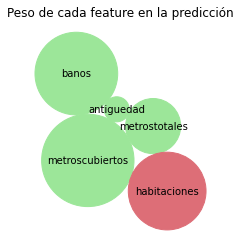

True
1479606.0470100841    0.30644443427599377    0.03881052345868326 %    0.08232388568740445


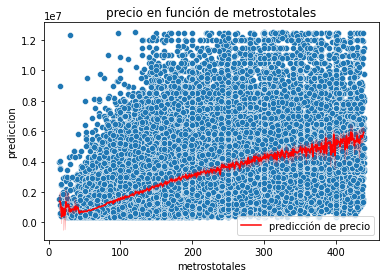

In [71]:
df = get_data()
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos","antiguedad"]
plot_prediction(df, columns, column_to_show='metrostotales', kfold_flag=True)

In [24]:
list(zip(df2.columns, linear_regressor.coef()))

[('metroscubiertos', array([10038.37234493])),
 ('metrostotales', array([2823.74695962])),
 ('habitaciones', array([-355666.59012985])),
 ('banos', array([478829.67201005])),
 ('antiguedad', array([14440.92932132]))]

In [22]:
pd.options.display.max_rows = 100
df2['metroscubiertosporhabitacion'] = df2['metroscubiertos'] / (df2['habitaciones']+df['banos'])
print(df2[df2['prediction'] < 0]['metroscubiertosporhabitacion'].min())
df2[df2['prediction'] < 0]



1.8181818181818181


metroscubiertos  metrostotales  habitaciones  banos  antiguedad  \
3464              120.0          200.0           9.0    2.0        19.0   
19278              65.0           65.0           4.0    1.0         5.0   
21680              90.0          100.0          10.0    1.0        10.0   
30951             110.0          110.0          10.0    1.0         5.0   
38060             160.0          160.0          10.0    2.0         5.0   
43392              66.0           50.0           4.0    1.0         1.0   
43713              65.0           65.0           4.0    1.0         5.0   
45474              16.0           16.0           3.0    1.0        10.0   
46312              56.0           56.0           4.0    1.0         5.0   
47645             109.0          109.0           7.0    2.0         0.0   
48116             111.0          140.0           8.0    1.0         2.0   
49044              61.0           70.0          10.0    1.0        13.0   
52867              50.0          120.0           7.0    2.0        10.0   
63292              66.0           66.0           4.0    1.0         6.0   
71279              70.0           76.0           4.0    1.0         1.0   
71395              50.0           50.0           4.0    1.0         1.0   
87350              41.0           53.0          10.0    1.0        10.0   
91943              44.0           75.0           9.0    1.0         5.0   
92358              66.0          106.0           6.0    1.0         0.0   
96328             117.0          217.0          10.0    3.0        10.0   
96912              88.0           60.0           5.0    1.0        10.0   
104680             16.0           23.0           5.0    2.0         0.0   
107972            147.0          125.0          10.0    2.0        10.0   
108253            160.0          160.0           8.0    1.0         0.0   
109783             20.0           18.0           4.0    2.0         0.0   
118776             39.0           52.0           3.0    1.0         0.0   
122529             86.0           96.0           5.0    1.0         5.0   
123457             48.0           62.0           4.0    1.0        10.0   
129136             65.0           65.0           5.0    1.0         5.0   
136868             30.0           30.0           7.0    4.0        10.0   
141784             80.0           20.0           4.0    1.0         1.0   
141920             47.0          211.0           7.0    1.0         0.0   
152432            147.0          147.0          10.0    1.0        20.0   
155535             90.0          120.0           5.0    1.0         0.0   
157430             60.0           68.0           4.0    1.0         5.0   
162038             47.0          211.0           7.0    1.0        48.0   
175930             82.0           77.0          10.0    2.0        10.0   
180622             66.0           50.0           4.0    1.0         1.0   
181713             97.0           96.0           7.0    1.0         5.0   
186118             87.0           50.0           6.0    1.0         8.0   
193383            100.0          300.0           7.0    1.0         8.0   
201028             70.0           75.0          10.0    1.0         5.0   
201778             51.0          100.0           4.0    1.0        10.0   
203471             20.0           20.0          10.0    1.0        10.0   
208874            100.0          145.0           9.0    1.0         0.0   
212190             53.0           53.0           4.0    1.0         5.0   
216045            120.0          120.0           7.0    1.0        25.0   
222942            198.0          198.0          10.0    1.0         4.0   
227987             92.0          100.0           7.0    1.0         5.0   
230185             95.0          105.0           5.0    1.0         3.0   

          prediction  metroscubiertosporhabitacion  
3464   -1.996082e+05                     10.909091  
19278  -3.559429e+04                     13.000000  
21680  -1.747599e+06   

In [ ]:
df2['habitaciones'].value_counts()

Primero hicimos la exprimentación con metros cubiertos, metros totales, habitaciones, baños y antiguedad para obtener un resultado general sin hacer una segmentación previa. En los resultados obtenidos, observamos que varios predicciones resultaron negativas entonces decidimos analizar esos resultados negativos. Los coeficientes obtenidos negativos fueron: 
 ('metroscubiertos', 10310.037575517254),
 ('metrostotales', 2615.496771363549),
 ('habitaciones', -420750.47429835715),
 ('banos', 457367.5660298784),
 ('antiguedad', 13674.213724549987)
Lo cual nos hizo pensar que la cantidad de habitaciones era mayor que en el promedio de las propiedades en venta por sobre la cantidad de metros totales/cubiertos. Para verificar esto calculamos metros cubiertos / (habitaciones + banos) pero los valores obtenidos no se diferenciaban de los que que si tenian un valor positivo(o al menos 11k tenian valores similares).
Seguimos analizando y notamos que los baños y habitaciones parecen tener coeficientes que se relacionan de forma inversa.

In [25]:
# cuantas propiedades cumplen cosas parecidas a las malas(las que la prediccion da negativa)
pd.options.display.max_rows = 100
df2['banosporhabitacion'] = df2['banos'] / df2['habitaciones']
# df2[df2['prediccion' < 0].max(banosporhabit) = 0.571429
df2[df2['banosporhabitacion'] < 0.571429]

metroscubiertos  metrostotales  habitaciones  banos  antiguedad  \
3                  63.0           67.0           2.0    1.0         1.0   
4                  95.0           95.0           2.0    1.0        10.0   
5                  75.0           90.0           2.0    1.0         5.0   
22                179.0          224.0           4.0    1.0         0.0   
26                 40.0           66.0           2.0    1.0         3.0   
...                 ...            ...           ...    ...         ...   
239981             50.0           65.0           2.0    1.0        10.0   
239984             62.0           65.0           2.0    1.0        20.0   
239987             83.0           90.0           3.0    1.0         0.0   
239990            118.0          124.0           3.0    1.0        20.0   
239991             68.0           68.0           2.0    1.0        20.0   

          prediction  metroscubiertosporhabitacion  banosporhabitacion  
3       6.035459e+05                     21.000000            0.500000  
4       1.133807e+06                     31.666667            0.500000  
5       8.467163e+05                     25.000000            0.500000  
22      1.485551e+06                     35.800000            0.250000  
26      3.987215e+05                     13.333333            0.500000  
...              ...                           ...                 ...  
239981  5.973680e+05                     16.666667            0.500000  
239984  8.622377e+05                     20.666667            0.500000  
239987  4.991520e+05                     20.750000            0.333333  
239990  1.235321e+06                     29.500000            0.333333  
239991  9.309392e+05                     22.666667            0.500000  

[43631 rows x 8 columns]

(array([   35.,   910., 15128., 25651., 21963., 18056., 15808., 10573.,
         8860.,  5583.,  4944.,  2408.,  1779.,  1185.,   590.,   112.,
           79.,    57.,    47.,    57.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200.]),
 <a list of 20 Patch objects>)

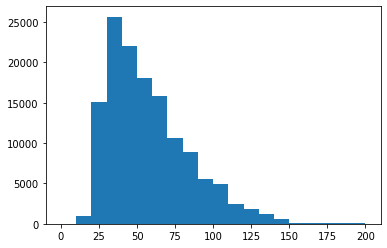

In [26]:
plt.hist(df2['metroscubiertos'] / df2['habitaciones'], range=[0,200], bins=20)

# exp para determinar si estan mal clasificados las lng y lat

In [27]:
print(len(df2))
print(len(df2[(df2['lat'] > 13) & (df2['lat'] < 34)]))

print(len(df2))
print(len(df2[(df2['lng'] >= -117) & (df2['lng'] <= -87)]))

133942


KeyError: 'lat'

In [28]:
print(len(df2[df2['lat'] < 0]))

KeyError: 'lat'

In [ ]:
df = pd.read_csv('../data/train.csv')
df2 = df.reindex(columns=["antiguedad", "habitaciones", "garages", "banos", "metroscubiertos", "metrostotales", "lat",
                          "lng", "gimnasio", "usosmultiples", "piscina", "escuelascercanas", "centroscomercialescercanos", "precio"]).dropna()
df2 = df2[(df2['lat'] > 13) & (df2['lat'] < 34) & (df2['lng'] >= -117) & (df2['lng'] <= -87)]
df2['lng'] = df2['lng'].abs()

y = df2['precio'].values
df2 = df2.drop(columns=['precio'])
X = df2.to_numpy()

print(K_Fold(X, y, 10))

##LATEX

En base a los resultados previos podemos preveer que para distintos tipos de propiedades(comerciales/residenciales/hoteleria) la relación entre los distintos $features$ puede ser muy distinta por lo que nos interesa separar estas categorias. Por ejemplo la cantidad de baños en relacion con la cantidad de habitaciones es diferente en un hostel que en una oficina que en una casa.

- mejorar la relacion para algun feature preexistente de forma no lineal(por ejemplo agregando nuevos features que sean funciones de los inciales baños ** 2)
- 

# Observaciones:
- Podemos elimnar las latitudes que esten fuera de las latitudes de mexico y lo mismo para lng
- Hacemos modulo de la latitud y longitud para poder usar rmsle (eliminamos aprox 1k de lng mal tageados)
El data set est

# Preguntas:
Como ir viendo los graficos si se experimenta con KFold y esto genera K distintos


In [29]:
df = get_data()
df.isna().sum()

id                                0
titulo                         1048
descripcion                     591
tipodepropiedad                  15
direccion                     23499
ciudad                          153
provincia                        37
antiguedad                    19069
habitaciones                  10920
garages                       17964
banos                          6921
metroscubiertos                8455
metrostotales                     0
idzona                        10698
lat                               0
lng                               0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
dtype: int64

Vemos que hay muchas columnas que nos interesan que tienen muchos valores en Null.
Nos llama la atención la dif de valores null entre metros cubiertos y totales, vamos a ver si observando en que tipos de propiedades están los valores null de metros totales podemos llegar a una conclusión de que esta pasando.

In [30]:
df = get_data()
df[df['metrostotales'].isna()]['tipodepropiedad'].value_counts()

Series([], Name: tipodepropiedad, dtype: int64)

## Decisión metros totales
Como hay muchos casos en donde no hay metros totales pero posiblemente si hay mtrs cubiertos (mayormente apartamentos en donde tien sentido que todos los metros cubiertos sean los totales), para los casos en donde metros totales es null decidimos completarlos con los metros cubiertos.
Opcional:podríamos realizar una segmentación entre propiedades en donde importan los metros cubiertos vs totales (por ejemplo los terrenos y metros cubiertos=nan)

In [31]:
df = get_data()
df[df['banos'].isna()]['tipodepropiedad'].value_counts()

Casa                             3491
Local Comercial                   933
Edificio                          557
Apartamento                       544
Oficina comercial                 389
Casa en condominio                360
Bodega comercial                  264
Casa uso de suelo                  89
Inmuebles productivos urbanos      72
Local en centro comercial          63
Otros                              56
Quinta Vacacional                  23
Villa                              20
Terreno industrial                 17
Nave industrial                    17
Rancho                             10
Huerta                              3
Duplex                              3
Departamento Compartido             2
Name: tipodepropiedad, dtype: int64

In [32]:
df = get_data()
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos","antiguedad"]
plot_prediction(df, columns, kfold_flag=True)

NameError: name 'plot_prediction' is not defined

# tamos trabados so segmentation time


- Division por tipo de propiedad entre comercial y residencial(y rural?) teniendo en cuenta tipo de mercado
- - Comercial: 
- - - Local Comercial
- - - Oficina comercial
- - - Bodega comercial 
- - - Terreno comercial
- - - Local en centro comercial
- - - Inmuebles productivos urbanos
- - - 
- - - Nave industrial                      
- - - Terreno industrial
- - - Hospedaje  
-------
------
- - Residencial
- - - Casa 
- - - Apartamento
- - - Casa en condominio
- - - Terreno
- - - Edificio
- - - Casa uso de suelo
- - - Quinta Vacacional
- - - Duplex
- - - Villa 
- - -
- - - Rancho
- - - Departamento Compartido
- - - 
- Por lapsos de años teniendo en cuenta el crecimiento/ fluctuacion del mercado inmobiliario / inflacion


# Segmentacion de df en comercial y residencial

In [ ]:
df = pd.read_csv('../data/train.csv')

dfComercial = df[df['tipodepropiedad'].isin(['Local Comercial', 'Oficina comercial', 'Bodega comercial', 'Terreno comercial', 'Local en centro comercial', 'Inmuebles productivos urbanos', 'Nave industrial','Terreno industrial', 'Hospedaje'])]
dfResidencial = df[df['tipodepropiedad'].isin(['Casa', 'Apartamento', 'Casa en condominio', 'Terreno', 'Edificio', 'Casa uso de suelo', 'Quinta Vacacional', 'Duplex', 'Villa'])]
dfResidencial

In [49]:
df = pd.read_csv('../data/train.csv')
df['ciudad'].value_counts().nlargest(100)

Querétaro                      12646
Benito Juárez                  11014
Zapopan                        10360
San Luis Potosí                 7925
Mérida                          7162
Monterrey                       6946
Alvaro Obregón                  6633
Cuauhtémoc                      6614
Naucalpan de Juárez             6554
Miguel Hidalgo                  5795
Atizapán de Zaragoza            5783
Tlalpan                         5721
Huixquilucan                    5718
Coyoacán                        5293
Puebla                          4636
Guadalajara                     4006
San Andrés Cholula              3805
Cancún                          3779
Cuernavaca                      3775
Chihuahua                       3757
Tlalnepantla de Baz             3588
Cuautitlán Izcalli              3408
Tlajomulco de Zúñiga            3254
Gustavo A. Madero               3141
Iztapalapa                      3093
Cuajimalpa de Morelos           3020
Tijuana                         2863
H

Size:  85028
        metroscubiertos  metrostotales  habitaciones  banos  antiguedad  \
955                70.0           70.0           5.0    1.0        10.0   
1694              120.0          200.0           9.0    2.0        19.0   
10725              90.0          100.0          10.0    1.0        10.0   
15251             110.0          110.0          10.0    1.0         5.0   
17516             105.0          105.0           6.0    1.0        24.0   
21015              91.0           91.0           5.0    1.0         0.0   
22342              16.0           16.0           3.0    1.0        10.0   
23617             111.0          140.0           8.0    1.0         2.0   
31438              63.0           63.0           4.0    1.0        10.0   
40639             100.0          100.0           6.0    1.0        20.0   
44944              44.0           75.0           9.0    1.0         5.0   
47045             117.0          217.0          10.0    3.0        10.0   
51077       

/home/bell/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


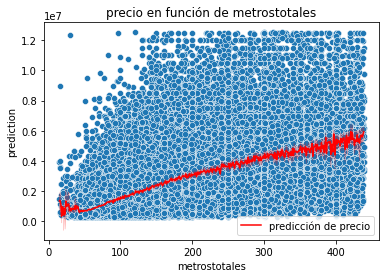

In [52]:
df = get_data()
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos","antiguedad"]
plot_prediction(df, columns, kfold_flag=True)

Size:  414
Empty DataFrame
Columns: [metroscubiertos, metrostotales, habitaciones, banos, antiguedad, prediccion]
Index: []
[('metroscubiertos', array([4680.40058967])), ('metrostotales', array([2067.89582469])), ('habitaciones', array([110182.2785288])), ('banos', array([460735.48340701])), ('antiguedad', array([8442.11763672]))]
False
1780433.0086265448    0.42641998284568894    0.0 %    0.0


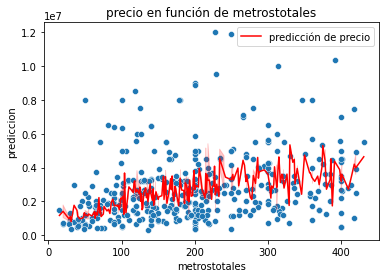

In [58]:
df = get_data()
dfComercial = df[df['tipodepropiedad'].isin(['Local Comercial', 'Oficina comercial', 'Bodega comercial', 'Terreno comercial', 'Local en centro comercial', 'Inmuebles productivos urbanos', 'Nave industrial','Terreno industrial', 'Hospedaje'])]
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos","antiguedad"]
plot_prediction(dfComercial, columns, kfold_flag=True)


Las métricas nos están dando feo, tal vez es porque estamos usando poca data ? => vamos a analizar de a una feature y ver que sucede

Size:  3435
[('metroscubiertos', array([12817.1778242]))]
False
2167009.952878393    0.6618820806334929


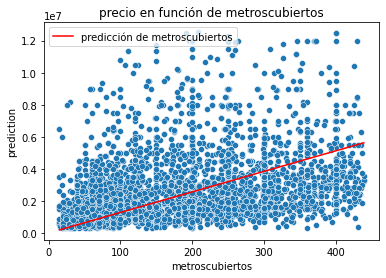

In [48]:
df = get_data()
dfComercial = df[df['tipodepropiedad'].isin(['Local Comercial', 'Oficina comercial', 'Bodega comercial', 'Terreno comercial', 'Local en centro comercial', 'Inmuebles productivos urbanos', 'Nave industrial','Terreno industrial', 'Hospedaje'])]
columns=["metroscubiertos"] #, "metrostotales", "habitaciones", "banos","antiguedad"]
plot_prediction(dfComercial, columns, column_to_show='metroscubiertos', kfold_flag=True)

Size:  104608
[('metroscubiertos', array([14361.09397577]))]
False
1625713.3998771629    0.3572406861677924


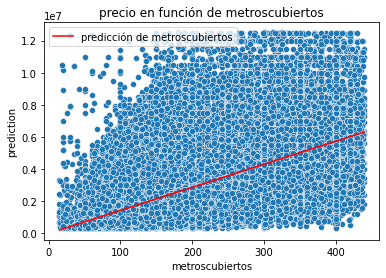

In [49]:
df = get_data()
columns=["metroscubiertos"]#, "metrostotales", "habitaciones", "banos","antiguedad"]
dfResidencial = df[df['tipodepropiedad'].isin(['Casa', 'Apartamento', 'Casa en condominio', 'Terreno', 'Edificio', 'Casa uso de suelo', 'Quinta Vacacional', 'Duplex', 'Villa'])]
plot_prediction(dfResidencial, columns, column_to_show='metroscubiertos', kfold_flag=True)

In [ ]:
y = df2['precio']
x = df2.drop(columns=['precio'])
x = x.values
y = y.values
x = x.reshape(len(x),5)
y = y.reshape(len(y),1)

rmse, rmsle = K_Fold(x, y, 10) # 10% de las muestras para testear
print(rmse, '  ', rmsle)

In [ ]:
df['tipodepropiedad'].value_counts()

In [ ]:
df[df['tipodepropiedad']=='Edificio']

In [ ]:
pd.to_datetime(df['fecha'])

df.groupby([pd.to_datetime(df['fecha']).dt.year]).count()


Vamos a realizar el mismo experimento que antes pero antes segmentando por casas para ver si cambia

In [ ]:
df = pd.read_csv('../data/train.csv')
df = df[df['tipodepropiedad'] == 'Villa']
df2 = df.reindex(columns=["metroscubiertos", "metrostotales", "habitaciones", "banos","antiguedad", "precio"]).dropna()
#df2 = df2[(df2['lat'] > 13) & (df2['lat'] < 34) & (df2['lng'] >= -117) & (df2['lng'] <= -87)]
#df2['lng'] = df2['lng'].abs()

y = df2['precio'].values
df2 = df2.drop(columns=['precio'])
X = df2.to_numpy()

#from sklearn.linear_model import LinearRegression


#linear_regressor = LinearRegression()
linear_regressor = metnum.LinearRegression()
linear_regressor.fit(X,y)

df2['prediction'] = linear_regressor.predict(X)

print((df2['prediction'] < 0).any())

sns.scatterplot(x=df2['metrostotales'], y=y)
sns.lineplot(data=df2, x='metrostotales', y='prediction', color='red')

#sns.scatterplot(x=df2['antiguedad'], y=y)
#sns.lineplot(data=df2, x='antiguedad', y='prediction', color='red')

# Poblacion

In [9]:
df = get_data()


In [78]:
df['poblacion'].isna().sum()

5341

In [80]:
len(df)

116962

In [26]:
df[df['poblacion'].isna()]['ciudad'].value_counts().nlargest(50)

Solidaridad                    131
Chalco                         118
Xochitepec                     115
Cajeme                         112
San Mateo Atenco               109
Atlatlahucan                   109
Tultepec                       104
Huehuetoca                      99
Valle de Bravo                  92
Medellín                        91
García                          90
Zumpango                        89
Calimaya                        85
Tizayuca                        84
Altamira                        82
Chapala                         81
Campeche                        77
Progreso                        76
Comalcalco                      71
Tepotzotlán                     68
Zinacantepec                    66
Santa María Huatulco            64
Apizaco                         64
Ahome                           60
Texcoco                         58
Conkal                          55
Carmen                          52
Atlixco                         51
Ocoyoacac           

# Tipos de ciudades por población
    - Mexico city > 8M
    - Grande: 400k - 
    - Media: 200k - 400k
    - Chica: 0 - 200k

In [10]:
dfMexicoCity = df[df['poblacion'] >= 8000000]
len(dfMexicoCity)

33571

In [11]:
dfMetropolis = df[df['poblacion'] < 8000000]
dfMetropolis = dfMetropolis[dfMetropolis['poblacion'] >= 1000000]
len(dfMetropolis)

17026

In [12]:
dfBigCity = df[df['poblacion'] < 1000000]
dfBigCity = dfBigCity[dfBigCity['poblacion'] >= 650000]
len(dfBigCity)

27580

In [13]:
dfMediumCity = df[df['poblacion'] < 650000]
dfMediumCity = dfMediumCity[dfMediumCity['poblacion'] >= 250000]
len(dfMediumCity)

18004

In [14]:
dfSmallCity = df[df['poblacion'] < 250000]
len(dfSmallCity)

15440

In [15]:
dfMexicoCity.mean()

id                            1.502649e+05
antiguedad                    1.280150e+01
habitaciones                  2.754658e+00
garages                       1.442283e+00
banos                         1.927618e+00
metroscubiertos               1.555182e+02
metrostotales                 1.507699e+02
idzona                        6.266415e+06
lat                           1.938461e+01
lng                          -9.914934e+01
fecha                         1.175468e+03
gimnasio                      7.953293e-02
usosmultiples                 7.866909e-02
piscina                       4.605165e-02
escuelascercanas              5.423133e-01
centroscomercialescercanos    5.099044e-01
precio                        3.419067e+06
poblacion                     9.209944e+06
dtype: float64

Size:  26452
[('metroscubiertos', 9404.663850874591, 1439708.5498420068), ('metrostotales', 7835.477117481851, 1114875.6544183434), ('habitaciones', -540032.0398185073, -1464590.9006706446), ('banos', 729944.3978049872, 1436432.998765341), ('antiguedad', -18448.29388777482, -231863.92110418697), ('poblacion', 0.09833301030551808, 905641.5182652444)]
              name         value
0  metroscubiertos  1.439709e+06
1    metrostotales  1.114876e+06
2     habitaciones -1.464591e+06
3            banos  1.436433e+06
4       antiguedad -2.318639e+05
5        poblacion  9.056415e+05


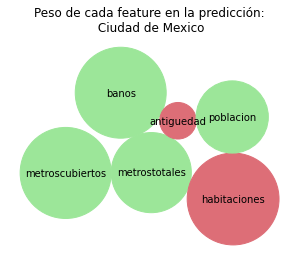

True
1631173.956466001    0.24918054189238908    0.0378057545219306 %    0.07561436672967864


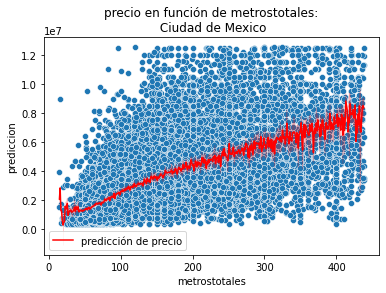

In [16]:
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos", "antiguedad", "poblacion"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, title=':\n Ciudad de Mexico')

Size:  12106
[('metroscubiertos', 6665.462859625102, 1131765.421140362), ('metrostotales', 7238.2190744488435, 1125152.6351288673), ('habitaciones', -213708.64749123456, -642608.804392526), ('banos', 420839.7636022209, 890069.4950661873), ('antiguedad', -18047.746310137853, -152678.32833802642), ('poblacion', -0.20589429156232533, -283305.34368019697)]
              name         value
0  metroscubiertos  1.131765e+06
1    metrostotales  1.125153e+06
2     habitaciones -6.426088e+05
3            banos  8.900695e+05
4       antiguedad -1.526783e+05
5        poblacion -2.833053e+05


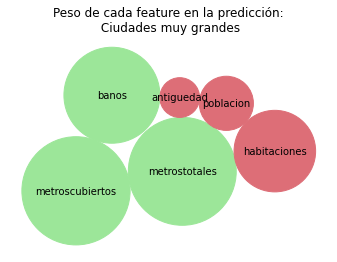

True
991598.9059658259    0.26915721310024476    0.6360292361343334 %    1.0734929810074318


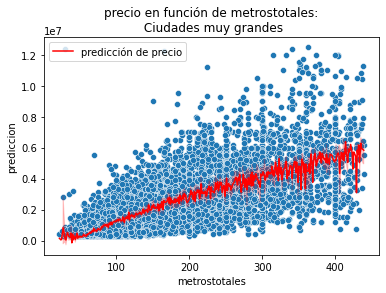

In [17]:
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos", "antiguedad", "poblacion"]
plot_prediction(dfMetropolis, columns, kfold_flag=True, title=':\n Ciudades muy grandes')

Size:  18576
[('metroscubiertos', 8718.851388317418, 1627817.9088260536), ('metrostotales', 3145.6787431759262, 588671.543135582), ('habitaciones', -63209.58514565482, -188291.47254709352), ('banos', 337942.54223522975, 755677.0736093333), ('antiguedad', 8715.027570792377, 63920.992756123436), ('poblacion', -0.9035198689634538, -715616.0000093061)]
              name         value
0  metroscubiertos  1.627818e+06
1    metrostotales  5.886715e+05
2     habitaciones -1.882915e+05
3            banos  7.556771e+05
4       antiguedad  6.392099e+04
5        poblacion -7.156160e+05


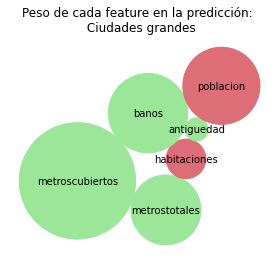

True
1017434.3764751151    0.19851985695467306    0.05382710982736024 %    0.16146393972012918


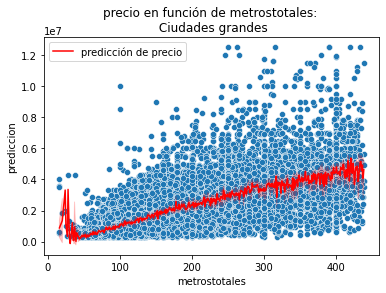

In [18]:
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos", "antiguedad", "poblacion"]
#dfBigCity['espaciopersonal'] = dfBigCity['metroscubiertos'] / dfBigCity['habitaciones']
plot_prediction(dfBigCity, columns, kfold_flag=True, title=': \n Ciudades grandes')

Size:  13378
[('metroscubiertos', 8318.044457094922, 1269152.7733193673), ('metrostotales', 4199.599860120609, 662780.5485626061), ('habitaciones', -292945.1759197104, -839113.4056842057), ('banos', 315056.5492749989, 602676.9436759229), ('antiguedad', -279.2137642321956, -2301.8125591176677), ('poblacion', -0.039358551025399535, -17284.801065100924)]
              name         value
0  metroscubiertos  1.269153e+06
1    metrostotales  6.627805e+05
2     habitaciones -8.391134e+05
3            banos  6.026769e+05
4       antiguedad -2.301813e+03
5        poblacion -1.728480e+04


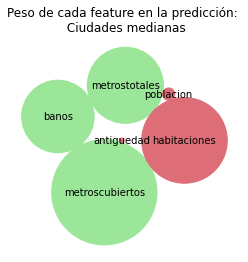

True
857061.8450893816    0.21444159558839404    0.05232807089919762 %    0.14958863126402394


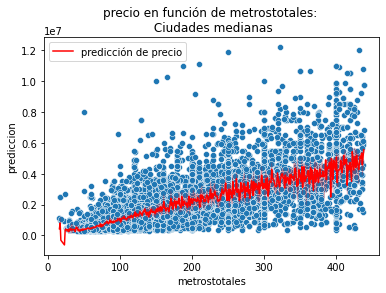

In [19]:
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos", "antiguedad", "poblacion"]
plot_prediction(dfMediumCity, columns, kfold_flag=True, title=': \n Ciudades medianas')

Size:  10848
[('metroscubiertos', 13025.094165758635, 2304790.892907324), ('metrostotales', 3984.5708446141257, 700794.4781002135), ('habitaciones', -796003.3204090407, -2273760.590847616), ('banos', 466798.34116993553, 1035106.3879832964), ('antiguedad', -9927.265720266836, -55171.9139942079), ('poblacion', 5.1878590632248205, 826937.0035820171)]
              name         value
0  metroscubiertos  2.304791e+06
1    metrostotales  7.007945e+05
2     habitaciones -2.273761e+06
3            banos  1.035106e+06
4       antiguedad -5.517191e+04
5        poblacion  8.269370e+05


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


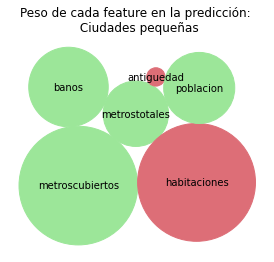

True
1371840.2369713536    0.3199100120007309    1.613175302259935 %    2.2119815668202767


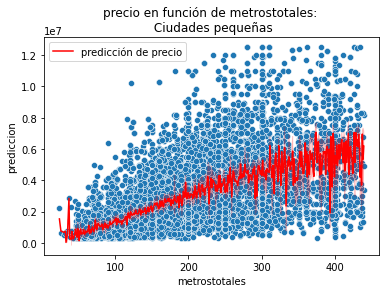

In [20]:
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos", "antiguedad", "poblacion"]
dfSmallCity['isVerySmall'] = dfSmallCity['poblacion'] < 150000
plot_prediction(dfSmallCity, columns, kfold_flag=True, title= ': \n Ciudades pequeñas')

In [21]:
df1 = dfSmallCity[df['precio'] > 1000000]
dfSmallCity['ciudad'].value_counts()

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Huixquilucan                  2363
San Andrés Cholula            1569
Toluca                        1012
Corregidora                    988
San Pedro Garza García         888
Guadalupe                      688
Boca del Río                   614
Puerto Vallarta                544
Veracruz                       543
San Pedro Cholula              441
Tequisquiapan                  440
Alvarado                       407
El Marqués                     381
Bahía de Banderas              363
Temixco                        257
Yautepec                       255
Jiutepec                       245
Emiliano Zapata                244
Cuautitlán                     241
Ciudad Madero                  238
San Juan del Río               222
Mineral de la Reforma          220
Colima                         192
Cuautlancingo                  189
Villa de Alvarez               189
Lerma                          183
Santiago                       163
Manzanillo                     163
San Miguel de Allend

# Refinando resultados obtenidos por cantidad de poblacion para mejorar el error

In [22]:
def add_function_features(df, columns, function, suffix):
    for column in columns:
        df[column+suffix] = df[column].apply(function)

In [23]:
def cuadratic(x):
    return x ** 2

In [24]:
def cubic(x):
    return x ** 3

In [25]:
def forth(x):
    return x ** 4

In [26]:
def sen(x):
    return np.sin(x)

In [27]:
def log(x):
    return np.log(x + 1)

In [28]:
def inversa(x):
    return 1/(x+1)

In [29]:
def squared(x):
    return np.sqrt(x)

--------------------------------------------------------------
## dfMexicoCity 

Decidimos empezar con mexico City porque tenia mas data y ademas nos parece que siendo la ciudad principal, es una de las predicciones que mas nos interesa mejorar.
Vamos a dedicarle especial atención a añadir nuesvos features y usarlo como caso base para analizar que features muestran utilidad para el resto de los casos.
Y luego analizaremos en el resto de los casos si efectivamente estos metodos son buenos en el caso gral o no.

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
posx and posy should be finite values
posx and posy should be finite values


Size:  33571
[('metrostotales', 21112.5766619661, 3183140.875286252)]
            name         value
0  metrostotales  3.183141e+06


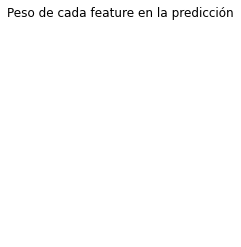

False
2022092.601962256    0.31532764796504986    0.0 %    0.0


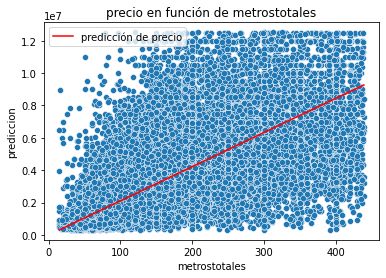

In [30]:
columns=["metrostotales"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True)

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
posx and posy should be finite values
posx and posy should be finite values


Size:  33571
[('metrostotales', 21112.5766619661, 3183140.875286252)]
            name         value
0  metrostotales  3.183141e+06


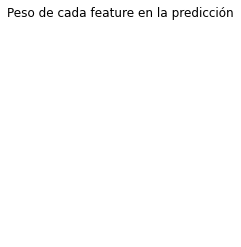

False
2022092.601962256    0.31532764796504986    0.0 %    0.0


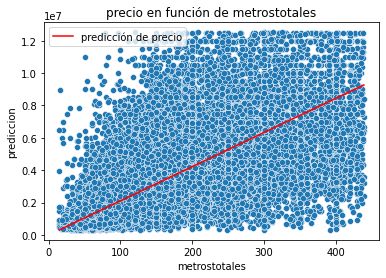

In [69]:
# dfMexicoCity['unos'] = np.ones(len(dfMexicoCity))
add_function_features(dfMexicoCity, ['metrostotales'], cuadratic, '_2')
columns=["metrostotales"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True)

Size:  33571
[('metrostotales', 29035.018046472953, 4377606.496742744), ('metrostotales_2', -26.124279695123036, -820170.3984352644), ('metrostotales_3', -0.013535884112646092, -111395.19574339374)]
              name         value
0    metrostotales  4.377606e+06
1  metrostotales_2 -8.201704e+05
2  metrostotales_3 -1.113952e+05


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


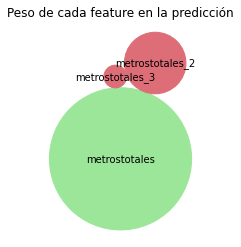

False
1929688.5293424323    0.33811936964327016    0.0 %    0.0


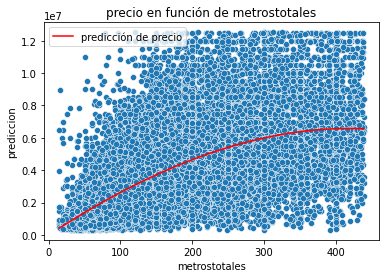

In [32]:
add_function_features(dfMexicoCity, ['metrostotales'], cubic, '_3')
columns=["metrostotales", "metrostotales_2", "metrostotales_3"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True)

Size:  33571
[('metrostotales', 21133.19136544099, 3186248.9518755507), ('metrostotales_sen', 49603.95168542041, -2128.2179439296797)]
                name         value
0      metrostotales  3.186249e+06
1  metrostotales_sen -2.128218e+03


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


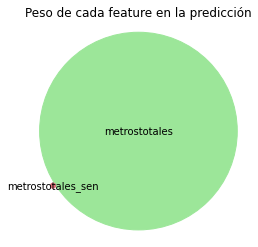

False
2021870.560736645    0.3153900753305125    0.0 %    0.0


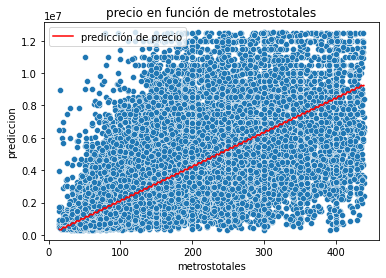

In [33]:
add_function_features(dfMexicoCity, ['metrostotales'], sen, '_sen')
columns=["metrostotales", "metrostotales_sen"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True)

Size:  33571
[('metrostotales', 0.0, 0.0), ('metrostotales_2', 395.3657112942718, 12412485.884554354), ('metrostotales_3', -1.7914008508976054, -14742550.008549882), ('metrostotales_4', 0.002264932606173639, 5644260.717354165)]
              name         value
0    metrostotales  0.000000e+00
1  metrostotales_2  1.241249e+07
2  metrostotales_3 -1.474255e+07
3  metrostotales_4  5.644261e+06


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


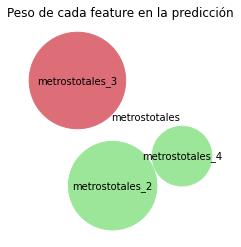

False
1946422.9495204575    0.3220844585843009    0.0 %    0.0


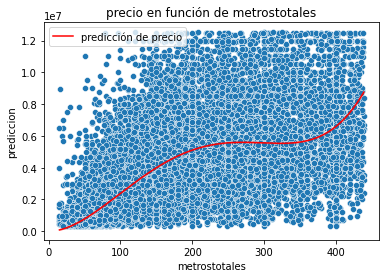

In [34]:
add_function_features(dfMexicoCity, ['metrostotales'], forth, '_4')
columns=["metrostotales", "metrostotales_2", "metrostotales_3", "metrostotales_4"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True)

## metroscubiertos

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
posx and posy should be finite values
posx and posy should be finite values


Size:  31844
[('metroscubiertos', 19839.973499415035, 3085477.240314347)]
              name         value
0  metroscubiertos  3.085477e+06


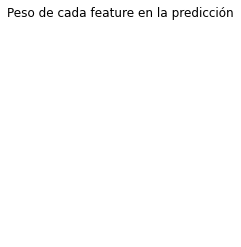

False
1961247.6137634374    0.30267756315149813    0.0 %    0.0


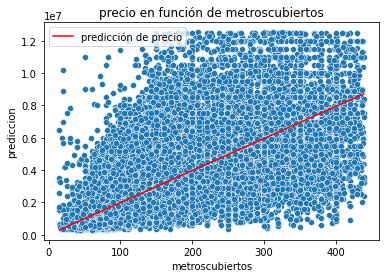

In [35]:
columns=["metroscubiertos"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, column_to_show='metroscubiertos')

Size:  31844
[('metroscubiertos', 28396.1630543556, 4416120.5567665), ('metroscubiertos_2', -31.79532478068023, -1071300.232674392)]
                name         value
0    metroscubiertos  4.416121e+06
1  metroscubiertos_2 -1.071300e+06


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


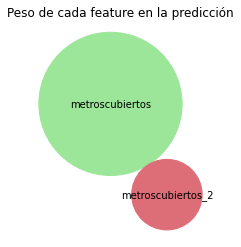

False
1874948.659427331    0.32042424920459806    0.0 %    0.0


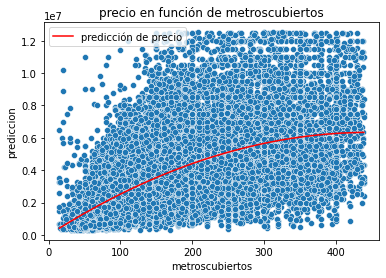

In [36]:
add_function_features(dfMexicoCity, ['metroscubiertos'], cuadratic, '_2')
columns=["metroscubiertos", "metroscubiertos_2"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, column_to_show='metroscubiertos')

Size:  31844
[('metroscubiertos', 30910.591384489613, 4807159.959377539), ('metroscubiertos_2', -36.762105105829285, -1238649.141819925), ('metroscubiertos_log', -48734.185124897966, -237052.3287276923)]
                  name         value
0      metroscubiertos  4.807160e+06
1    metroscubiertos_2 -1.238649e+06
2  metroscubiertos_log -2.370523e+05


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


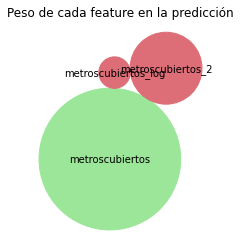

False
1874421.4444949962    0.31401411322575107    0.0 %    0.0


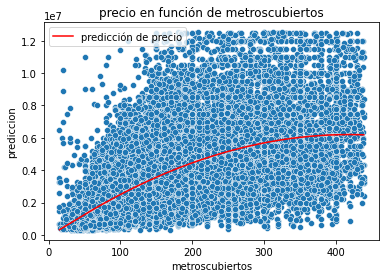

In [37]:
add_function_features(dfMexicoCity, ['metroscubiertos'], log, '_log')
columns=["metroscubiertos", "metroscubiertos_2", "metroscubiertos_log"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, column_to_show='metroscubiertos')

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Size:  26452
[('metrostotales', 16325.224666923383, 2322844.5774482666), ('metrostotales_2', -19.982022737243742, -554891.580377774), ('banos', 625534.1541195319, 1230967.5963457625), ('habitaciones', -603423.0688578719, -1636510.1896565428), ('antiguedad', -18607.55926548038, -233865.6181280739), ('poblacion', 0.023602208622049578, 217375.01968539378), ('metroscubiertos', 14989.23265488412, 2294619.643082811), ('metroscubiertos_2', -13.569011616063626, -440335.54888373794), ('metroscubiertos_log', 0.0, 0.0)]
                  name         value
0        metrostotales  2.322845e+06
1      metrostotales_2 -5.548916e+05
2                banos  1.230968e+06
3         habitaciones -1.636510e+06
4           antiguedad -2.338656e+05
5            poblacion  2.173750e+05
6      metroscubiertos  2.294620e+06
7    metroscubiertos_2 -4.403355e+05
8  metroscubiertos_log  0.000000e+00


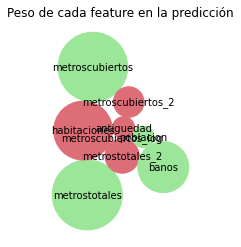

True
1609400.5102819698    0.2404430324025831    0.07939079853743639 %    0.1890359168241966


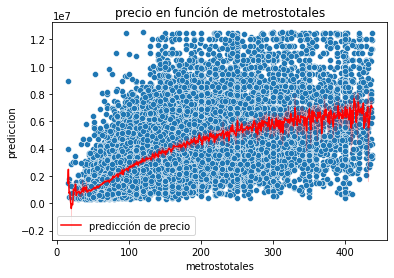

In [38]:
add_function_features(dfMexicoCity, ['metrostotales'], cuadratic, '_2')
add_function_features(dfMexicoCity, ['metroscubiertos'], cuadratic, '_2')
add_function_features(dfMexicoCity, ['metroscubiertos'], log, '_log')
columns=["metrostotales", "metrostotales_2", "banos", "habitaciones", "antiguedad", "poblacion", "metroscubiertos", "metroscubiertos_2", "metroscubiertos_log"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True)

Size:  26452
[('metrostotales', 21094.1100070743, 3001388.3450746946), ('metrostotales_2', -30.301084688310247, -841447.1843492901), ('metroscubiertos', 8707.574387269571, 1332994.9366102489), ('habitaciones', -591212.2105171053, -1603393.798967436), ('banos', 643211.6004770328, 1265754.4477253691), ('antiguedad', -18453.625703443086, -231930.9330292446), ('poblacion', 0.030058606920059655, 276838.0864517619)]
              name         value
0    metrostotales  3.001388e+06
1  metrostotales_2 -8.414472e+05
2  metroscubiertos  1.332995e+06
3     habitaciones -1.603394e+06
4            banos  1.265754e+06
5       antiguedad -2.319309e+05
6        poblacion  2.768381e+05


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


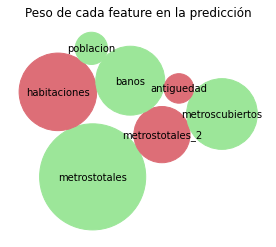

True
1611354.4076583216    0.24017377961632333    0.07939079853743639 %    0.11342155009451796


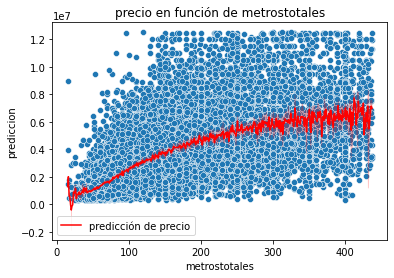

In [39]:
add_function_features(dfMexicoCity, ['metrostotales'], cuadratic, '_2')
columns=["metrostotales", "metrostotales_2","metroscubiertos", "habitaciones", "banos", "antiguedad", "poblacion"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True)

Size:  26452
[('metrostotales', 32194.22956798259, 4580775.646452791), ('metrostotales_2', -91.50177100362583, -2540962.0931384577), ('metrostotales_3', 0.0954051640836236, 657389.1931195293), ('metroscubiertos', 8679.255941133846, 1328659.8205799134), ('habitaciones', -597415.0434564009, -1620216.1576636452), ('banos', 629828.5652085822, 1239418.4233089194), ('antiguedad', -18221.02081249479, -229007.4820905633), ('poblacion', -0.0234369992968885, -215853.45105238247)]
              name         value
0    metrostotales  4.580776e+06
1  metrostotales_2 -2.540962e+06
2  metrostotales_3  6.573892e+05
3  metroscubiertos  1.328660e+06
4     habitaciones -1.620216e+06
5            banos  1.239418e+06
6       antiguedad -2.290075e+05
7        poblacion -2.158535e+05


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


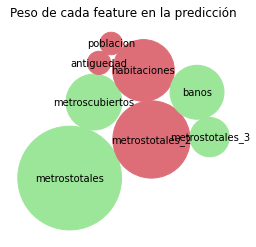

True
1609148.191440496    0.24392109241795432    0.09829439021985606 %    0.2646502835538752


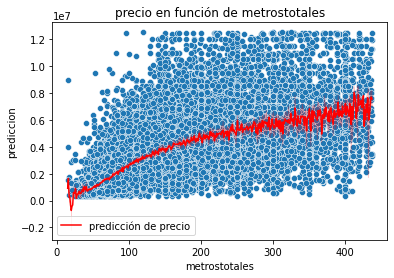

In [40]:
add_function_features(dfMexicoCity, ['metrostotales'], cubic, '_3')
columns=["metrostotales", "metrostotales_2", "metrostotales_3","metroscubiertos", "habitaciones", "banos", "antiguedad", "poblacion"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True)

El cuadrado mejora 0.006 en comparación al lineal cuando lo complementamos con el resto de las columnas.
Notar que si solo consideramos la columna sola, empeoraba las métricas (cuadrado vs lineal) por lo que evaluar si agregar un feature conviene o no debería hacerse con todas las columnas que planea ponerse en conjunción.
Por otro lado, el cúbico pierde contra el cuadrático y gana contra el linear.Notar que el coeficiente de metrostotales_3 es mínimo por lo que su influencia en la predicción esta haciendo más ruido que otra cosa.

Size:  26452
[('metroscubiertos', 14990.6984747992, 2294844.037436265), ('metroscubiertos_2', -13.570597128069048, -440387.0012163708), ('metrostotales', 16325.915416309952, 2322942.8611472477), ('metrostotales_2', -19.983324064956847, -554927.7176498014), ('habitaciones', -603455.3803228016, -1636597.8197859318), ('banos', 625403.3814886059, 1230710.2532892744), ('antiguedad', -18608.591315577836, -233878.5892561266), ('poblacion', 0.02361554810230625, 217497.87555154684)]
                name         value
0    metroscubiertos  2.294844e+06
1  metroscubiertos_2 -4.403870e+05
2      metrostotales  2.322943e+06
3    metrostotales_2 -5.549277e+05
4       habitaciones -1.636598e+06
5              banos  1.230710e+06
6         antiguedad -2.338786e+05
7          poblacion  2.174979e+05


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


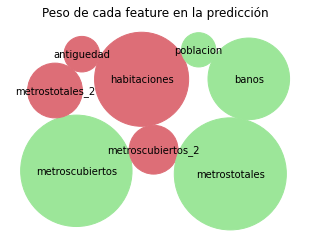

True
1609400.417911374    0.2404510116191847    0.07939079853743639 %    0.1890359168241966


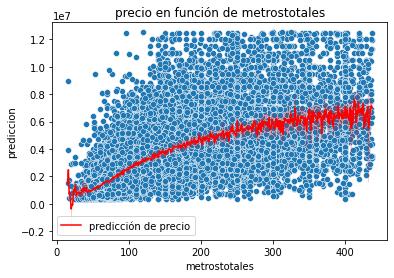

In [41]:
add_function_features(dfMexicoCity, ['metroscubiertos'], cuadratic, '_2')
add_function_features(dfMexicoCity, ['metrostotales'], cuadratic, '_2')
columns=["metroscubiertos", "metroscubiertos_2", "metrostotales", "metrostotales_2", "habitaciones", "banos", "antiguedad", "poblacion"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, column_to_show='metrostotales')

Size:  26452
[('metroscubiertos', 8727.648722255713, 1336068.0067561057), ('metroscubiertos_sen', 24907.886295523273, -1020.6659183697424), ('metrostotales', 21095.829206725255, 3001632.9624486202), ('metrostotales_2', -30.297500559199477, -841347.6547324588), ('habitaciones', -591342.9315285174, -1603748.3201619654), ('banos', 642707.8173394917, 1264763.0698544495), ('antiguedad', -18441.853188259094, -231782.97238050256), ('poblacion', 0.029928463587859534, 275639.4736502254)]
                  name         value
0      metroscubiertos  1.336068e+06
1  metroscubiertos_sen -1.020666e+03
2        metrostotales  3.001633e+06
3      metrostotales_2 -8.413477e+05
4         habitaciones -1.603748e+06
5                banos  1.264763e+06
6           antiguedad -2.317830e+05
7            poblacion  2.756395e+05


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


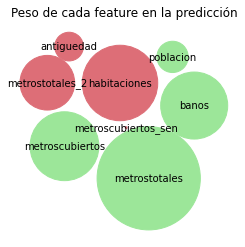

True
1611283.784641666    0.24176455206576866    0.07561008020095247 %    0.11342155009451796


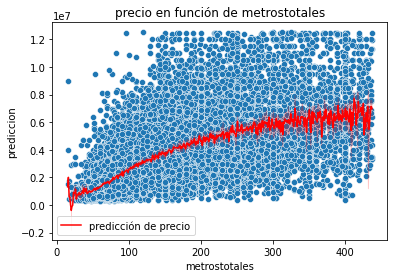

In [42]:
add_function_features(dfMexicoCity, ['metroscubiertos'], sen, '_sen')
add_function_features(dfMexicoCity, ['metrostotales'], cuadratic, '_2')
columns=["metroscubiertos", "metroscubiertos_sen", "metrostotales", "metrostotales_2", "habitaciones", "banos", "antiguedad", "poblacion"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, column_to_show='metrostotales')

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0         3.0
2         2.0
8         NaN
20        3.0
21        3.0
         ... 
116942    3.0
116943    5.0
116947    3.0
116957    2.0
116961    4.0
Name: habitaciones, Length: 33571, dtype: float64
0         1.386294
2         1.098612
8              NaN
20        1.386294
21        1.386294
            ...   
116942    1.386294
116943    1.791759
116947    1.386294
116957    1.098612
116961    1.609438
Name: habitaciones_log, Length: 33571, dtype: float64
Size:  26452
[('habitaciones', -605124.6756984432, -1641125.0230580152), ('habitaciones_log', 0.0, 0.0), ('metroscubiertos', 15006.086401269833, 2297199.6909349333), ('metroscubiertos_2', -13.590485767673783, -441032.418530815), ('metrostotales', 16326.378227523552, 2323008.7125238646), ('metrostotales_2', -19.98728891711505, -555037.8197705406), ('banos', 625761.1507436858, 1231414.2953580758), ('antiguedad', -18586.174444282577, -233596.84701432227), ('poblacion', 0.02381917947306987, 219373.30907292303)]
                name

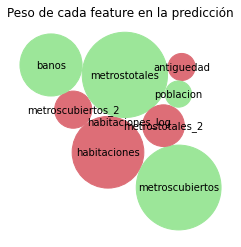

True
1609394.8148754244    0.24064240177584223    0.07939079853743639 %    0.1890359168241966


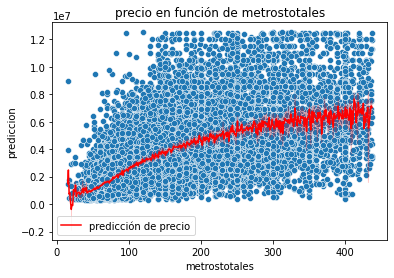

In [43]:
add_function_features(dfMexicoCity, ['metroscubiertos'], cuadratic, '_2')
add_function_features(dfMexicoCity, ['metrostotales'], cuadratic, '_2')
add_function_features(dfMexicoCity, ['habitaciones'], log, '_log')
print(dfMexicoCity["habitaciones"])
print(dfMexicoCity["habitaciones_log"])
columns=["habitaciones", "habitaciones_log", "metroscubiertos", "metroscubiertos_2", "metrostotales", "metrostotales_2", "banos", "antiguedad", "poblacion"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, column_to_show='metrostotales')

Size:  26452
[('habitaciones', -465506.878891759, -1262475.351006196), ('habitaciones_sen', 331089.49223925185, 119441.5380254509), ('metroscubiertos', 16041.142943427978, 2455650.8357014107), ('metroscubiertos_2', -15.23646865597989, -494447.12544413767), ('metrostotales', 16194.067715216224, 2304182.830349319), ('metrostotales_2', -19.685568287665042, -546659.1766717095), ('banos', 630013.3223919354, 1239782.0007481403), ('antiguedad', -17963.88546936715, -225775.72476521225), ('poblacion', -0.0422908030082394, -389495.9274209164)]
                name         value
0       habitaciones -1.262475e+06
1   habitaciones_sen  1.194415e+05
2    metroscubiertos  2.455651e+06
3  metroscubiertos_2 -4.944471e+05
4      metrostotales  2.304183e+06
5    metrostotales_2 -5.466592e+05
6              banos  1.239782e+06
7         antiguedad -2.257757e+05
8          poblacion -3.894959e+05


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


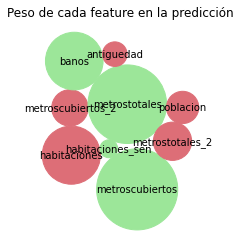

True
1607066.2246771497    0.2447468278176676    0.09451224304046339 %    0.1890359168241966


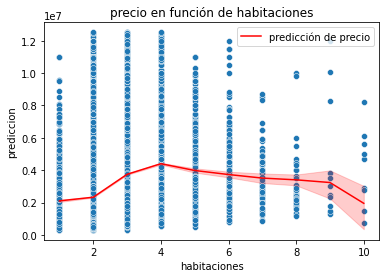

In [44]:
add_function_features(dfMexicoCity, ['metroscubiertos'], cuadratic, '_2')
add_function_features(dfMexicoCity, ['metrostotales'], cuadratic, '_2')
add_function_features(dfMexicoCity, ['habitaciones'], sen, '_sen')
columns=["habitaciones", "habitaciones_sen", "metroscubiertos", "metroscubiertos_2", "metrostotales", "metrostotales_2", "banos", "antiguedad", "poblacion"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, column_to_show='habitaciones')

# Espacio por persona:
Vamos a ver si lo de habitaciones no nos está mejorando porque le falta algo que represente la relación de espacio entre metros cubiertos y totales

Size:  26452
[('espacioporpersona', 10486.461333714406, 581732.3172187441), ('metroscubiertos', 9801.84932897324, 1500511.5022663544), ('metroscubiertos_2', -9.848693317906571, -319605.42894620047), ('metrostotales', 16000.05374511259, 2276577.433939827), ('metrostotales_2', -19.481053982943767, -540979.908499067), ('banos', 640522.3476958488, 1260462.3577408027), ('antiguedad', -18484.399084996778, -232317.70250267556), ('unos', -242156.1619696135, -242156.1619696135), ('habitaciones', -399706.02494365146, -1084020.509732066)]
                name         value
0  espacioporpersona  5.817323e+05
1    metroscubiertos  1.500512e+06
2  metroscubiertos_2 -3.196054e+05
3      metrostotales  2.276577e+06
4    metrostotales_2 -5.409799e+05
5              banos  1.260462e+06
6         antiguedad -2.323177e+05
7               unos -2.421562e+05
8       habitaciones -1.084021e+06


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


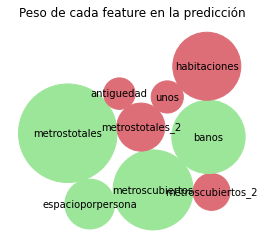

True
1607686.905701975    0.23427300435039192    0.05670791736144154 %    0.1890359168241966


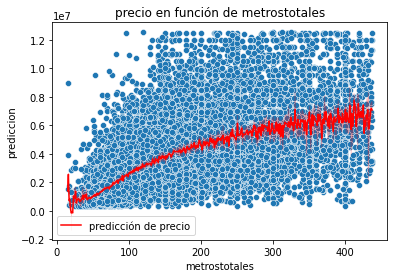

In [47]:
add_function_features(dfMexicoCity, ['metroscubiertos'], cuadratic, '_2')
add_function_features(dfMexicoCity, ['metrostotales'], cuadratic, '_2')
dfMexicoCity['espacioporpersona'] = dfMexicoCity['metroscubiertos'] / dfMexicoCity['habitaciones']
dfMexicoCity['unos'] = np.ones(len(dfMexicoCity['metroscubiertos']))
columns=["espacioporpersona", "metroscubiertos", "metroscubiertos_2", "metrostotales", "metrostotales_2", "banos", "antiguedad", "unos", "habitaciones"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, column_to_show='metrostotales')

Size:  26452
[('espacioporpersona', 25174.662960498557, 1396554.524272903), ('metroscubiertos', 1496.964093748736, 229162.04542240218), ('metroscubiertos_2', -3.294322198830903, -106905.88339572147), ('metrostotales', 15516.93512794488, 2207836.6059850343), ('metrostotales_2', -18.514379086076385, -514135.79124989134), ('banos', 635614.5984941056, 1250804.5633605085), ('antiguedad', -19862.610828399214, -249639.49826769688), ('unos', -1013472.666611431, -1013472.666611431)]
                name         value
0  espacioporpersona  1.396555e+06
1    metroscubiertos  2.291620e+05
2  metroscubiertos_2 -1.069059e+05
3      metrostotales  2.207837e+06
4    metrostotales_2 -5.141358e+05
5              banos  1.250805e+06
6         antiguedad -2.496395e+05
7               unos -1.013473e+06


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


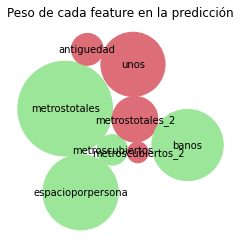

True
1614412.8181092471    0.23130163235270781    0.049146480688473666 %    0.15122873345935728


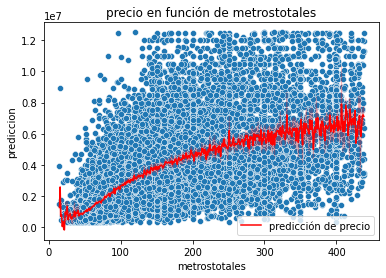

In [48]:
add_function_features(dfMexicoCity, ['metroscubiertos'], cuadratic, '_2')
add_function_features(dfMexicoCity, ['metrostotales'], cuadratic, '_2')
dfMexicoCity['espacioporpersona'] = dfMexicoCity['metroscubiertos'] / dfMexicoCity['habitaciones']
dfMexicoCity['unos'] = np.ones(len(dfMexicoCity['metroscubiertos']))
columns=["espacioporpersona", "metroscubiertos", "metroscubiertos_2", "metrostotales", "metrostotales_2", "banos", "antiguedad", "unos"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, column_to_show='metrostotales')

Size:  26452
[('espacioporpersona', 25236.006784212557, 1399957.5487613901), ('metroscubiertos', -33.32265481130681, -5101.182965812314), ('metrostotales', 16683.123362488655, 2373768.412264089), ('metrostotales_2', -21.046573264296, -584453.6588577977), ('banos', 641017.7348000115, 1261437.2133403826), ('antiguedad', -19767.081014640764, -248438.8497234396), ('unos', -996965.5833027038, -996965.5833027038)]
                name         value
0  espacioporpersona  1.399958e+06
1    metroscubiertos -5.101183e+03
2      metrostotales  2.373768e+06
3    metrostotales_2 -5.844537e+05
4              banos  1.261437e+06
5         antiguedad -2.484388e+05
6               unos -9.969656e+05


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


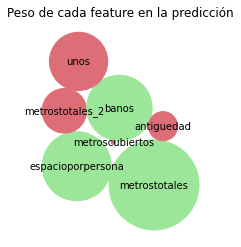

True
1614361.48690123    0.23103061073433642    0.04536719119489845 %    0.15122873345935728


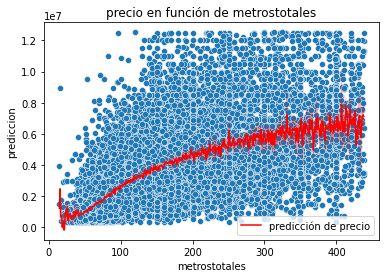

In [49]:
add_function_features(dfMexicoCity, ['metrostotales'], cuadratic, '_2')
dfMexicoCity['espacioporpersona'] = dfMexicoCity['metroscubiertos'] / dfMexicoCity['habitaciones']
dfMexicoCity['unos'] = np.ones(len(dfMexicoCity['metroscubiertos']))
columns=["espacioporpersona", "metroscubiertos", "metrostotales", "metrostotales_2", "banos", "antiguedad", "unos"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, column_to_show='metrostotales')

Como vimos que habitaciones le esta dando un valor negativo y creíamos que era porque al los metros totales y cubiertos representar el espacio disponible, + habitaciones suponian un menor espacio disponible por persona.
Para probar esto entonces agregamos una columna(feature) 'espacioporpersona', obtenida a partir de dividr m,etros cubiertos poer habitaciones que busca representar cuanto espacio hay disponible por persona, lo cual nos parecia que condensaria mejor la información que 'habitaciones'.
además en este caso la relacion deberia ser positiva ya que a mayor espacio por persona, mejor deberia se la propiedad y por tanto tener un mejor precio. (a diferencia de lo que estaba suciediendo por habitaciones, en donde a mayor habitaciones se le estaba dando mayor precio).
Lo que querríamos es que para muchas habitaciones y pocos metros cubiertos el valor asignado a habitaciones fuese negativo pero que si tenes muchos metros cubiertos y muchas habitaciones no necesariamente fuese asi, ya que tal vez el espacio asignado a cada persona fuese razonable.
Entonces, asignarle un coeficiente linear a habitaciones y metros cubiertos por separado resultaba en un valor negativo en habitaciones que puede no resultar bien para casos mas normales.
Entonces, cuando agregamos espacioporpersona, vimos que la métrica empeoraba, enteonces probamos sacando habitaciones ya que creiamos que podria estar haciendo ruido y que realmente toda la informacion que creemos que habitaciones debería condensar, espacio por persona ya lo deberia estar transmitiendo.
Al hacer esto, notamos una gran mejora en la métrica rmsle lo que pareciera ayudar a nuestra causa(hipótesis). Una vez hecho esto, notamos que el coeficiente asigbnado a metros cubiertos cuadrados bajo considerablemente (de -11~ a -1~), por lo que probamos quitándolo de la prediccion para ver si ahora quen no estaba habitaciones ya no era necesario. Y efectivamente notamos una mejoría del rmsle.
Además intentamos agregar un feature de espacioporpersona cuadrado para ver si resultaba en una mejor prediccion, pero no sucedio!

----------------------------------

Además notamos que el valor asignado a poblacion en este caso funcionaba mas como una constante(porque estamos en el caso de dfmexicocity deonde todos los valores de esta columna son iguales) por lop que probamos quitandolo, vimos que era peor, y luego probamos reemplazarlo por una columna de unos y vimos que dio el mismo resultado que con 'poblacion', o sea que estaba funcionando como una constante como creiamos.
Esto nos dio la idea de agregar una columna de unos en futuras predicciones dado que podria ayudar a mejorar la prediccion con una constante.

Cantidad de datos perdidos/ignorados al hacer el join con las poblaciones de las ciudades 5341. (https://es.wikipedia.org/wiki/Anexo:Ciudades_m%C3%A1s_pobladas_de_M%C3%A9xico)

# banos

Size:  26452
[('banos_log_2', 906093.6810467723, 1067291.4391409867), ('espacioporpersona', 25227.422387982922, 1399481.3327575668), ('metroscubiertos', -40.80617865353119, -6246.794699462422), ('metrostotales', 16510.26811753022, 2349173.598004123), ('metrostotales_2', -20.68245751337386, -574342.3319352714), ('antiguedad', -19642.43100210504, -246872.20942336443), ('unos', -788281.134328594, -788281.134328594)]
                name         value
0        banos_log_2  1.067291e+06
1  espacioporpersona  1.399481e+06
2    metroscubiertos -6.246795e+03
3      metrostotales  2.349174e+06
4    metrostotales_2 -5.743423e+05
5         antiguedad -2.468722e+05
6               unos -7.882811e+05


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


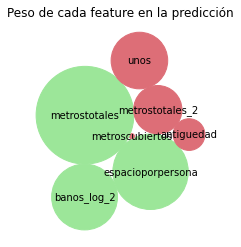

True
1613879.7006962993    0.23047529924430257    0.04536719119489845 %    0.15122873345935728


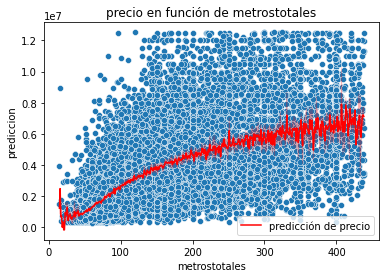

In [50]:
add_function_features(dfMexicoCity, ['metrostotales'], cuadratic, '_2')
dfMexicoCity['espacioporpersona'] = dfMexicoCity['metroscubiertos'] / dfMexicoCity['habitaciones']
dfMexicoCity['unos'] = np.ones(len(dfMexicoCity['metroscubiertos']))
add_function_features(dfMexicoCity, ['banos'], log, '_log')
add_function_features(dfMexicoCity, ['banos_log'], cuadratic, '_2')
columns=["banos_log_2", "espacioporpersona", "metroscubiertos", "metrostotales", "metrostotales_2", "antiguedad", "unos"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, column_to_show='metrostotales')

Vemos que para el log a_la 2 de baños, la metrica mejora. 
Elegimos logaritmo porque queriamos que el crecimiento no fuese tan grande como en el lineal, pero veiamos que el logaritmo solo se estancaba demasiado rapido por o que probamos con el logaritmo cuadrado ya que tiene un crecimiento mayor pero mucho mas suave que en el caso lineal.

# Antiguedad

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Size:  26452
[('antiguedad_inv', 998727.715834485, 239664.54672459431), ('banos_log_2', 872424.556673786, 1027632.4403439225), ('espacioporpersona', 24854.35072662923, 1378785.3291066329), ('metroscubiertos', 215.99656166210946, 33065.732225240165), ('metrostotales', 16588.710753406653, 2360334.8564311205), ('metrostotales_2', -20.57958659228567, -571485.6537736981), ('unos', -1267793.3515418014, -1267793.3515418014)]
                name         value
0     antiguedad_inv  2.396645e+05
1        banos_log_2  1.027632e+06
2  espacioporpersona  1.378785e+06
3    metroscubiertos  3.306573e+04
4      metrostotales  2.360335e+06
5    metrostotales_2 -5.714857e+05
6               unos -1.267793e+06


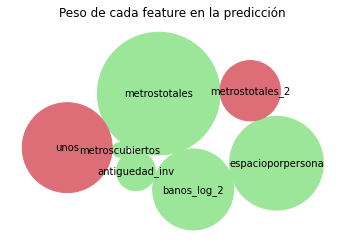

True
1598754.6104251926    0.21848573834492377    0.018902162839510937 %    0.11342155009451796


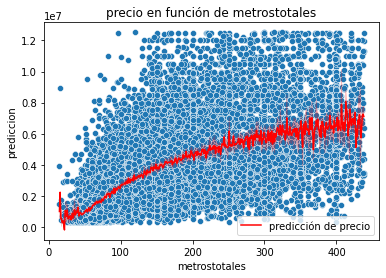

In [51]:
add_function_features(dfMexicoCity, ['metrostotales'], cuadratic, '_2')
dfMexicoCity['espacioporpersona'] = dfMexicoCity['metroscubiertos'] / dfMexicoCity['habitaciones']
dfMexicoCity['unos'] = np.ones(len(dfMexicoCity['metroscubiertos']))
add_function_features(dfMexicoCity, ['banos'], log, '_log')
add_function_features(dfMexicoCity, ['banos_log'], cuadratic, '_2')
add_function_features(dfMexicoCity, ['antiguedad'], inversa, '_inv')
columns=["antiguedad_inv", "banos_log_2", "espacioporpersona", "metroscubiertos", "metrostotales", "metrostotales_2", "unos"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, column_to_show='metrostotales')

## Metropolis improvacion

Size:  12106
[('antiguedad_inv', array([494877.0510175])), ('banos_log_2', array([571917.23079397])), ('espacioporpersona', array([11707.21443891])), ('metroscubiertos', array([2920.85775632])), ('metrostotales', array([2267.81462209])), ('metrostotales_2', array([10.54223466])), ('unos', array([-645118.86613301]))]
False
1001047.666827633    0.19872111172044254    0.0 %    0.0


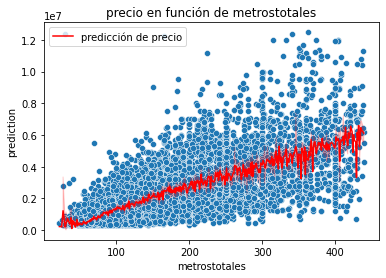

In [124]:
add_function_features(dfMetropolis, ['metrostotales'], cuadratic, '_2')
dfMetropolis['espacioporpersona'] = dfMetropolis['metroscubiertos'] / dfMetropolis['habitaciones']
dfMetropolis['unos'] = np.ones(len(dfMetropolis['metroscubiertos']))
add_function_features(dfMetropolis, ['banos'], log, '_log')
add_function_features(dfMetropolis, ['banos_log'], cuadratic, '_2')
add_function_features(dfMetropolis, ['antiguedad'], inversa, '_inv')
columns=["antiguedad_inv", "banos_log_2", "espacioporpersona", "metroscubiertos", "metrostotales", "metrostotales_2", "unos"]
plot_prediction(dfMetropolis, columns, kfold_flag=True, column_to_show='metrostotales')

El agregar poblacion empeoraba las metricas, intentamos con cuadrados y cubico, pero los valores eran demasiado grandes y afectaban a la importancia asignada ala resto de las variables. Por eso intentamos con raiz de poblacion y logaritmo esperando que un valor mas chico y con menos crecimiento, puedise ayudar a la preduiccion, pero seguia afectando bastante negativamente a las metricas. Concluimos entonces que probablemente como no son muchos valores distintos de poblacion (1M y 1.8M), ademas valores muy grandes y que novarian lo suficiente, entonces utilizar la poblacion como feature no ayuda a la prediccion del modelo. Creemos que la segmentacion eralizada en pasos anteriores ya logro extraer todos lo datos necesarios de la poblacion en este caso (las ciudades quizas son lo suficientemente similares como para que la poblacion no influya).

## Big city betterment

Size:  18576
[('antiguedad_inv', array([-112649.38559786])), ('banos_log_2', array([431256.46471069])), ('espacioporpersona', array([6208.64701713])), ('metroscubiertos', array([7136.57397127])), ('metrostotales', array([409.32380506])), ('metrostotales_2', array([4.52297346])), ('unos', array([-383368.42865956]))]
True
1033401.7330791473    0.1895595550414419    0.005382131324004306 %    0.05382131324004306


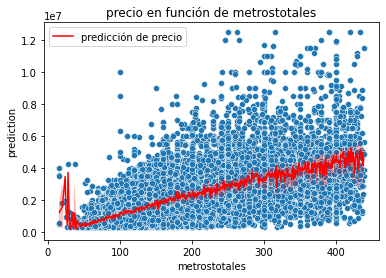

In [139]:
add_function_features(dfBigCity, ['metrostotales'], cuadratic, '_2')
dfBigCity['espacioporpersona'] = dfBigCity['metroscubiertos'] / dfBigCity['habitaciones']
dfBigCity['unos'] = np.ones(len(dfBigCity['metroscubiertos']))
add_function_features(dfBigCity, ['banos'], log, '_log')
add_function_features(dfBigCity, ['banos_log'], cuadratic, '_2')
add_function_features(dfBigCity, ['antiguedad'], inversa, '_inv')
columns=["antiguedad_inv", "banos_log_2", "espacioporpersona", "metroscubiertos", "metrostotales", "metrostotales_2", "unos"]
plot_prediction(dfBigCity, columns, kfold_flag=True, column_to_show='metrostotales')

Conclusión: agregar Poblacion no mejoro las metricas sino que las empeoró, entendemos que vuelve a pasar lo mismo que en el caso anterior (see above).

## Medium city enhanzancion

Size:  13378
[('antiguedad_inv', 72158.8793425571, 22884.663884964648), ('banos_log_2', 433058.7765642019, 492627.0535910063), ('espacioporpersona', 9399.489361835791, 492941.9314908725), ('metroscubiertos', 4821.70784214846, 735687.8063784346), ('metrostotales', -511.06977097927364, -80656.99458178392), ('metrostotales_2', 10.940504168167697, 366932.4251965104), ('unos', -360172.6096854404, -360172.6096854404)]
                name          value
0     antiguedad_inv   22884.663885
1        banos_log_2  492627.053591
2  espacioporpersona  492941.931491
3    metroscubiertos  735687.806378
4      metrostotales  -80656.994582
5    metrostotales_2  366932.425197
6               unos -360172.609685


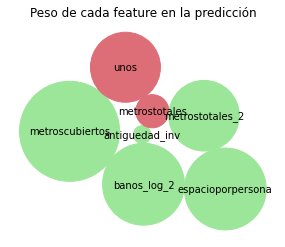

False
859700.4737495666    0.17936384686777884    0.0 %    0.0


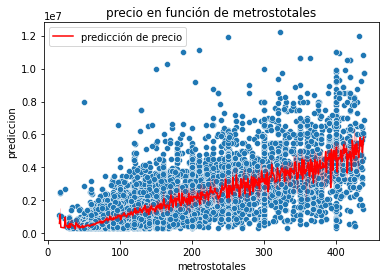

In [56]:
add_function_features(dfMediumCity, ['metrostotales'], cuadratic, '_2')
dfMediumCity['espacioporpersona'] = dfMediumCity['metroscubiertos'] / dfMediumCity['habitaciones']
dfMediumCity['unos'] = np.ones(len(dfMediumCity['metroscubiertos']))
add_function_features(dfMediumCity, ['banos'], log, '_log')
add_function_features(dfMediumCity, ['banos_log'], cuadratic, '_2')
add_function_features(dfMediumCity, ['antiguedad'], inversa, '_inv')
columns=["antiguedad_inv", "banos_log_2", "espacioporpersona", "metroscubiertos", "metrostotales", "metrostotales_2", "unos"]
plot_prediction(dfMediumCity, columns, kfold_flag=True, column_to_show='metrostotales')

## Small city upgradeded start = 0.3199

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Size:  10848
[('antiguedad', array([-5670.98561855])), ('banos_log_2', array([624066.1572777])), ('espacioporpersona', array([22571.1917369])), ('metroscubiertos', array([4246.92685383])), ('metrostotales', array([2772.24472538])), ('metrostotales_2', array([3.5747699])), ('unos', array([-1475856.35680751])), ('isVerySmall', array([-535665.25448466])), ('fecha', array([568.53022131]))]
True
1404486.045261651    0.3490020782245546    4.102020167667114 %    5.43778801843318


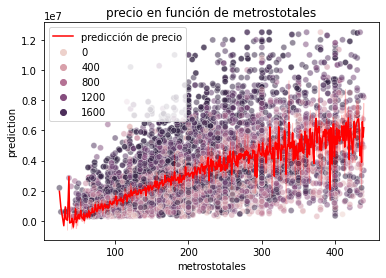

In [54]:
add_function_features(dfSmallCity, ['metrostotales'], cuadratic, '_2')
dfSmallCity['espacioporpersona'] = dfSmallCity['metroscubiertos'] / dfSmallCity['habitaciones']
dfSmallCity['unos'] = np.ones(len(dfSmallCity['metroscubiertos']))
add_function_features(dfSmallCity, ['banos'], log, '_log')
add_function_features(dfSmallCity, ['banos_log'], cuadratic, '_2')
add_function_features(dfSmallCity, ['antiguedad'], inversa, '_inv')
dfSmallCity['isVerySmall'] = dfSmallCity['poblacion'] < 150000
df_temp = dfSmallCity[dfSmallCity["fecha"]>913]
columns=["antiguedad", "banos_log_2", "espacioporpersona", "metroscubiertos", "metrostotales", "metrostotales_2", "unos", "isVerySmall", "fecha"]
plot_prediction_colorful(dfSmallCity, columns, kfold_flag=True, column_to_show='metrostotales')

Size:  10848
[('antiguedad', 391.566557605928, 2176.1759026091254), ('banos_log_2', 671997.2387081283, 911190.4557150144), ('espacioporpersona', 23737.625559183452, 1461024.1345150997), ('metroscubiertos', 4289.012444355476, 758940.9101781278), ('metrostotales', 3030.709552167333, 533032.1888379228), ('metrostotales_2', 2.2727018111602275, 89056.2885027477), ('unos', -1243697.2963505585, -1243697.2963505585)]
                name         value
0         antiguedad  2.176176e+03
1        banos_log_2  9.111905e+05
2  espacioporpersona  1.461024e+06
3    metroscubiertos  7.589409e+05
4      metrostotales  5.330322e+05
5    metrostotales_2  8.905629e+04
6               unos -1.243697e+06


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

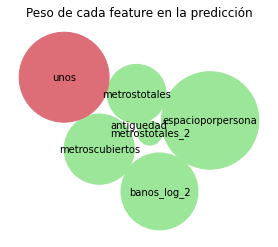

True
1448395.3213264397    0.32595598104169227    0.709804955192409 %    1.014760147601476


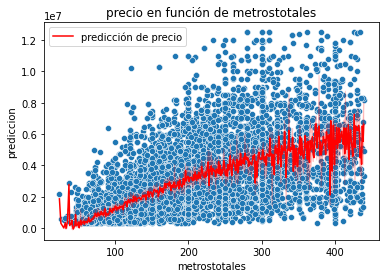

In [67]:
add_function_features(dfSmallCity, ['metrostotales'], cuadratic, '_2')
dfSmallCity['espacioporpersona'] = dfSmallCity['metroscubiertos'] / dfSmallCity['habitaciones']
dfSmallCity['unos'] = np.ones(len(dfSmallCity['metroscubiertos']))
add_function_features(dfSmallCity, ['banos'], log, '_log')
add_function_features(dfSmallCity, ['banos_log'], cuadratic, '_2')
add_function_features(dfSmallCity, ['antiguedad'], inversa, '_inv')
dfSmallCity['isVerySmall'] = dfSmallCity['poblacion'] < 150000
columns=["antiguedad", "banos_log_2", "espacioporpersona", "metroscubiertos", "metrostotales", "metrostotales_2", "unos"]
plot_prediction(dfSmallCity, columns, kfold_flag=True, column_to_show='metrostotales')

In [148]:
dfSmallCity["tipodepropiedad"].value_counts()

Casa                             9781
Apartamento                      5723
Casa en condominio               1862
Terreno                           865
Local Comercial                   267
Oficina comercial                 222
Edificio                          140
Terreno comercial                  69
Bodega comercial                   61
Quinta Vacacional                  52
Casa uso de suelo                  42
Otros                              36
Departamento Compartido            21
Villa                              21
Inmuebles productivos urbanos      19
Local en centro comercial          15
Duplex                              9
Rancho                              8
Nave industrial                     5
Terreno industrial                  2
Name: tipodepropiedad, dtype: int64

In [153]:
print(dfSmallCity["fecha"].min())
dfSmallCity["fecha"].max()

0


1826

In [53]:
def plot_prediction_colorful(df, columns, column_to_show='metrostotales', column_to_predict='precio', kfold_flag=False, title=''):
    df = df.reindex(columns=(columns+[column_to_predict])).dropna()
    y = df[column_to_predict].values
    df = df.drop(columns=[column_to_predict])
    X = df.to_numpy()
    print('Size: ', X.shape[0])
    #from sklearn.linear_model import LinearRegression


    #linear_regressor = LinearRegression()
    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(X,y)

    df['prediction'] = linear_regressor.predict(X)
    
    print(list(zip(df.columns, coef.T[0], coef.T[0] * col_avg)))
    
    data = { "name": columns, "value": coef.T[0] * col_avg }
    dfForBubble = pd.DataFrame(data)
    print(dfForBubble)
    dfForBubble['color'] = dfForBubble.apply(
        lambda row: '#9CE699' if row['value'] >= 0 else '#DD6E77',
        axis=1
    )
    dfForBubble['value'] = np.abs(dfForBubble['value'])
    plot_bubble(dfForBubble, title)

    print((df['prediction'] < 0).any())
    
    sns.scatterplot(x=df[column_to_show], y=y, hue=df["fecha"], alpha=0.5).set_title(f"{column_to_predict} en función de {column_to_show}{title}")
    sns.lineplot(data=df, x=column_to_show, y='prediction', color='red', label=f'predicción de {column_to_predict}')
    
    if (kfold_flag):
        X = X.reshape(len(X),len(columns))
        y = y.reshape(len(y),1)

        rmse, rmsle, avg_deleted, max_deleted = K_Fold(X, y, 10) # 10% de las muestras para testear
        print(rmse, '  ', rmsle, '  ', avg_deleted,"%", '  ', max_deleted )

# Mejorando small city con nueva segmentacion de datos

Size:  4057
[('antiguedad_inv', -155761.691199642, -71523.6176207778), ('banos_log_2', 497542.8839892242, 637052.56410566), ('espacioporpersona', 15676.828560522385, 921252.0970934088), ('metroscubiertos', 5497.781287786267, 932786.6114686616), ('metrostotales', 362.48039694072116, 62062.058378744594), ('metrostotales_2', 6.033169309963118, 228836.0969048614), ('unos', -714293.2813682777, -714293.2813682777)]
                name          value
0     antiguedad_inv  -71523.617621
1        banos_log_2  637052.564106
2  espacioporpersona  921252.097093
3    metroscubiertos  932786.611469
4      metrostotales   62062.058379
5    metrostotales_2  228836.096905
6               unos -714293.281368


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

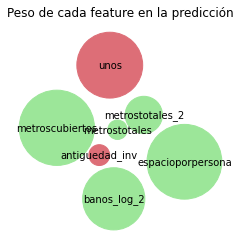

True
901515.4305635088    0.2508467149301696    0.665389527458493 %    0.9876543209876543


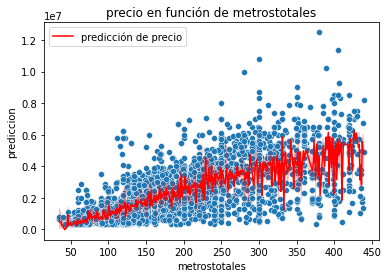

In [57]:
add_function_features(dfSmallCity, ['metrostotales'], cuadratic, '_2')
dfSmallCity['espacioporpersona'] = dfSmallCity['metroscubiertos'] / dfSmallCity['habitaciones']
dfSmallCity['unos'] = np.ones(len(dfSmallCity['metroscubiertos']))
add_function_features(dfSmallCity, ['banos'], log, '_log')
add_function_features(dfSmallCity, ['banos_log'], cuadratic, '_2')
add_function_features(dfSmallCity, ['antiguedad'], inversa, '_inv')
dfSmallCity['isVerySmall'] = dfSmallCity['poblacion'] < 150000
df_temp = dfSmallCity[dfSmallCity["fecha"]<=913]
columns=["antiguedad_inv", "banos_log_2", "espacioporpersona", "metroscubiertos", "metrostotales", "metrostotales_2", "unos"]
plot_prediction(df_temp, columns, kfold_flag=True, column_to_show='metrostotales')

In [ ]:
add_function_features(dfSmallCity, ['metrostotales'], cuadratic, '_2')
dfSmallCity['espacioporpersona'] = dfSmallCity['metroscubiertos'] / dfSmallCity['habitaciones']
dfSmallCity['unos'] = np.ones(len(dfSmallCity['metroscubiertos']))
add_function_features(dfSmallCity, ['banos'], log, '_log')
add_function_features(dfSmallCity, ['banos_log'], cuadratic, '_2')
add_function_features(dfSmallCity, ['antiguedad'], inversa, '_inv')
dfSmallCity['isVerySmall'] = dfSmallCity['poblacion'] < 150000
df_temp = dfSmallCity[dfSmallCity["fecha"]<=913]
columns=["antiguedad_inv", "banos_log_2", "espacioporpersona", "metroscubiertos", "metrostotales", "metrostotales_2", "unos"]
plot_prediction(df_temp, columns, kfold_flag=True, column_to_show='metrostotales')

Size:  4057
[('antiguedad', 4915.294996124346, 28873.874870011194), ('banos_log_2', 495168.29017738247, 634012.1406060527), ('espacioporpersona', 15721.22132259917, 923860.8470074058), ('metroscubiertos', 5498.266674101864, 932868.9650278301), ('metrostotales', 317.1553318080491, 54301.73020093056), ('metrostotales_2', 6.09432088111321, 231155.55557453237), ('unos', -808900.5843244822, -808900.5843244822)]
                name          value
0         antiguedad   28873.874870
1        banos_log_2  634012.140606
2  espacioporpersona  923860.847007
3    metroscubiertos  932868.965028
4      metrostotales   54301.730201
5    metrostotales_2  231155.555575
6               unos -808900.584324


/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

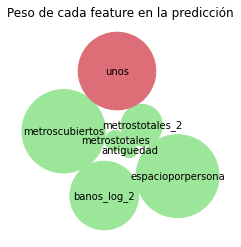

True
900952.4570440296    0.2530547868906429    0.0985829836404549 %    0.49261083743842365


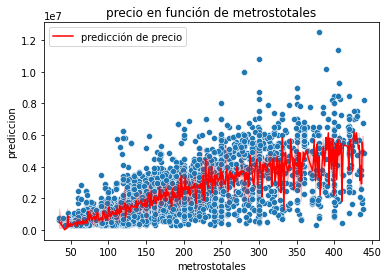

In [58]:
add_function_features(dfSmallCity, ['metrostotales'], cuadratic, '_2')
dfSmallCity['espacioporpersona'] = dfSmallCity['metroscubiertos'] / dfSmallCity['habitaciones']
dfSmallCity['unos'] = np.ones(len(dfSmallCity['metroscubiertos']))
add_function_features(dfSmallCity, ['banos'], log, '_log')
add_function_features(dfSmallCity, ['banos_log'], cuadratic, '_2')
add_function_features(dfSmallCity, ['antiguedad'], inversa, '_inv')
dfSmallCity['isVerySmall'] = dfSmallCity['poblacion'] < 150000
df_temp = dfSmallCity[dfSmallCity["fecha"]<=913]
columns=["antiguedad", "banos_log_2", "espacioporpersona", "metroscubiertos", "metrostotales", "metrostotales_2", "unos"]
plot_prediction(df_temp, columns, kfold_flag=True, column_to_show='metrostotales')

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

Size:  6791
[('antiguedad', -18069.497475992033, -97004.8107027303), ('antiguedad_2', 445.37031854142106, 30531.968365082772), ('banos_log_2', 746174.9094018165, 1045447.6305135638), ('espacioporpersona', 25315.908919617534, 1600265.6830397542), ('metroscubiertos', 4065.862280377718, 737147.2376652), ('metrostotales', 43748.79382092923, 7816255.750105189), ('metrostotales_2', -46.69923430245919, -1864946.8086843584), ('metrostotales_log', -3423641.9089982775, -17353702.891188305), ('unos', 11201250.189452482, 11201250.189452482), ('isVerySmall', -640985.0043792132, -295527.0282302042)]
                name         value
0         antiguedad -9.700481e+04
1       antiguedad_2  3.053197e+04
2        banos_log_2  1.045448e+06
3  espacioporpersona  1.600266e+06
4    metroscubiertos  7.371472e+05
5      metrostotales  7.816256e+06
6    metrostotales_2 -1.864947e+06
7  metrostotales_log -1.735370e+07
8               unos  1.120125e+07
9        isVerySmall -2.955270e+05


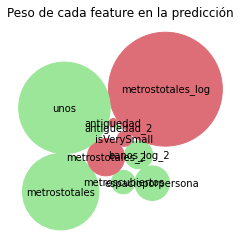

True
1602828.9560097572    0.36844729307873797    1.354847093476566 %    2.3564064801178204


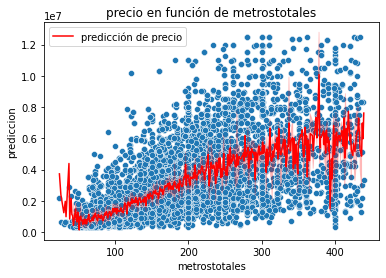

In [68]:
add_function_features(dfSmallCity, ['metrostotales'], log, '_log')
add_function_features(dfSmallCity, ['metrostotales'], cuadratic, '_2')
add_function_features(dfSmallCity, ['metroscubiertos'], log, '_log')
dfSmallCity['espacioporpersona'] = dfSmallCity['metroscubiertos'] / dfSmallCity['habitaciones']
add_function_features(dfSmallCity, ['espacioporpersona'], sen, '_sen')
add_function_features(dfSmallCity, ['espacioporpersona_sen'], cuadratic, '_2')
dfSmallCity['unos'] = np.ones(len(dfSmallCity['metroscubiertos']))
add_function_features(dfSmallCity, ['banos'], log, '_log')
add_function_features(dfSmallCity, ['banos_log'], cuadratic, '_2')
add_function_features(dfSmallCity, ['antiguedad'], cuadratic, '_2')
dfSmallCity['isVerySmall'] = dfSmallCity['poblacion'] < 150000
df_temp = dfSmallCity[dfSmallCity["fecha"]>913]
columns=["antiguedad", "antiguedad_2", "banos_log_2", "espacioporpersona", "metroscubiertos", "metrostotales", "metrostotales_2", "metrostotales_log", "unos", "isVerySmall"]
plot_prediction(df_temp, columns, kfold_flag=True, column_to_show='metrostotales')

0.3346  "antiguedad", "antiguedad_2", "banos_log_2", "espacioporpersona", "metroscubiertos", "metrostotales", "metrostotales_2", "metrostotales_log", "unos", "isVerySmall"]

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

Size:  10848
[('antiguedad', -13103.419490624347, -72823.75162889484), ('antiguedad_2', 197.06232617175246, 15339.452816585577), ('banos_log_2', 683685.3878888461, 927038.9285434408), ('espacioporpersona', 23502.545648862902, 1446555.2306366705), ('metroscubiertos', 4112.04558492127, 727626.6178759185), ('metrostotales', 33478.35225719867, 5888073.098123243), ('metrostotales_2', -34.72310910706276, -1360632.1811185272), ('metrostotales_log', -2629928.6518371007, -13269116.151735948), ('unos', 8469605.480566967, 8469605.480566967), ('isVerySmall', -553241.3315313874, -259943.86677871327)]
                name         value
0         antiguedad -7.282375e+04
1       antiguedad_2  1.533945e+04
2        banos_log_2  9.270389e+05
3  espacioporpersona  1.446555e+06
4    metroscubiertos  7.276266e+05
5      metrostotales  5.888073e+06
6    metrostotales_2 -1.360632e+06
7  metrostotales_log -1.326912e+07
8               unos  8.469605e+06
9        isVerySmall -2.599439e+05


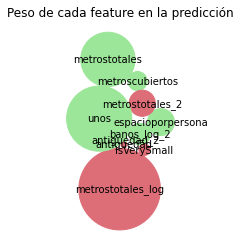

True
1420504.9104366577    0.37890726285761467    1.4657268692502592 %    2.304147465437788


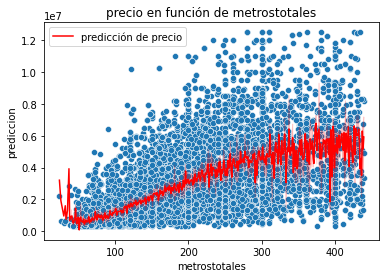

In [60]:
add_function_features(dfSmallCity, ['metrostotales'], log, '_log')
add_function_features(dfSmallCity, ['metrostotales'], cuadratic, '_2')
add_function_features(dfSmallCity, ['metroscubiertos'], log, '_log')
dfSmallCity['espacioporpersona'] = dfSmallCity['metroscubiertos'] / dfSmallCity['habitaciones']
add_function_features(dfSmallCity, ['espacioporpersona'], sen, '_sen')
add_function_features(dfSmallCity, ['espacioporpersona_sen'], cuadratic, '_2')
dfSmallCity['unos'] = np.ones(len(dfSmallCity['metroscubiertos']))
add_function_features(dfSmallCity, ['banos'], log, '_log')
add_function_features(dfSmallCity, ['banos_log'], cuadratic, '_2')
add_function_features(dfSmallCity, ['antiguedad'], cuadratic, '_2')
dfSmallCity['isVerySmall'] = dfSmallCity['poblacion'] < 150000
df_temp = dfSmallCity[dfSmallCity["fecha"]<=913]
columns=["antiguedad", "antiguedad_2", "banos_log_2", "espacioporpersona", "metroscubiertos", "metrostotales", "metrostotales_2", "metrostotales_log", "unos", "isVerySmall"]
plot_prediction(dfSmallCity, columns, kfold_flag=True, column_to_show='metrostotales')

Approach cronologico:
Tiene sentido que para small city no funcione tan bien porque los features los acomodamos en base a mexico city que seria el otro extremo del espectro(una ciudad muy grande) de poblacion. 
Lo que nos llama la atencion es que antiguedad_inv tiene un coeficiente negativo lo cual indicaria que ante una mayor antiguedad mas alato es el precio, es decir el comportamiento inverso al observado en escenarios anteriores. Esto quizas esta relacionado a que en ciudades mas pequeñas hay una mayor presencia de casas antiguas. Cambiamos antiguedad inv por antieguedad para que el coeficiente quedase positivo. Haciendo esto vimos que la metrica mejoraba. Esto refuerza la idea de que hay un comportamiento distinto entre ciudades grandes y pequeñas(ver de incluir el tema de los boxplots que esta mas abajo).
Como no nos esta dando bien, decidimos agregar el dato de fecha para ver si podríamos hacer una segmentacion (grafico de colores). 
Vimos que se podia notar en fechas mas antiguas vs fechas mas recientes, dos tendencias separadas. Dividimos el periodo de fechas en 2 y lo usamos para segregar el dataset. 
En el primer periodo de fechas mas antigua vimos que el rmsle es mucho mejor por lo que la segregacion en esta caso seria beneficiosa (0.14 de diferencia).
En el segundo grafico sin embargo vemos que mejora pero no de la misma magnitud que el anterior, los datos estan mas dispersos.
Algo a notar es que el rango de precios es menor en el caso de fechas mas antiguas y tiene valores mas altos en el caso de fechas mas recientes, es decir que esto probablemente ese ligado con el aumento del precio de las propiedaddes a lo largo del tiempo, ya sea por inflacion o por variables/fluctuaciones del mercado inmobiliario.
Esto indicaria que la segmentacion en este caso tenia sentido pensarla.
Como nos daba mal el segundo caso decidimos variar un poco los features utilizados porque observamos que las caracteristicas en este caso se comportaban de manera distinta.
En 1er lugar vimos que a metrostotales_2 le estaba asignando un valor chiquito, y ademas notamos en el grafico/datos que la funcion no era lineal ni cuadratica sino que tenia una tendencia logaritmica. (agregamos log y dio mejor :thumbs_up:)
Luego como vimos que antiguedad tenia un comportamiento distinto en este tipo de ciudades, decidimos agregar este valor al cuadrado para ver si esta combinacion mejoraba la metrica. Esta combinacion si mejoraba la metrica asi que lo dejamos. Como vimos que mejoraba las metricas lo extrapolamos y lo utilizamos en el periodo anterior y vimos que tambien obtenia buenos valores. O sea que utilizamos esta combinacion de caracteristicas como la mejor que encontramos para ciudades pequeñas. 

2433482.708071279
2627218.374233129
2481682.1934566144


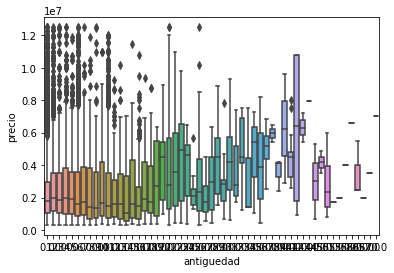

In [61]:
print(dfSmallCity[dfSmallCity['antiguedad']==0]['precio'].mean())#.value_counts()/len(dfSmallCity))
print(dfSmallCity[dfSmallCity['antiguedad']==5]['precio'].mean())
print(dfSmallCity[dfSmallCity['antiguedad']==10]['precio'].mean())
sns.boxplot(x='antiguedad', y='precio', data=dfSmallCity)
#print(dfMexicoCity[dfMexicoCity['antiguedad']==0]['precio'])#.value_counts()/len(dfMexicoCity))

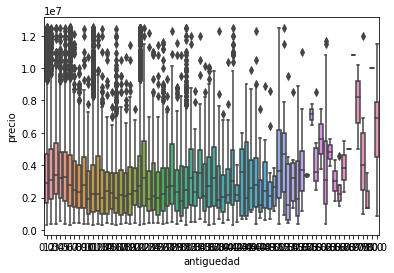

In [62]:
sns.boxplot(x='antiguedad', y='precio', data=dfMexicoCity)

Conclusion, vemos que en small city la mediana de precio tiene una pequeña tendencia a subir cuando la antiguedad incrementa, mientras que en mexCity pasa lo contrario, teoria confirma3. (excluyendo los valores de antiguedad muy antigua, porque son super outliers)

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Size:  10848
[('antiguedad', array([-5670.98561855])), ('banos_log_2', array([624066.1572777])), ('espacioporpersona', array([22571.1917369])), ('metroscubiertos', array([4246.92685383])), ('metrostotales', array([2772.24472538])), ('metrostotales_2', array([3.5747699])), ('unos', array([-1475856.35680751])), ('isVerySmall', array([-535665.25448466])), ('fecha', array([568.53022131]))]
True
1404486.045261651    0.3490020782245546    4.102020167667114 %    5.43778801843318


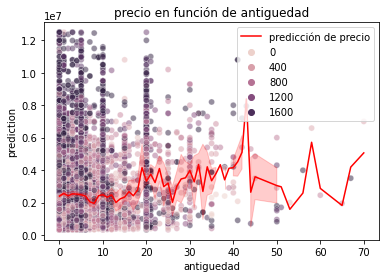

In [63]:
add_function_features(dfSmallCity, ['metrostotales'], cuadratic, '_2')
dfSmallCity['espacioporpersona'] = dfSmallCity['metroscubiertos'] / dfSmallCity['habitaciones']
dfSmallCity['unos'] = np.ones(len(dfSmallCity['metroscubiertos']))
add_function_features(dfSmallCity, ['banos'], log, '_log')
add_function_features(dfSmallCity, ['banos_log'], cuadratic, '_2')
add_function_features(dfSmallCity, ['antiguedad'], inversa, '_inv')
dfSmallCity['isVerySmall'] = dfSmallCity['poblacion'] < 150000
df_temp = dfSmallCity[dfSmallCity["fecha"]>913]
columns=["antiguedad", "banos_log_2", "espacioporpersona", "metroscubiertos", "metrostotales", "metrostotales_2", "unos", "isVerySmall", "fecha"]
plot_prediction_colorful(dfSmallCity, columns, kfold_flag=True, column_to_show='antiguedad')